In [1]:
import os
import pybedtools
import pandas as pd
import numpy as np
import glob
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
#import pybedtools
import random
from Bio import SeqIO
from Bio.Seq import Seq
import pysam

This notebook incorporates Genes and Transcripts with 0 edits and LM to get signal over background

In [2]:
custom_palette = ['#C8ADC0', '#FE9920', '#028090', '#151E3F', '#7E1F86','#F27D18']

In [3]:
sns_palette = sns.color_palette(custom_palette)

In [4]:
sns_palette

[(0.7843137254901961, 0.6784313725490196, 0.7529411764705882),
 (0.996078431372549, 0.6, 0.12549019607843137),
 (0.00784313725490196, 0.5019607843137255, 0.5647058823529412),
 (0.08235294117647059, 0.11764705882352941, 0.24705882352941178),
 (0.49411764705882355, 0.12156862745098039, 0.5254901960784314),
 (0.9490196078431372, 0.49019607843137253, 0.09411764705882353)]

In [5]:
sns.set_palette(sns_palette)

In [6]:
working_dir = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline'

In [7]:
fig_path = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/figs/'

In [8]:
sample_dict_apo = {'rep1' : 'APO1_1', 
               'rep2' : 'APO1_2',
               'rep3' : 'APO1_3',}
sample_dict_rps2 = {'rep1' : 'RPS2_1', 
               'rep2' : 'RPS2_2',
               'rep3' : 'RPS2_3',}

In [9]:
output_dir = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline'

In [10]:
gtf_file = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/gencode.v19.annotation.gtf'  # Replace with your GTF file path

In [11]:
glob.glob(os.path.join(working_dir, f'{sample_dict_rps2["rep1"]}/output_dir/read_level_edits_ct/*edits_*.bed'))[:5]

['/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/RPS2_1/output_dir/read_level_edits_ct/split_bam_1_37_read_level_edits_3utr.bed',
 '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/RPS2_1/output_dir/read_level_edits_ct/split_bam_2_0_read_level_edits_5utr.bed',
 '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/RPS2_1/output_dir/read_level_edits_ct/split_bam_1_50_read_level_edits_3utr.bed',
 '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/RPS2_1/output_dir/read_level_edits_ct/split_bam_1_2_read_level_edits_3utr.bed',
 '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/RPS2_1/output_dir/read_level_edits_ct/split_bam_4_1_read_level_edits_CDS.bed']

In [12]:
#pysam.view("-c", os.path.join(working_dir, f'{sample_dict_rps2[keys]}/input_dir/{sample_dict_rps2[keys]}.flnc.aligned.readfiltered.sorted.bam'))

In [13]:
total_mapped_reads = {}
for keys in ['rep1', 'rep2', 'rep3']:
    total_mapped_reads[sample_dict_rps2[keys]] = int(pysam.view("-c", os.path.join(working_dir, f'{sample_dict_rps2[keys]}/input_dir/{sample_dict_rps2[keys]}.flnc.aligned.readfiltered.sorted.bam')).strip('\n'))
    total_mapped_reads[sample_dict_apo[keys]] = int(pysam.view("-c", os.path.join(working_dir, f'{sample_dict_apo[keys]}/input_dir/{sample_dict_apo[keys]}.flnc.aligned.readfiltered.sorted.bam')).strip('\n'))

In [14]:
total_mapped_reads

{'RPS2_1': 382261,
 'APO1_1': 329206,
 'RPS2_2': 293649,
 'APO1_2': 300241,
 'RPS2_3': 319713,
 'APO1_3': 252245}

In [15]:
# sns.set_style('white')
# pd.DataFrame.from_dict(total_mapped_reads, orient='index').plot.bar()

In [16]:
gtf_len_df = pd.read_csv(gtf_file, sep='\t', header=None, comment='#')
# # Filter rows with the "gene" feature
gtf_len_df = gtf_len_df[gtf_len_df[2] == 'gene']
# # Calculate gene lengths
gtf_len_df['gene_length'] = gtf_len_df[4] - gtf_len_df[3] + 1
# # Create a dictionary with gene names as keys and gene lengths as values
gtf_len_df['gene_id'] = gtf_len_df[8].str.extract('gene_id "([^"]+)"')
gene_length_dict = gtf_len_df.set_index('gene_id')['gene_length'].to_dict()

gtf_len_df['gene_name'] = gtf_len_df[8].str.extract('gene_name "([^"]+)"')
gene_name_length_dict = gtf_len_df.set_index('gene_name')['gene_length'].to_dict()
gene_id_to_name_dict = gtf_len_df.set_index('gene_id')['gene_name'].to_dict()

In [17]:
gtf_transcript_to_gene_df = pd.read_csv(gtf_file, sep='\t', header=None, comment='#')
gtf_transcript_to_gene_df = gtf_transcript_to_gene_df[gtf_transcript_to_gene_df[2] == 'transcript']
gtf_transcript_to_gene_df['gene_id'] = gtf_transcript_to_gene_df[8].str.extract('gene_id "([^"]+)"')
gtf_transcript_to_gene_df['transcript_id'] = gtf_transcript_to_gene_df[8].str.extract('transcript_id "([^"]+)"')
gtf_transcript_to_gene_df['transcript_length'] = gtf_transcript_to_gene_df[4] - gtf_transcript_to_gene_df[3]

In [18]:
gtf_transcript_to_gene_dict = dict(zip(gtf_transcript_to_gene_df.transcript_id, gtf_transcript_to_gene_df.gene_id))

In [19]:
gtf_transcript_to_length_dict = dict(zip(gtf_transcript_to_gene_df.transcript_id, gtf_transcript_to_gene_df.transcript_length))

In [20]:
feature_counts={}
for rep in ['rep1', 'rep2', 'rep3']:
    for sample_dict in [sample_dict_apo, sample_dict_rps2]:
        counts_table = pd.read_csv(f'/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/{sample_dict[rep]}/output_dir/feature_counts/exon_counts.txt', comment='#', sep='\t', usecols=['Geneid', 'Length',f'/home/pjaganna1/scratch/stamp_v3_pipeline/{sample_dict[rep]}/input_dir/{sample_dict[rep]}.flnc.aligned.readfiltered.sorted.bam' ])
        counts_table = counts_table.rename(columns={f'/home/pjaganna1/scratch/stamp_v3_pipeline/{sample_dict[rep]}/input_dir/{sample_dict[rep]}.flnc.aligned.readfiltered.sorted.bam': f'{sample_dict[rep]}'})
        counts_table = counts_table[counts_table[f'{sample_dict[rep]}'] >=20]
        counts_table[f'{sample_dict[rep]}_RPKM'] = counts_table.apply(lambda x: (x[f'{sample_dict[rep]}'])/((counts_table[f'{sample_dict[rep]}'].sum()/1000000.)*(x['Length']/1000.)), axis=1)
        #counts_table[f'{sample_dict[rep]}_RPKM'] = (counts_table[f'{sample_dict[rep]}'] * 1e6) / (counts_table[f'{sample_dict[rep]}'].sum() * (counts_table['Length'] / 1000))
        feature_counts[f'{sample_dict[rep]}'] = counts_table

In [21]:
get_exp_genes = pd.DataFrame()
for tab in feature_counts:
    get_exp_genes = pd.concat([get_exp_genes, feature_counts[tab].set_index('Geneid')], axis=1)
expressed_genes = list(get_exp_genes.index.map(gene_id_to_name_dict))

In [22]:
# for g in expressed_genes:
#     print(g)

In [23]:
transcript_counts={}
for rep in ['rep1', 'rep2', 'rep3']:
    for sample_dict in [sample_dict_apo, sample_dict_rps2]:
        transcript_counts_table = pd.read_csv(f'/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/{sample_dict[rep]}/output_dir/{sample_dict[rep]}_isoquant/{sample_dict[rep]}/{sample_dict[rep]}.transcript_counts.tsv', comment='#', sep='\t', header=None)
        transcript_counts_table = transcript_counts_table.rename(columns={0:'transcript_id', 1: f'{sample_dict[rep]}_count'})
        transcript_counts_table['Length'] = transcript_counts_table.transcript_id.map(gtf_transcript_to_length_dict)
        transcript_counts_table = transcript_counts_table[transcript_counts_table[f'{sample_dict[rep]}_count'] >=20]
        transcript_counts_table[f'{sample_dict[rep]}_RPKM'] = transcript_counts_table.apply(lambda x: (x[f'{sample_dict[rep]}_count'])/((transcript_counts_table[f'{sample_dict[rep]}_count'].sum()/1000000.)*(x['Length']/1000.)), axis=1)
        transcript_counts[f'{sample_dict[rep]}'] = transcript_counts_table.set_index('transcript_id')

In [24]:
gene_counts = {}
for key in transcript_counts:
    gene_count_df=transcript_counts[key].copy()
    gene_count_df['gene_id'] = gene_count_df.index.map(gtf_transcript_to_gene_dict)
    gene_count_df = gene_count_df[[f'{key}_count', 'gene_id']].groupby('gene_id').sum()
    gene_count_df = gene_count_df.rename(columns={f'{key}_count' : f'{key}'})
    gene_count_df['Length'] = gene_count_df.index.map(gene_length_dict)
    gene_count_df[f'{key}_RPKM'] = gene_count_df.apply(lambda x: (x[f'{key}'])/((gene_count_df[f'{key}'].sum()/1000000.)*(x['Length']/1000.)), axis=1)
    gene_count_df = gene_count_df[gene_count_df[key] >=20]
    gene_count_df = gene_count_df.reset_index().rename(columns={'gene_id' : 'Geneid'})

    gene_counts[key] = gene_count_df

#### Get Read Level Edits

In [25]:
def concat_splits_all_edits(sample_dict):
    '''concatenate all position level edits from all splits and reps and store as dictionary'''
    concat_edits = {}
    for key in sample_dict:
        print(key)
        read_level_edits_df = pd.DataFrame()
        empty_splits = []
        for p in tqdm.tqdm(glob.glob(os.path.join(working_dir, f'{sample_dict[key]}/output_dir/read_level_edits_ct/*edits_*.bed'))):
            if os.path.getsize(p) != 0:
                edit_df = pd.read_csv(p, sep='\t', header=None)
                edit_df['split_label'] =  p.split('/')[-1].split('_read_level_edits')[0]
                edit_df['key'] = edit_df.apply(lambda x: f'{x[0]}:{str(x[1])}:{str(x[2])}', axis=1)
                edit_df['location'] = p.split('/')[-1].split('.bed')[0].split('edits_')[-1]
                edit_df = edit_df[edit_df['location']=='CDS'] #### ONLY KEEPING CDS
                read_level_edits_df = pd.concat([read_level_edits_df, edit_df])
            else:
                empty_splits.append(p.split('/')[-1])
        
        print(' '.join(empty_splits))
        concat_edits[key] = read_level_edits_df
        
    return concat_edits

In [26]:
concat_edits_apo = concat_splits_all_edits(sample_dict_apo)

rep1


100%|██████████| 426/426 [00:05<00:00, 82.00it/s] 


split_bam_1_82_read_level_edits_5utr.bed split_bam_1_81_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_CDS.bed split_bam_9_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_3utr.bed split_bam_2_24_read_level_edits_5utr.bed split_bam_8_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_CDS.bed
rep2


100%|██████████| 411/411 [00:04<00:00, 85.02it/s] 


split_bam_2_21_read_level_edits_5utr.bed split_bam_11_0_read_level_edits_5utr.bed split_bam_1_82_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_CDS.bed split_bam_11_0_read_level_edits_3utr.bed split_bam_9_0_read_level_edits_CDS.bed split_bam_10_0_read_level_edits_5utr.bed split_bam_2_23_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_5utr.bed split_bam_9_0_read_level_edits_3utr.bed split_bam_10_0_read_level_edits_3utr.bed split_bam_2_26_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_3utr.bed split_bam_8_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_CDS.bed split_bam_11_0_read_level_edits_CDS.bed
rep3


100%|██████████| 420/420 [00:04<00:00, 84.00it/s] 

split_bam_1_81_read_level_edits_5utr.bed split_bam_3_7_read_level_edits_5utr.bed split_bam_1_71_read_level_edits_5utr.bed split_bam_8_0_read_level_edits_3utr.bed split_bam_2_19_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_5utr.bed split_bam_1_86_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_5utr.bed split_bam_1_80_read_level_edits_5utr.bed split_bam_3_5_read_level_edits_5utr.bed split_bam_1_83_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_3utr.bed split_bam_1_91_read_level_edits_5utr.bed split_bam_8_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_CDS.bed split_bam_1_89_read_level_edits_5utr.bed


In [27]:
for rep in ['rep1', 'rep2', 'rep3']:
    print(rep)
    print(concat_edits_apo[rep]['location'].value_counts())

rep1
location
CDS    20505
Name: count, dtype: int64
rep2
location
CDS    18856
Name: count, dtype: int64
rep3
location
CDS    17752
Name: count, dtype: int64


In [28]:
concat_edits_rps2 = concat_splits_all_edits(sample_dict_rps2)

rep1


100%|██████████| 390/390 [00:08<00:00, 45.62it/s]


split_bam_11_0_read_level_edits_5utr.bed split_bam_11_0_read_level_edits_3utr.bed split_bam_9_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_5utr.bed split_bam_9_0_read_level_edits_3utr.bed split_bam_10_0_read_level_edits_3utr.bed split_bam_8_0_read_level_edits_5utr.bed
rep2


100%|██████████| 387/387 [00:09<00:00, 41.02it/s]


split_bam_11_0_read_level_edits_5utr.bed split_bam_11_0_read_level_edits_3utr.bed split_bam_10_0_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_5utr.bed split_bam_1_75_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_3utr.bed split_bam_8_0_read_level_edits_5utr.bed
rep3


100%|██████████| 429/429 [00:08<00:00, 48.27it/s]

split_bam_9_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_3utr.bed split_bam_8_0_read_level_edits_5utr.bed


In [29]:
for rep in ['rep1', 'rep2', 'rep3']:
    print(rep)
    print(concat_edits_rps2[rep]['location'].value_counts())

rep1
location
CDS    86341
Name: count, dtype: int64
rep2
location
CDS    66044
Name: count, dtype: int64
rep3
location
CDS    77626
Name: count, dtype: int64


In [30]:
#concat_edits_rps2['rep1']

#### Get position level edits

In [31]:
def concat_splits_all_pos_edits(sample_dict):
    all_sample_pos_edits = {}
    for key in sample_dict:
        print(key)
        all_pos_edits_df = pd.DataFrame()
        empty_splits = []
        bed_files = [i for i in glob.glob(os.path.join(working_dir, f'{sample_dict[key]}/output_dir/*_ct_*.bed')) if '_transcript' not in i]
        for p in tqdm.tqdm(bed_files):
            if '_transcript' not in p:
                if os.path.getsize(p) != 0:
                    split_pos_edit_df = pd.read_csv(p, sep='\t', header=None)
                    split_pos_edit_df['split_label'] =  p.split('/')[-1].split('_ct_')[0]
                    split_pos_edit_df['key'] = split_pos_edit_df.apply(lambda x: f'{x[0]}:{str(x[1])}:{str(x[2])}', axis=1)
                    split_pos_edit_df['location'] = p.split('/')[-1].split('.bed')[0].split('_ct_')[-1]
                    split_pos_edit_df['conversion'] = split_pos_edit_df.apply(lambda x: int(x[4].split(',')[0]), axis=1)
                    split_pos_edit_df['coverage'] = split_pos_edit_df.apply(lambda x: int(x[4].split(',')[1]), axis=1)
                    split_pos_edit_df['edit_fraction'] = split_pos_edit_df.apply(lambda x: x['conversion']/x['coverage'], axis=1)
                    split_pos_edit_df = split_pos_edit_df[split_pos_edit_df['location']=='CDS']#### ONLY KEEPING CDS EDITS
                    all_pos_edits_df = pd.concat([all_pos_edits_df, split_pos_edit_df])
                else:
                    empty_splits.append(p.split('/')[-1])

        print(' '.join(empty_splits))
        all_sample_pos_edits[key] = all_pos_edits_df
        
    return all_sample_pos_edits

In [32]:
all_pos_edits_apo = concat_splits_all_pos_edits(sample_dict_apo)

rep1


100%|██████████| 426/426 [00:06<00:00, 67.38it/s]


split_bam_10_0_ct_CDS.bed split_bam_1_81_ct_5utr.bed split_bam_10_0_ct_3utr.bed split_bam_10_0_ct_5utr.bed split_bam_1_82_ct_5utr.bed split_bam_2_24_ct_5utr.bed split_bam_7_0_ct_CDS.bed split_bam_8_0_ct_5utr.bed split_bam_7_0_ct_5utr.bed split_bam_9_0_ct_5utr.bed
rep2


100%|██████████| 408/408 [00:05<00:00, 77.39it/s]


split_bam_10_0_ct_CDS.bed split_bam_7_0_ct_3utr.bed split_bam_10_0_ct_3utr.bed split_bam_2_23_ct_5utr.bed split_bam_10_0_ct_5utr.bed split_bam_9_0_ct_CDS.bed split_bam_1_82_ct_5utr.bed split_bam_2_26_ct_5utr.bed split_bam_7_0_ct_CDS.bed split_bam_9_0_ct_3utr.bed split_bam_8_0_ct_5utr.bed split_bam_2_21_ct_5utr.bed split_bam_7_0_ct_5utr.bed
rep3


100%|██████████| 420/420 [00:06<00:00, 67.98it/s]

split_bam_10_0_ct_CDS.bed split_bam_1_91_ct_5utr.bed split_bam_1_81_ct_5utr.bed split_bam_1_89_ct_5utr.bed split_bam_1_86_ct_5utr.bed split_bam_10_0_ct_3utr.bed split_bam_3_5_ct_5utr.bed split_bam_1_80_ct_5utr.bed split_bam_1_83_ct_5utr.bed split_bam_3_7_ct_5utr.bed split_bam_10_0_ct_5utr.bed split_bam_1_71_ct_5utr.bed split_bam_8_0_ct_3utr.bed split_bam_2_19_ct_5utr.bed split_bam_8_0_ct_5utr.bed split_bam_7_0_ct_5utr.bed


In [33]:
all_pos_edits_rps2 = concat_splits_all_pos_edits(sample_dict_rps2)

rep1


100%|██████████| 390/390 [00:11<00:00, 33.44it/s]


split_bam_10_0_ct_3utr.bed split_bam_10_0_ct_5utr.bed split_bam_11_0_ct_5utr.bed split_bam_9_0_ct_3utr.bed split_bam_8_0_ct_5utr.bed split_bam_11_0_ct_3utr.bed split_bam_7_0_ct_5utr.bed split_bam_9_0_ct_5utr.bed
rep2


100%|██████████| 387/387 [00:11<00:00, 33.59it/s]


split_bam_7_0_ct_3utr.bed split_bam_1_75_ct_5utr.bed split_bam_10_0_ct_5utr.bed split_bam_11_0_ct_5utr.bed split_bam_8_0_ct_5utr.bed split_bam_11_0_ct_3utr.bed split_bam_7_0_ct_5utr.bed
rep3


100%|██████████| 428/428 [00:11<00:00, 35.95it/s]

split_bam_10_0_ct_5utr.bed split_bam_8_0_ct_5utr.bed split_bam_7_0_ct_5utr.bed split_bam_9_0_ct_5utr.bed


In [34]:
#all_pos_edits_apo['rep1'].to_csv('APO_rep1_all_edits.tsv', sep='\t', index=False)

In [35]:
#all_pos_edits_rps2['rep1'].to_csv('RPS2_rep1_all_edits.tsv', sep='\t', index=False)

In [36]:
common_apo_sites = set(all_pos_edits_apo['rep1']['key'].tolist()).intersection(set(all_pos_edits_apo['rep2']['key'].tolist()).intersection(set(all_pos_edits_apo['rep3']['key'].tolist())))

In [37]:
common_rps2_sites = set(all_pos_edits_rps2['rep1']['key'].tolist()).intersection(set(all_pos_edits_rps2['rep2']['key'].tolist()).intersection(set(all_pos_edits_rps2['rep3']['key'].tolist())))

In [38]:
common_rps2_apo_sites = common_rps2_sites.intersection(common_apo_sites)

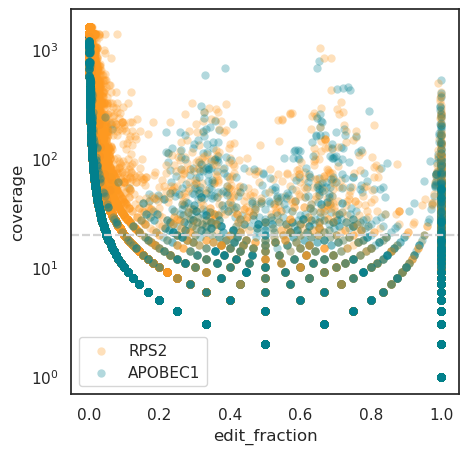

In [39]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style('white')

for rep in ['rep1', 'rep2', 'rep3']:
    sns.scatterplot(data=all_pos_edits_rps2[rep], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#FE9920')
    sns.scatterplot(data=all_pos_edits_apo[rep], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#028090')
    
    plt.yscale('log')
    plt.legend(['RPS2', 'APOBEC1'])
    plt.axhline(y=20, color='lightgrey', linestyle='dashed')
# plt.savefig(os.path.join(fig_path,'fig1/fig1_C_1.png'))
# plt.savefig(os.path.join(fig_path,'fig1/fig1_C_1.svg'))
# plt.savefig(os.path.join(fig_path,'fig1/fig1_C_1.jpg'))
plt.show()



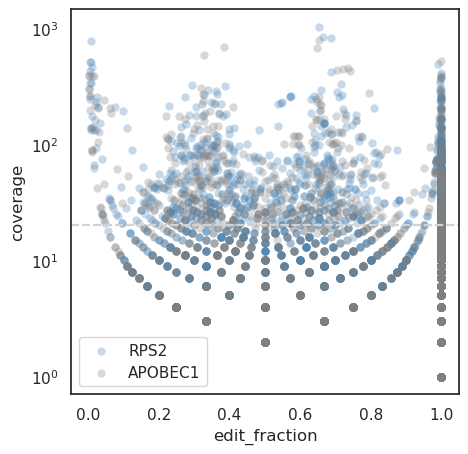

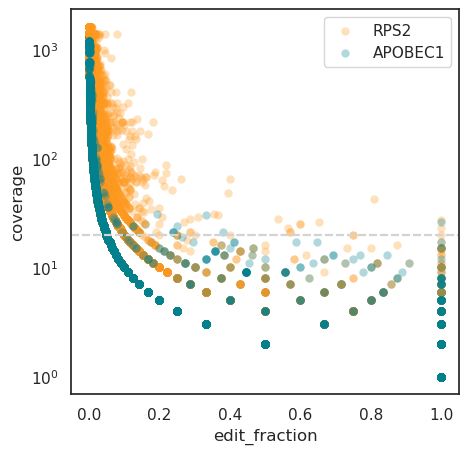

In [40]:
for rep in ['rep1', 'rep2', 'rep3']:
    sns.scatterplot(data=all_pos_edits_rps2[rep][all_pos_edits_rps2[rep]['key'].isin(common_rps2_apo_sites)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='steelblue')
    sns.scatterplot(data=all_pos_edits_apo[rep][all_pos_edits_apo[rep]['key'].isin(common_rps2_apo_sites)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='grey')
    
    plt.yscale('log')
    plt.legend(['RPS2', 'APOBEC1'])
    plt.axhline(y=20, color='lightgrey', linestyle='dashed')
plt.show()

for rep in ['rep1', 'rep2', 'rep3']:
    sns.scatterplot(data=all_pos_edits_rps2[rep][~all_pos_edits_rps2[rep]['key'].isin(common_rps2_apo_sites)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#FE9920')
    sns.scatterplot(data=all_pos_edits_apo[rep][~all_pos_edits_apo[rep]['key'].isin(common_rps2_apo_sites)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#028090')
    
    plt.yscale('log')
    plt.legend(['RPS2', 'APOBEC1'])
    plt.axhline(y=20, color='lightgrey', linestyle='dashed')
# plt.savefig(os.path.join(fig_path,'fig1/fig1_C_2.png'))
# plt.savefig(os.path.join(fig_path,'fig1/fig1_C_2.svg'))
# plt.savefig(os.path.join(fig_path,'fig1/fig1_C_2.jpg'))
plt.show()

In [41]:
all_pos_edits_apo_common_removed = {}
all_pos_edits_rps2_common_removed = {}
for rep in ['rep1', 'rep2', 'rep3']:
    all_pos_edits_apo_common_removed[rep] = all_pos_edits_apo[rep][~all_pos_edits_apo[rep]['key'].isin(common_rps2_apo_sites)]
    all_pos_edits_rps2_common_removed[rep] = all_pos_edits_rps2[rep][~all_pos_edits_rps2[rep]['key'].isin(common_rps2_apo_sites)]

In [42]:
# for rep in ['rep1', 'rep2', 'rep3']:
#     sns.scatterplot(data=all_pos_edits_rps2_common_removed[rep][all_pos_edits_rps2_common_removed[rep]['key'].isin(common_rps2_sites)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='steelblue')
#     sns.scatterplot(data=all_pos_edits_apo_common_removed[rep][all_pos_edits_apo_common_removed[rep]['key'].isin(common_rps2_sites)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='grey')
    
#     plt.yscale('log')
#     plt.legend(['RPS2', 'APOBEC1'])
#     plt.axhline(y=20, color='lightgrey', linestyle='dashed')
# plt.show()

# for rep in ['rep1', 'rep2', 'rep3']:
#     sns.scatterplot(data=all_pos_edits_rps2_common_removed[rep][~all_pos_edits_rps2_common_removed[rep]['key'].isin(common_rps2_sites)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='steelblue')
#     sns.scatterplot(data=all_pos_edits_apo_common_removed[rep][~all_pos_edits_apo_common_removed[rep]['key'].isin(common_rps2_sites)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='grey')
    
#     plt.yscale('log')
#     plt.legend(['RPS2', 'APOBEC1'])
#     plt.axhline(y=20, color='lightgrey', linestyle='dashed')
# plt.show()

In [43]:
all_pos_edits_apo_common_all_rps2_removed = {}
all_pos_edits_rps2_common_all_rps2_removed = {}
for rep in ['rep1', 'rep2', 'rep3']:
    #all_pos_edits_apo_common_all_rps2_removed[rep] = all_pos_edits_apo_common_removed[rep][~all_pos_edits_apo_common_removed[rep]['key'].isin(common_rps2_sites)]
    #all_pos_edits_rps2_common_all_rps2_removed[rep] = all_pos_edits_rps2_common_removed[rep][~all_pos_edits_rps2_common_removed[rep]['key'].isin(common_rps2_sites)]
    all_pos_edits_apo_common_all_rps2_removed[rep] = all_pos_edits_apo_common_removed[rep].copy()
    all_pos_edits_rps2_common_all_rps2_removed[rep] = all_pos_edits_rps2_common_removed[rep].copy()

In [44]:
# the coordinates are 0-based, and match the edits. checked using IGV
snps = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/hg19.commonSNPs147.bed3', sep='\t', header=None)

In [45]:
snps['key'] = snps.apply(lambda x: f'{x[0]}:{str(x[1])}:{str(x[2])}', axis=1)
snps['length'] = snps[2] - snps[1]
snps_list = snps['key'].tolist()

In [46]:
snps.head()

0          1          2                       key  length
0  chr1   40370176   40370176    chr1:40370176:40370176       0
1  chr1   61341695   61341699    chr1:61341695:61341699       4
2  chr1  180879355  180879367  chr1:180879355:180879367      12
3  chr1      10177      10177          chr1:10177:10177       0
4  chr1      10352      10352          chr1:10352:10352       0

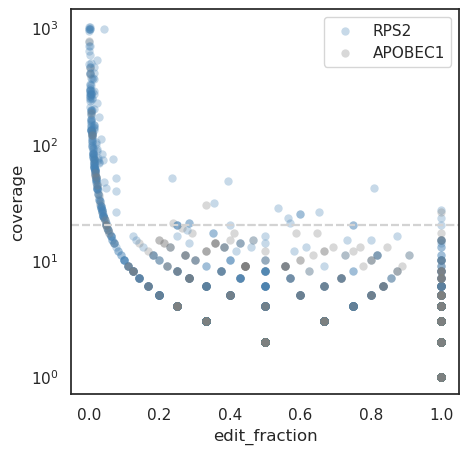

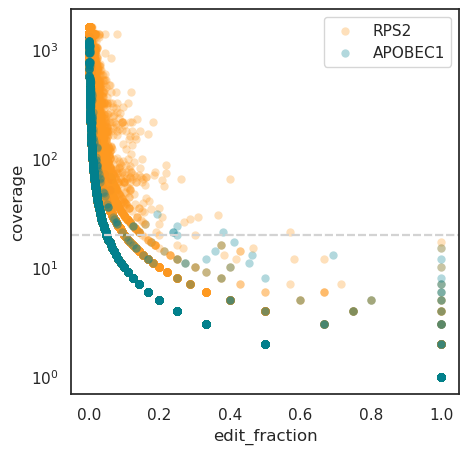

In [47]:
for rep in ['rep1', 'rep2', 'rep3']:
    sns.scatterplot(data=all_pos_edits_rps2_common_all_rps2_removed[rep][all_pos_edits_rps2_common_all_rps2_removed[rep]['key'].isin(snps_list)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='steelblue')
    sns.scatterplot(data=all_pos_edits_apo_common_all_rps2_removed[rep][all_pos_edits_apo_common_all_rps2_removed[rep]['key'].isin(snps_list)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='grey')
    
    plt.yscale('log')
    plt.legend(['RPS2', 'APOBEC1'])
    plt.axhline(y=20, color='lightgrey', linestyle='dashed')
plt.show()

for rep in ['rep1', 'rep2', 'rep3']:
    sns.scatterplot(data=all_pos_edits_rps2_common_all_rps2_removed[rep][~all_pos_edits_rps2_common_all_rps2_removed[rep]['key'].isin(snps_list)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#FE9920')
    sns.scatterplot(data=all_pos_edits_apo_common_all_rps2_removed[rep][~all_pos_edits_apo_common_all_rps2_removed[rep]['key'].isin(snps_list)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#028090')
    
    plt.yscale('log')
    plt.legend(['RPS2', 'APOBEC1'])
    plt.axhline(y=20, color='lightgrey', linestyle='dashed')
# plt.savefig(os.path.join(fig_path,'fig1/fig1_C_3.png'))
# plt.savefig(os.path.join(fig_path,'fig1/fig1_C_3.svg'))
# plt.savefig(os.path.join(fig_path,'fig1/fig1_C_3.jpg'))
plt.show()

In [48]:
all_pos_edits_apo_common_all_rps2_snp_removed = {}
all_pos_edits_rps2_common_all_rps2_snp_removed = {}
for rep in ['rep1', 'rep2', 'rep3']:
    all_pos_edits_apo_common_all_rps2_snp_removed[rep] = all_pos_edits_apo_common_all_rps2_removed[rep][~all_pos_edits_apo_common_all_rps2_removed[rep]['key'].isin(snps_list)]
    all_pos_edits_rps2_common_all_rps2_snp_removed[rep] = all_pos_edits_rps2_common_all_rps2_removed[rep][~all_pos_edits_rps2_common_all_rps2_removed[rep]['key'].isin(snps_list)]

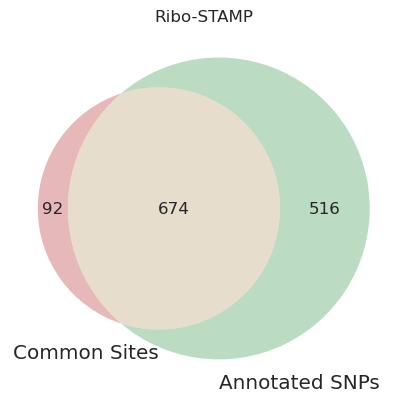

In [49]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn3

set1 = set(all_pos_edits_rps2[rep][all_pos_edits_rps2[rep]['key'].isin(common_rps2_apo_sites)]['key'].tolist())
set2 = set(all_pos_edits_rps2[rep][all_pos_edits_rps2[rep]['key'].isin(snps_list)]['key'].tolist())

venn2([set1, set2], ('Common Sites', 'Annotated SNPs'))
plt.title('Ribo-STAMP')
# plt.savefig(os.path.join(fig_path,'sup1/ribostamp_commonsite_snp_overlap.png'))
# plt.savefig(os.path.join(fig_path,'sup1/ribostamp_commonsite_snp_overlap.svg'))
# plt.savefig(os.path.join(fig_path,'sup1/ribostamp_commonsite_snp_overlap.jpg'))
plt.show()

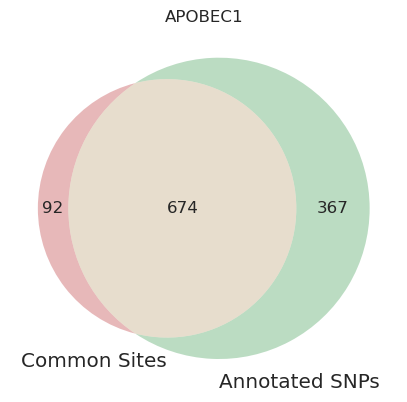

In [50]:
set1 = set(all_pos_edits_apo[rep][all_pos_edits_apo[rep]['key'].isin(common_rps2_apo_sites)]['key'].tolist())
set2 = set(all_pos_edits_apo[rep][all_pos_edits_apo[rep]['key'].isin(snps_list)]['key'].tolist())

venn2([set1, set2], ('Common Sites', 'Annotated SNPs'))
plt.title('APOBEC1')
# plt.savefig(os.path.join(fig_path,'sup1/apobec1_commonsite_snp_overlap.png'))
# plt.savefig(os.path.join(fig_path,'sup1/apobec1_commonsite_snp_overlap.svg'))
# plt.savefig(os.path.join(fig_path,'sup1/apobec1_commonsite_snp_overlap.jpg'))
plt.show()

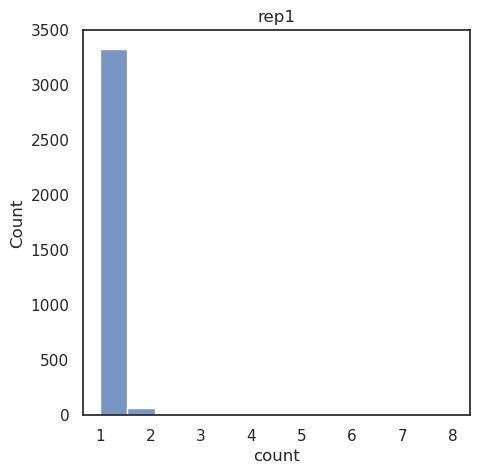

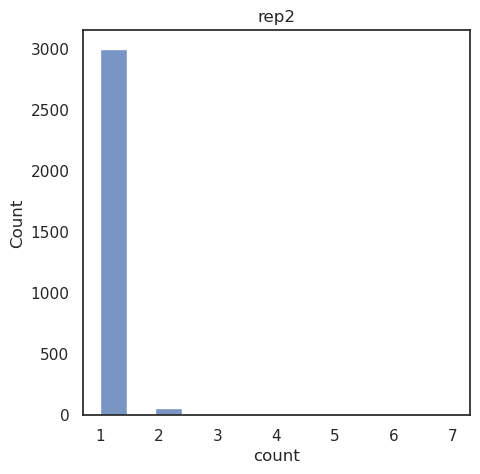

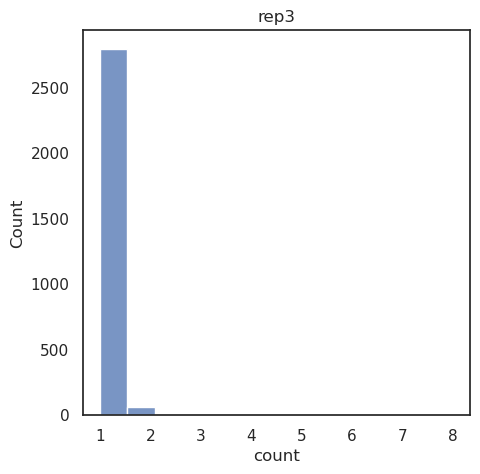

In [51]:
for rep in ['rep1', 'rep2', 'rep3']:
    read_edits_counts_apo = concat_edits_apo[rep][concat_edits_apo[rep]['key'].isin(all_pos_edits_apo_common_all_rps2_snp_removed[rep]['key'].tolist())][3].value_counts()
    sns.histplot(data=read_edits_counts_apo)
    plt.title(rep)
    plt.show()

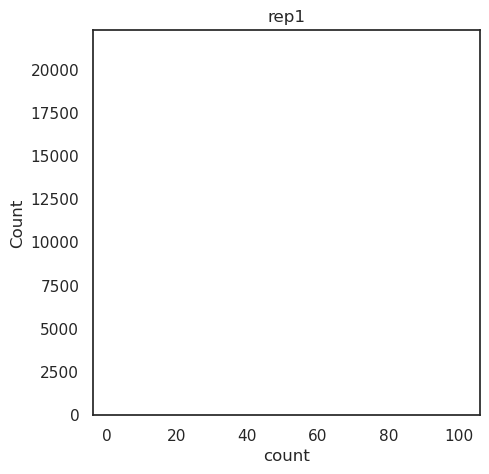

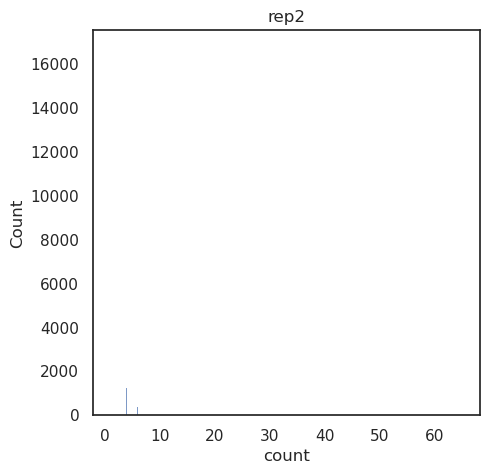

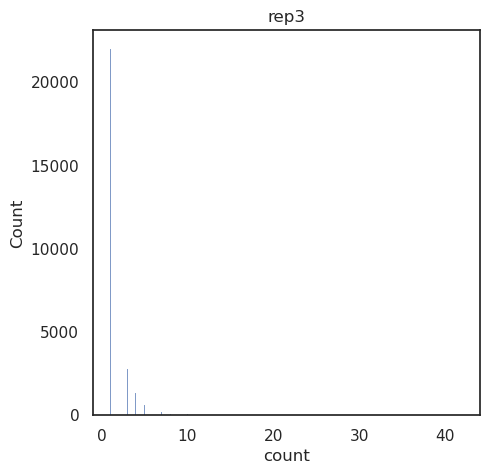

In [52]:
for rep in ['rep1', 'rep2', 'rep3']:
    read_edits_counts_rps2 = concat_edits_rps2[rep][concat_edits_rps2[rep]['key'].isin(all_pos_edits_rps2_common_all_rps2_snp_removed[rep]['key'].tolist())][3].value_counts()
    sns.histplot(read_edits_counts_rps2)
    plt.title(rep)
    plt.show()

In [53]:
for key in all_pos_edits_rps2:
    print(key, all_pos_edits_rps2[key].shape[0],all_pos_edits_rps2_common_removed[key].shape[0], all_pos_edits_rps2_common_all_rps2_removed[key].shape[0], all_pos_edits_rps2_common_all_rps2_snp_removed[key].shape[0])

rep1 51647 50592 50592 50069
rep2 41528 40504 40504 40073
rep3 45154 44099 44099 43536


In [54]:
for key in all_pos_edits_apo:
    print(key, all_pos_edits_apo[key].shape[0],all_pos_edits_apo_common_removed[key].shape[0], all_pos_edits_apo_common_all_rps2_removed[key].shape[0], all_pos_edits_apo_common_all_rps2_snp_removed[key].shape[0])

rep1 4848 3786 3786 3318
rep2 4490 3447 3447 3030
rep3 4213 3193 3193 2796


In [55]:
#all_pos_edits_apo_common_all_rps2_snp_removed['rep1'][[0,1,2,3,'key', 5]].to_csv(os.path.join('/home/pjaganna1/projects/bin/metaPlotR/script_pipeline/test_script', 'apo_test.bed'), sep='\t', header=None, index=False)
#all_pos_edits_rps2_common_all_rps2_snp_removed['rep1'][[0,1,2,3,'key', 5]].to_csv(os.path.join('/home/pjaganna1/projects/bin/metaPlotR/script_pipeline/test_script', 'rps2_test.bed'), sep='\t', header=None, index=False)

In [56]:
print('---APOBEC1---')
for rep in ['rep1', 'rep2', 'rep3']:
    print(all_pos_edits_apo_common_all_rps2_snp_removed[rep]['location'].value_counts())

print('---RPS2---')
for rep in ['rep1', 'rep2', 'rep3']:
    print(all_pos_edits_rps2_common_all_rps2_snp_removed[rep]['location'].value_counts())

---APOBEC1---
location
CDS    3318
Name: count, dtype: int64
location
CDS    3030
Name: count, dtype: int64
location
CDS    2796
Name: count, dtype: int64
---RPS2---
location
CDS    50069
Name: count, dtype: int64
location
CDS    40073
Name: count, dtype: int64
location
CDS    43536
Name: count, dtype: int64


In [57]:
# for rep in ['rep1', 'rep2', 'rep3']:
#     all_pos_edits_apo_common_all_rps2_snp_removed[rep][[0,1,2,3,4,5]].to_csv(os.path.join(output_dir, f'APO_pos_edits_iso_{rep}_commonsites_snp_filtered.bed'), sep='\t', header=None, index=False)

In [58]:
# for rep in ['rep1', 'rep2', 'rep3']:
#     all_pos_edits_rps2_common_all_rps2_snp_removed[rep][[0,1,2,3,4,5]].to_csv(os.path.join(output_dir, f'RPS2_pos_edits_iso_{rep}_commonsites_snp_filtered.bed'), sep='\t', header=None, index=False)

In [59]:
coverage_filtered_rps2 = {}
coverage_filtered_apo = {}
for rep in ['rep1', 'rep2', 'rep3']:
    coverage_filtered_rps2[rep] = all_pos_edits_rps2_common_all_rps2_snp_removed[rep][all_pos_edits_rps2_common_all_rps2_snp_removed[rep]['coverage'] >=20]
    coverage_filtered_apo[rep] = all_pos_edits_apo_common_all_rps2_snp_removed[rep][all_pos_edits_apo_common_all_rps2_snp_removed[rep]['coverage']>=20]

In [60]:
# for rep in ['rep1', 'rep2', 'rep3']:
#     coverage_filtered_apo[rep][[0,1,2,3,4,5]].to_csv(os.path.join(output_dir, f'APO_pos_edits_iso_{rep}_commonsites_snp_cov_filtered.bed'), sep='\t', header=None, index=False)

In [61]:
# for rep in ['rep1', 'rep2', 'rep3']:
#     coverage_filtered_rps2[rep][[0,1,2,3,4,5]].to_csv(os.path.join(output_dir, f'RPS2_pos_edits_iso_{rep}_commonsites_snp_cov_filtered.bed'), sep='\t', header=None, index=False)

In [62]:
keep_edits_apo = {}
for rep in ['rep1', 'rep2', 'rep3']:
    df_apo = all_pos_edits_apo_common_all_rps2_snp_removed[rep].copy()
    df_apo['gene_id'] = df_apo.apply(lambda x: x[3].split(':')[0], axis=1)
    df_apo['transcript_id'] = df_apo.apply(lambda x: x[3].split(':')[1], axis=1)
    #df_apo = df_apo[df_apo['coverage']>=20]
    keep_edits_apo[rep] = df_apo

In [63]:
keep_edits_rps2 = {}
for rep in ['rep1', 'rep2', 'rep3']:
    df_rps2 = all_pos_edits_rps2_common_all_rps2_snp_removed[rep].copy()
    df_rps2['gene_id'] = df_rps2.apply(lambda x: x[3].split(':')[0], axis=1)
    df_rps2['transcript_id'] = df_rps2.apply(lambda x: x[3].split(':')[1], axis=1)
    #df_rps2 = df_rps2[df_rps2['coverage']>=20]
    keep_edits_rps2[rep] = df_rps2

In [85]:
# for r in ['rep1', 'rep2', 'rep3']:
#     keep_edits_rps2[r][[0,1,2,3,4,5]].to_csv(os.path.join('/tscc/nfs/home/pjaganna1/projects/STAMP/LR-Ribo-STAMP_GEO_2024/processed_files', f'Ribo-STAMP_HEK293T_{r}_CDS_edits.bed'), sep='\t', header=None, index=False)
#     keep_edits_apo[r][[0,1,2,3,4,5]].to_csv(os.path.join('/tscc/nfs/home/pjaganna1/projects/STAMP/LR-Ribo-STAMP_GEO_2024/processed_files', f'APOBEC1-only_HEK293T_{r}_CDS_edits.bed'), sep='\t', header=None, index=False)

In [83]:
keep_edits_rps2['rep1']

0         1         2  \
0    chr4  83801997  83801998   
1    chr4  83800077  83800078   
2    chr4  83796933  83796934   
3    chr4  83795775  83795776   
4    chr4  83795867  83795868   
..    ...       ...       ...   
62  chr19    621216    621217   
63  chr19    621275    621276   
64  chr19   1440221   1440222   
65  chr19   9929262   9929263   
67  chr19  33078181  33078182   

                                                    3     4  5  \
0   ENSG00000138674.12:ENST00000395310.2:chr4:8380...  1,31  -   
1   ENSG00000138674.12:ENST00000395310.2:chr4:8380...  1,31  -   
2   ENSG00000138674.12:ENST00000395310.2:chr4:8379...  1,31  -   
3   ENSG00000138674.12:ENST00000395310.2:chr4:8379...  1,31  -   
4   ENSG00000138674.12:ENST00000395310.2:chr4:8379...  1,31  -   
..                                                ...   ... ..   
62  ENSG00000099821.9:ENST00000588649.2:chr19:6212...  1,24  -   
63  ENSG00000099821.9:ENST00000588649.2:chr19:6212...  1,24  -   
64  ENSG00000115268.5:ENST00000586686.2:chr19:1440...   1,5  +   
65  ENSG00000127452.4:ENST00000589626.1:chr19:9929...   1,1  -   
67  ENSG00000105185.7:ENST00000590247.2:chr19:3307...   1,5  +   

       split_label                      key location  conversion  coverage  \
0   split_bam_10_0   chr4:83801997:83801998      CDS           1        31   
1   split_bam_10_0   chr4:83800077:83800078      CDS           1        31   
2   split_bam_10_0   chr4:83796933:83796934      CDS           1        31   
3   split_bam_10_0   chr4:83795775:83795776      CDS           1        31   
4   split_bam_10_0   chr4:83795867:83795868      CDS           1        31   
..             ...                      ...      ...         ...       ...   
62  split_bam_1_85      chr19:621216:621217      CDS           1        24   
63  split_bam_1_85      chr19:621275:621276      CDS           1        24   
64  split_bam_1_85    chr19:1440221:1440222      CDS           1         5   
65  split_bam_1_85    chr19:9929262:9929263      CDS           1         1   
67  split_bam_1_85  chr19:33078181:33078182      CDS           1         5   

    edit_fraction             gene_id      transcript_id  
0        0.032258  ENSG00000138674.12  ENST00000395310.2  
1        0.032258  ENSG00000138674.12  ENST00000395310.2  
2        0.032258  ENSG00000138674.12  ENST00000395310.2  
3        0.032258  ENSG00000138674.12  ENST00000395310.2  
4        0.032258  ENSG00000138674.12  ENST00000395310.2  
..            ...                 ...                ...  
62       0.041667   ENSG00000099821.9  ENST00000588649.2  
63       0.041667   ENSG00000099821.9  ENST00000588649.2  
64       0.200000   ENSG00000115268.5  ENST00000586686.2  
65       1.000000   ENSG00000127452.4  ENST00000589626.1  
67       0.200000   ENSG00000105185.7  ENST00000590247.2  

[50069 rows x 14 columns]

In [64]:
total_mapped_reads

{'RPS2_1': 382261,
 'APO1_1': 329206,
 'RPS2_2': 293649,
 'APO1_2': 300241,
 'RPS2_3': 319713,
 'APO1_3': 252245}

In [65]:
mapped_edits = []
for sample_dict in [['apo', sample_dict_apo], ['rps2',sample_dict_rps2]]:
    s = sample_dict[0]
    d = sample_dict[1]
    for r in ['rep1', 'rep2', 'rep3']:
        if s=='apo':
            mapped_edits.append([d[r], total_mapped_reads[d[r]], 'mapped reads'])
            mapped_edits.append([d[r], keep_edits_apo[r].shape[0], 'edits'])
        elif s=='rps2':
            mapped_edits.append([d[r], total_mapped_reads[d[r]], 'mapped reads'])
            mapped_edits.append([d[r], keep_edits_rps2[r].shape[0], 'edits'])
                                
    

In [66]:
mapped_edits_df = pd.DataFrame(mapped_edits, columns=['sample', 'counts', 'metric'])

/tmp/ipykernel_3512409/1761170518.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.barplot(data=mapped_edits_df, x='sample', y='counts', hue='metric', palette=custom_palette[2:])


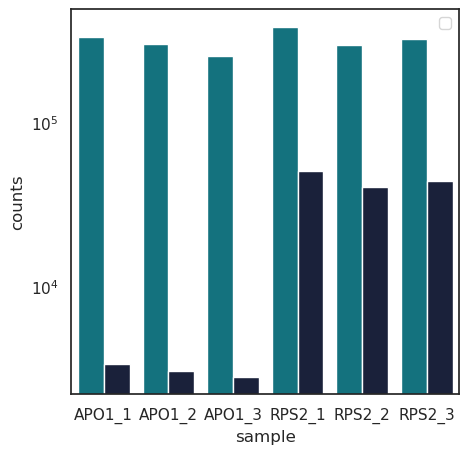

In [67]:
sns.barplot(data=mapped_edits_df, x='sample', y='counts', hue='metric', palette=custom_palette[2:])
plt.yscale('log')
plt.legend([])
# plt.savefig(os.path.join(fig_path,'sup1/sup1_A.png'))
# plt.savefig(os.path.join(fig_path,'sup1/sup1_A.svg'))
# plt.savefig(os.path.join(fig_path,'sup1/sup1_A.jpg'))


### Getting Exon and UTRs gene and Transcript (Don't need to re-run unless creating files again')

In [68]:
def gtf_to_bed(gtf_file, bed_file):
    # Read the GTF file
    # GTF columns: chromosome, source, feature, start, end, score, strand, frame, attribute
    gtf_df = pd.read_csv(gtf_file, sep='\t', comment='#', header=None,
                     names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
    # Filter for exons and UTRs
    gtf_df = gtf_df[gtf_df['feature'].isin(['exon', 'UTR'])]

    # Extract gene name from the attribute field
    gtf_df['gene_name'] = gtf_df['attribute'].str.extract('gene_id "([^"]+)"')

    # Create a BED formatted DataFrame
    bed_df = gtf_df[['chrom', 'start', 'end', 'gene_name', 'score', 'strand']]

    # Adjust start position for BED format (0-based start, GTF is 1-based)
    bed_df['start'] = bed_df['start'] - 1

    # Write to BED file
    bed_df.to_csv(bed_file, sep='\t', index=False, header=False)

In [69]:
gtf_file = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/gencode.v19.annotation.gtf'  # Replace with your GTF file path
#bed_file = '/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/output_exons_utrs.bed'
#gtf_to_bed(gtf_file, bed_file)

```sort -k1,1 -k2,2n output_exons_utrs.bed > output_exons_utrs.sorted.bed```

```bedtools merge -i output_exons_utrs.genes.sorted.bed -s -c 4,6 -o distinct > merged_exons_utrs.genes.hg19.bed``` 

```bedtools getfasta -fi hg19.fa -bed merged_exons_utrs.genes.hg19.bed -name -s > merged_exons_utrs.genes.hg19.fasta```

In [70]:
def count_cytosines(fasta_file):
    cytosine_counts = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_ids = record.id.split(":")[0].split(',')  # Adjust based on your FASTA header format
        sequence = str(record.seq).upper()
        for gene_id in gene_ids:
            if gene_id in cytosine_counts:
                cytosine_counts[gene_id] += sequence.count('C')
            else:
                cytosine_counts[gene_id] = sequence.count('C')
    return cytosine_counts

In [71]:
gene_coordinates_fasta = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/merged_exons_utrs.genes.hg19.fasta'

In [72]:
gene_cytosine_counts = count_cytosines(gene_coordinates_fasta)

In [73]:
def gtf_to_bed_transcript(gtf_file, bed_file):
    # Read the GTF file
    # GTF columns: chromosome, source, feature, start, end, score, strand, frame, attribute
    gtf_df = pd.read_csv(gtf_file, sep='\t', comment='#', header=None,
                     names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
    # Filter for exons and UTRs
    gtf_df = gtf_df[gtf_df['feature'].isin(['exon', 'UTR'])]

    # Extract gene name from the attribute field
    gtf_df['transcript_id'] = gtf_df['attribute'].str.extract('transcript_id "([^"]+)"')

    # Create a BED formatted DataFrame
    bed_df = gtf_df[['chrom', 'start', 'end', 'transcript_id', 'score', 'strand']]

    # Adjust start position for BED format (0-based start, GTF is 1-based)
    bed_df['start'] = bed_df['start'] - 1

    # Write to BED file
    bed_df.to_csv(bed_file, sep='\t', index=False, header=False)

In [74]:
transcript_bed_file = '/tscc/nfs//home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/output_exons_utrs.transcript.bed'
#gtf_to_bed_transcript(gtf_file, transcript_bed_file)

```sort -k1,1 -k2,2n output_exons_utrs.transcript.bed > output_exons_utrs.transcript.sorted.bed```

```bedtools merge -i output_exons_utrs.transcript.sorted.bed -s -c 4,6 -o distinct > merged_exons_utrs.transcript.hg19.bed```

```bedtools getfasta -fi hg19.fa -bed merged_exons_utrs.transcript.hg19.bed -name -s > merged_exons_utrs.transcript.hg19.fasta```

In [75]:
def count_cytosines_transcript(fasta_file):
    cytosine_counts = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        ids = record.id.split(":")[0].split(',')  # Adjust based on your FASTA header format
        sequence = str(record.seq).upper()
        for transcript in ids:
            if transcript in cytosine_counts:
                cytosine_counts[transcript] += sequence.count('C')
            else:
                cytosine_counts[transcript] = sequence.count('C')
    return cytosine_counts

In [76]:
transcript_coordinates_fasta = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/merged_exons_utrs.transcript.hg19.fasta'

In [77]:
transcript_cytosine_counts = count_cytosines_transcript(transcript_coordinates_fasta)

In [78]:
def calculate_editsC(keep_edits, c_counts):
    gene_editsC = {}
    for rep in ['rep1', 'rep2', 'rep3']:
        edit_count_gene = keep_edits[rep].drop_duplicates(subset=[0,1,2,5, 'gene_id']).groupby('gene_id').count()[[0]]
        edit_count_gene['num_c'] = edit_count_gene.index.map(c_counts)
        edit_count_gene = edit_count_gene.rename(columns={0:'edited_c'})
        edit_count_gene['editsC'] = edit_count_gene['edited_c']/edit_count_gene['num_c']
        gene_editsC[rep] = edit_count_gene
    return gene_editsC

In [79]:
apo_gene_editsC = calculate_editsC(keep_edits_apo, gene_cytosine_counts)

In [80]:
rps2_gene_editsC = calculate_editsC(keep_edits_rps2, gene_cytosine_counts)

In [81]:
def calculate_editsC_transcript(keep_edits, c_counts):
    transcript_editsC = {}
    for rep in ['rep1', 'rep2', 'rep3']:
        edit_count_transcript = keep_edits[rep].groupby('transcript_id').count()[[0]]
        edit_count_transcript['num_c'] = edit_count_transcript.index.map(c_counts)
        edit_count_transcript = edit_count_transcript.rename(columns={0:'edited_c'})
        edit_count_transcript['editsC'] = edit_count_transcript['edited_c']/edit_count_transcript['num_c']
        transcript_editsC[rep] = edit_count_transcript
    return transcript_editsC

In [82]:
apo_transcript_editsC = calculate_editsC_transcript(keep_edits_apo, transcript_cytosine_counts)
rps2_transcript_editsC = calculate_editsC_transcript(keep_edits_rps2, transcript_cytosine_counts)

In [83]:
def make_heatmap(apo_dict, rps2_dict, fileout):
    editsC_heatmap = pd.DataFrame()
    for sample, d in [('APO', apo_dict), ('RPS2', rps2_dict)]:
        for rep in ['rep1', 'rep2', 'rep3']:
            d[rep] = d[rep].rename(columns={'editsC' : f'editsC_{sample}_{rep}'})
            editsC_heatmap = pd.concat([editsC_heatmap, d[rep][[f'editsC_{sample}_{rep}']]], axis=1)
    sns.clustermap(editsC_heatmap.dropna(), cmap='mako_r')
    # plt.savefig(os.path.join(fig_path,f'{fileout}.png'))
    # plt.savefig(os.path.join(fig_path,f'{fileout}.svg'))
    # plt.savefig(os.path.join(fig_path,f'{fileout}.jpg'))
    plt.show()
    return editsC_heatmap

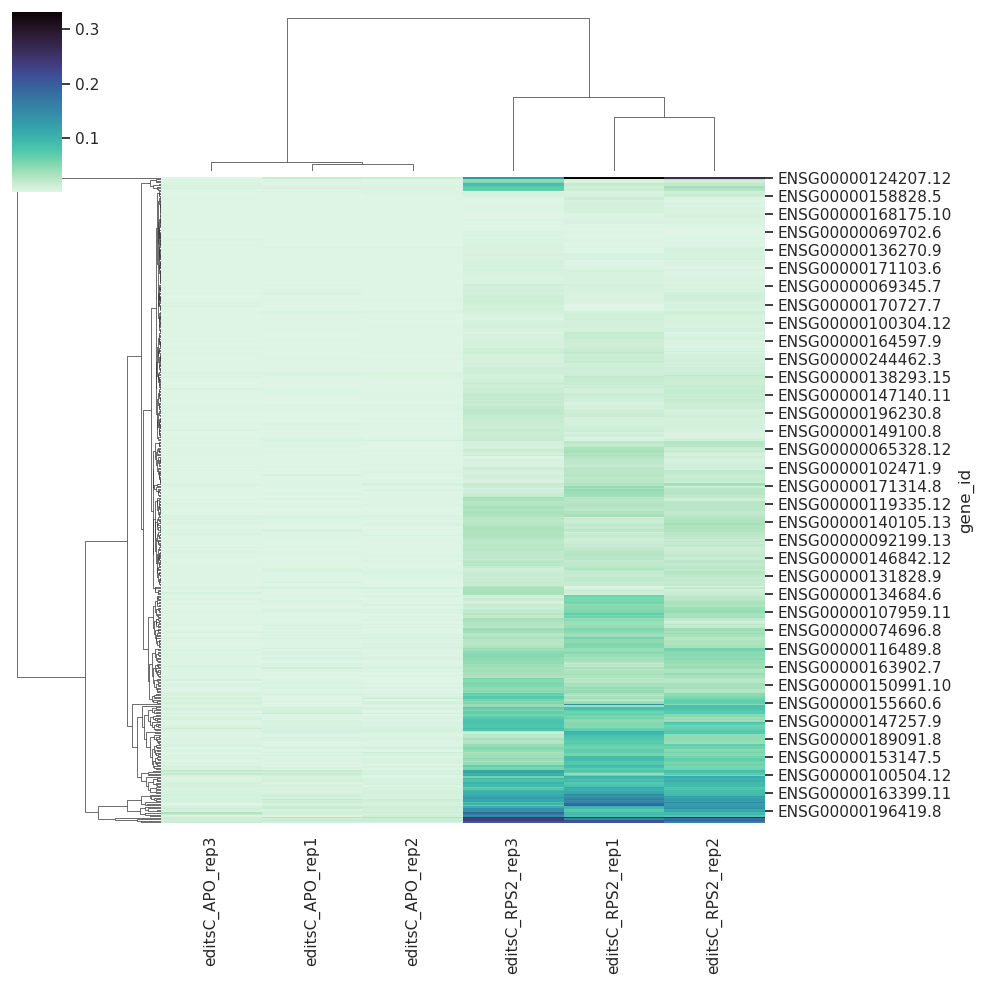

In [84]:
gene_editsC = make_heatmap(apo_gene_editsC, rps2_gene_editsC, 'fig2/gene_editsC_heatmap')

In [130]:
len(set(gene_editsC.dropna().index))

428

In [85]:
gene_editsC.dropna().head()

editsC_APO_rep1  editsC_APO_rep2  editsC_APO_rep3  \
gene_id                                                                 
ENSG00000004455.12         0.000770         0.000770         0.000770   
ENSG00000004478.5          0.000934         0.000934         0.001867   
ENSG00000005022.5          0.005464         0.002732         0.005464   
ENSG00000006652.9          0.000781         0.000781         0.000781   
ENSG00000006715.11         0.000595         0.000595         0.001784   

                    editsC_RPS2_rep1  editsC_RPS2_rep2  editsC_RPS2_rep3  
gene_id                                                                   
ENSG00000004455.12          0.011556          0.011556          0.011556  
ENSG00000004478.5           0.016807          0.017740          0.016807  
ENSG00000005022.5           0.013661          0.030055          0.068306  
ENSG00000006652.9           0.007031          0.007031          0.014844  
ENSG00000006715.11          0.020809          0.011296          0.004756

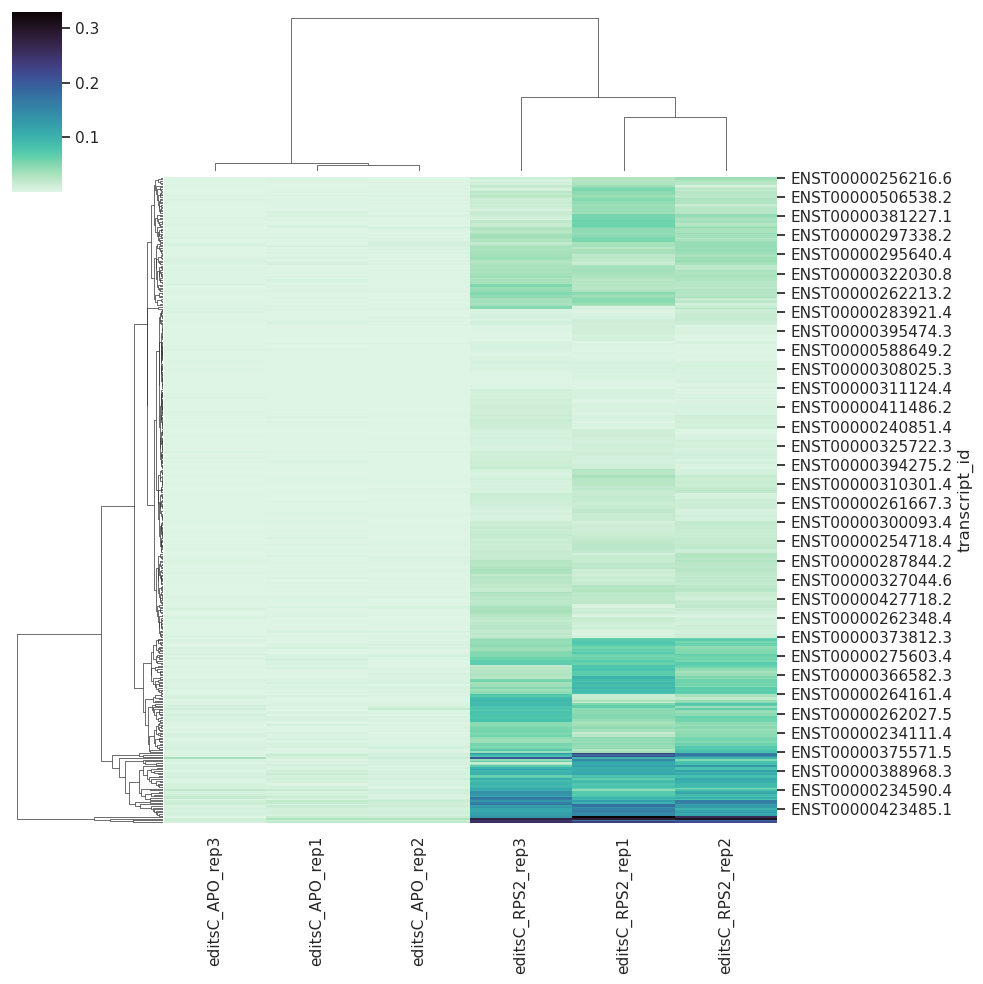

In [86]:
transcript_editsC = make_heatmap(apo_transcript_editsC, rps2_transcript_editsC,'fig3/transcript_editsC_heatmap')

In [87]:
transcript_editsC.dropna().head()

editsC_APO_rep1  editsC_APO_rep2  editsC_APO_rep3  \
transcript_id                                                          
ENST00000001008.4         0.001520         0.001520         0.003040   
ENST00000199389.6         0.004314         0.001726         0.001726   
ENST00000200135.3         0.001460         0.001460         0.001460   
ENST00000209728.4         0.002809         0.002809         0.004213   
ENST00000212355.4         0.000649         0.001298         0.001298   

                   editsC_RPS2_rep1  editsC_RPS2_rep2  editsC_RPS2_rep3  
transcript_id                                                            
ENST00000001008.4          0.027356          0.028875          0.027356  
ENST00000199389.6          0.028473          0.026747          0.034513  
ENST00000200135.3          0.037956          0.008759          0.032117  
ENST00000209728.4          0.019663          0.011236          0.022472  
ENST00000212355.4          0.003245          0.001298          0.003894

In [133]:
len(set(transcript_editsC.dropna().index))

405

In [88]:
def parse_gtf(gtf_file_path):
    # Read GTF file, skipping header lines starting with '#'
    df_gtf = pd.read_csv(gtf_file_path, sep='\t', comment='#', header=None, names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])

    # Filter for gene features
    df_gtf = df_gtf[df_gtf['feature'] == 'gene']

    # Extract gene ID, gene name, and gene type from the 'attribute' column
    df_gtf['gene_id'] = df_gtf['attribute'].str.extract('gene_id "([^"]+)"')
    df_gtf['gene_name'] = df_gtf['attribute'].str.extract('gene_name "([^"]+)"')
    df_gtf['gene_type'] = df_gtf['attribute'].str.extract('gene_type "([^"]+)"')

    # Create a new DataFrame with just the gene ID, gene name, and gene type
    df_genes = df_gtf[['gene_id', 'gene_name', 'gene_type']].set_index('gene_id')

    return df_genes

def annotate_dataframe(gene_editsC_df, gtf_file_path):
    # Parse the GTF file
    df_genes_annotations = parse_gtf(gtf_file_path)

    # Merge with the existing DataFrame
    annotated_df = gene_editsC_df.merge(df_genes_annotations, left_index=True, right_index=True, how='left')

    return annotated_df

In [89]:
def parse_gtf_for_transcripts(gtf_file_path):
    # Read GTF file, skipping header lines starting with '#'
    df_gtf = pd.read_csv(gtf_file_path, sep='\t', comment='#', header=None,names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])

    # Filter for transcript features
    df_gtf = df_gtf[df_gtf['feature'] == 'transcript']

    # Extract transcript ID, gene name, and transcript type from the 'attribute' column
    df_gtf['transcript_id'] = df_gtf['attribute'].str.extract('transcript_id "([^"]+)"')
    df_gtf['gene_name'] = df_gtf['attribute'].str.extract('gene_name "([^"]+)"')
    df_gtf['transcript_type'] = df_gtf['attribute'].str.extract('transcript_type "([^"]+)"')

    # Create a new DataFrame with just the transcript ID, gene name, and transcript type
    df_transcripts = df_gtf[['transcript_id', 'gene_name', 'transcript_type']].set_index('transcript_id')

    return df_transcripts

def annotate_dataframe_with_transcript_info(transcript_editsC_df, gtf_file_path):
    # Parse the GTF file for transcripts
    df_transcripts = parse_gtf_for_transcripts(gtf_file_path)

    # Merge with the existing DataFrame
    annotated_df = transcript_editsC_df.merge(df_transcripts, left_index=True, right_index=True, how='left')

    return annotated_df

In [90]:
def calculate_mean_apo(data):
    return np.mean([data['editsC_APO_rep1'], data['editsC_APO_rep2'], data['editsC_APO_rep3']])

def calculate_mean_rps2(data):
    return np.mean([data['editsC_RPS2_rep1'], data['editsC_RPS2_rep2'], data['editsC_RPS2_rep3']])

In [91]:
annotated_gene_editsC = annotate_dataframe(gene_editsC, gtf_file)

In [92]:
annotated_gene_editsC['ensembl_gene_id'] = annotated_gene_editsC.apply(lambda x: x.name.split('.')[0], axis=1)

In [93]:
annotated_gene_editsC.dropna().head()

editsC_APO_rep1  editsC_APO_rep2  editsC_APO_rep3  \
gene_id                                                                 
ENSG00000004455.12         0.000770         0.000770         0.000770   
ENSG00000004478.5          0.000934         0.000934         0.001867   
ENSG00000005022.5          0.005464         0.002732         0.005464   
ENSG00000006652.9          0.000781         0.000781         0.000781   
ENSG00000006715.11         0.000595         0.000595         0.001784   

                    editsC_RPS2_rep1  editsC_RPS2_rep2  editsC_RPS2_rep3  \
gene_id                                                                    
ENSG00000004455.12          0.011556          0.011556          0.011556   
ENSG00000004478.5           0.016807          0.017740          0.016807   
ENSG00000005022.5           0.013661          0.030055          0.068306   
ENSG00000006652.9           0.007031          0.007031          0.014844   
ENSG00000006715.11          0.020809          0.011296          0.004756   

                   gene_name       gene_type  ensembl_gene_id  
gene_id                                                        
ENSG00000004455.12       AK2  protein_coding  ENSG00000004455  
ENSG00000004478.5      FKBP4  protein_coding  ENSG00000004478  
ENSG00000005022.5    SLC25A5  protein_coding  ENSG00000005022  
ENSG00000006652.9      IFRD1  protein_coding  ENSG00000006652  
ENSG00000006715.11     VPS41  protein_coding  ENSG00000006715

In [94]:
annotated_gene_editsC['gene_type'].value_counts()

gene_type
protein_coding    7004
Name: count, dtype: int64

In [95]:
annotated_gene_editsC.dropna().head()

editsC_APO_rep1  editsC_APO_rep2  editsC_APO_rep3  \
gene_id                                                                 
ENSG00000004455.12         0.000770         0.000770         0.000770   
ENSG00000004478.5          0.000934         0.000934         0.001867   
ENSG00000005022.5          0.005464         0.002732         0.005464   
ENSG00000006652.9          0.000781         0.000781         0.000781   
ENSG00000006715.11         0.000595         0.000595         0.001784   

                    editsC_RPS2_rep1  editsC_RPS2_rep2  editsC_RPS2_rep3  \
gene_id                                                                    
ENSG00000004455.12          0.011556          0.011556          0.011556   
ENSG00000004478.5           0.016807          0.017740          0.016807   
ENSG00000005022.5           0.013661          0.030055          0.068306   
ENSG00000006652.9           0.007031          0.007031          0.014844   
ENSG00000006715.11          0.020809          0.011296          0.004756   

                   gene_name       gene_type  ensembl_gene_id  
gene_id                                                        
ENSG00000004455.12       AK2  protein_coding  ENSG00000004455  
ENSG00000004478.5      FKBP4  protein_coding  ENSG00000004478  
ENSG00000005022.5    SLC25A5  protein_coding  ENSG00000005022  
ENSG00000006652.9      IFRD1  protein_coding  ENSG00000006652  
ENSG00000006715.11     VPS41  protein_coding  ENSG00000006715

In [96]:
def epkm(kept_edits, total_mapped,r):
    """
    Just like "RPKM" except we're looking at the number of edits (edit_counts).
    edit_counts = total number of edit conversions across a genic region (all exons, or 3'UTR+CDS, or CDS)
    If a read contains multiple C>T conversions, we end up counting it multiple times. Perhaps that's okay?
    """
    gene_epkm_edit_count = kept_edits.drop_duplicates(subset=[0,1,2,5, 'gene_id']).groupby('gene_id').count()[[0]].reset_index()
    gene_epkm_edit_count = gene_epkm_edit_count.rename(columns={0:f'edit_count_{r}'})
    gene_epkm_edit_count['length'] = gene_epkm_edit_count.gene_id.map(gene_length_dict)
    gene_epkm_edit_count[f'epkm_{r}'] =  gene_epkm_edit_count.apply(lambda x: x[f'edit_count_{r}']/((total_mapped/1000000.)*(x['length']/1000.)), axis=1)
    return gene_epkm_edit_count

In [97]:
def calculate_mean_epkm_apo(data):
    return np.mean([data['epkm_rep1_apo'], data['epkm_rep2_apo'], data['epkm_rep3_apo']])

def calculate_mean_epkm_rps2(data):
    return np.mean([data['epkm_rep1_rps2'], data['epkm_rep2_rps2'], data['epkm_rep3_rps2']])

In [98]:
rps2_epkm = {}
apo_epkm = {}
for rep in ['rep1', 'rep2', 'rep3']:
    apo_epkm[rep] = epkm(keep_edits_apo[rep], total_mapped_reads[sample_dict_apo[rep]], rep)
    rps2_epkm[rep] = epkm(keep_edits_rps2[rep], total_mapped_reads[sample_dict_rps2[rep]], rep)

In [99]:
rps2_epkm_all = pd.concat([rps2_epkm['rep1'].set_index('gene_id'), rps2_epkm['rep2'].set_index('gene_id'), rps2_epkm['rep3'].set_index('gene_id')], axis=1)[['edit_count_rep1', 'edit_count_rep2', 'edit_count_rep3', 'epkm_rep1', 'epkm_rep2', 'epkm_rep3']]

In [100]:
rps2_epkm_all.head()

edit_count_rep1  edit_count_rep2  edit_count_rep3  \
gene_id                                                                 
ENSG00000000003.10              2.0              9.0             17.0   
ENSG00000000460.12              3.0              NaN              1.0   
ENSG00000001036.9               3.0             12.0             15.0   
ENSG00000001167.10              2.0              NaN              NaN   
ENSG00000001460.13              2.0              1.0              1.0   

                    epkm_rep1  epkm_rep2  epkm_rep3  
gene_id                                              
ENSG00000000003.10   0.462112   2.707016   4.696404  
ENSG00000000460.12   0.040880        NaN   0.016293  
ENSG00000001036.9    0.464931   2.420919   2.779448  
ENSG00000001167.10   0.193549        NaN        NaN  
ENSG00000001460.13   0.087294   0.056818   0.052186

In [101]:
apo_epkm_all = pd.concat([apo_epkm['rep1'].set_index('gene_id'), apo_epkm['rep2'].set_index('gene_id'), apo_epkm['rep3'].set_index('gene_id')], axis=1)[['edit_count_rep1', 'edit_count_rep2', 'edit_count_rep3', 'epkm_rep1', 'epkm_rep2', 'epkm_rep3']]

In [102]:
gene_epkm = apo_epkm_all.merge(rps2_epkm_all, left_index=True, right_index=True, suffixes=['_apo', '_rps2'])

In [103]:
annotated_gene_epkm = annotate_dataframe(gene_epkm, gtf_file)

In [104]:
annotated_gene_epkm.dropna().head()

edit_count_rep1_apo  edit_count_rep2_apo  \
gene_id                                                        
ENSG00000004455.12                  1.0                  1.0   
ENSG00000004478.5                   1.0                  1.0   
ENSG00000005022.5                   2.0                  1.0   
ENSG00000006652.9                   1.0                  1.0   
ENSG00000006715.11                  1.0                  1.0   

                    edit_count_rep3_apo  epkm_rep1_apo  epkm_rep2_apo  \
gene_id                                                                 
ENSG00000004455.12                  1.0       0.041604       0.045617   
ENSG00000004478.5                   2.0       0.290458       0.318479   
ENSG00000005022.5                   2.0       2.080556       1.140636   
ENSG00000006652.9                   1.0       0.052328       0.057376   
ENSG00000006715.11                  3.0       0.014504       0.015903   

                    epkm_rep3_apo  edit_count_rep1_rps2  edit_count_rep2_rps2  \
gene_id                                                                         
ENSG00000004455.12       0.054297                  15.0                  15.0   
ENSG00000004478.5        0.758156                  18.0                  19.0   
ENSG00000005022.5        2.715342                   5.0                  11.0   
ENSG00000006652.9        0.068293                   9.0                   9.0   
ENSG00000006715.11       0.056788                  35.0                  19.0   

                    edit_count_rep3_rps2  epkm_rep1_rps2  epkm_rep2_rps2  \
gene_id                                                                    
ENSG00000004455.12                  15.0        0.537441        0.699621   
ENSG00000004478.5                   18.0        4.502605        6.186948   
ENSG00000005022.5                   25.0        4.479475       12.828660   
ENSG00000006652.9                   19.0        0.405584        0.527973   
ENSG00000006715.11                   8.0        0.437185        0.308946   

                    epkm_rep3_rps2 gene_name       gene_type  
gene_id                                                       
ENSG00000004455.12        0.642585       AK2  protein_coding  
ENSG00000004478.5         5.383486     FKBP4  protein_coding  
ENSG00000005022.5        26.779155   SLC25A5  protein_coding  
ENSG00000006652.9         1.023743     IFRD1  protein_coding  
ENSG00000006715.11        0.119478     VPS41  protein_coding

In [105]:
annotated_gene_editsC_copy = annotated_gene_editsC.copy()
annotated_gene_epkm_copy = annotated_gene_epkm.copy()

In [106]:
for key in gene_counts:
    annotated_gene_editsC_copy = pd.concat([annotated_gene_editsC_copy, gene_counts[key].set_index('Geneid')], axis=1)
    annotated_gene_epkm_copy = pd.concat([annotated_gene_epkm_copy, gene_counts[key].set_index('Geneid')], axis=1)

In [107]:
annotated_gene_epkm_copy.head()

edit_count_rep1_apo  edit_count_rep2_apo  \
ENSG00000000003.10                  1.0                  NaN   
ENSG00000001036.9                   2.0                  1.0   
ENSG00000001084.6                   2.0                  NaN   
ENSG00000001497.12                  2.0                  1.0   
ENSG00000003056.3                   1.0                  NaN   

                    edit_count_rep3_apo  epkm_rep1_apo  epkm_rep2_apo  \
ENSG00000000003.10                  2.0       0.268293            NaN   
ENSG00000001036.9                   NaN       0.359907       0.197314   
ENSG00000001084.6                   NaN       0.050783            NaN   
ENSG00000001497.12                  NaN       0.273733       0.150070   
ENSG00000003056.3                   NaN       0.316649            NaN   

                    epkm_rep3_apo  edit_count_rep1_rps2  edit_count_rep2_rps2  \
ENSG00000000003.10         0.7003                   2.0                   9.0   
ENSG00000001036.9             NaN                   3.0                  12.0   
ENSG00000001084.6             NaN                   NaN                   2.0   
ENSG00000001497.12            NaN                  13.0                  23.0   
ENSG00000003056.3             NaN                   4.0                   6.0   

                    edit_count_rep3_rps2  epkm_rep1_rps2  ...  APO1_2_RPKM  \
ENSG00000000003.10                  17.0        0.462112  ...    25.865897   
ENSG00000001036.9                   15.0        0.464931  ...    16.138746   
ENSG00000001084.6                    2.0             NaN  ...          NaN   
ENSG00000001497.12                  31.0        1.532314  ...    12.274580   
ENSG00000003056.3                    1.0        1.090801  ...    18.458702   

                    RPS2_2    Length RPS2_2_RPKM  APO1_3   Length  \
ENSG00000000003.10    28.0   11322.0   17.551018    42.0  11322.0   
ENSG00000001036.9     30.0   16880.0   12.612938    46.0  16880.0   
ENSG00000001084.6     22.0  119630.0    1.305119     NaN      NaN   
ENSG00000001497.12    44.0   22194.0   14.069690    40.0  22194.0   
ENSG00000003056.3     31.0    9593.0   22.933729    35.0   9593.0   

                    APO1_3_RPKM  RPS2_3   Length  RPS2_3_RPKM  
ENSG00000000003.10    30.987378    76.0  11322.0    41.496736  
ENSG00000001036.9     22.763764    63.0  16880.0    23.072338  
ENSG00000001084.6           NaN     NaN      NaN          NaN  
ENSG00000001497.12    15.055081    58.0  22194.0    16.155333  
ENSG00000003056.3     30.477005    35.0   9593.0    22.554702  

[5 rows x 32 columns]

In [108]:
def add_zero_edits(df, metric):
    if metric =='editsC':
        for rep in ['1', '2', '3']:
            df.loc[~df[f'APO1_{rep}'].isna() & df[f'editsC_APO_rep{rep}'].isna(), f'editsC_APO_rep{rep}'] = 0
            df.loc[~df[f'RPS2_{rep}'].isna()& df[f'editsC_RPS2_rep{rep}'].isna(), f'editsC_RPS2_rep{rep}'] = 0
    elif metric=='epkm':
        for rep in ['1', '2', '3']:
            df.loc[~df[f'APO1_{rep}'].isna() & df[f'epkm_rep{rep}_apo'].isna(), f'epkm_rep{rep}_apo'] = 0
            df.loc[~df[f'RPS2_{rep}'].isna()& df[f'epkm_rep{rep}_rps2'].isna(), f'epkm_rep{rep}_rps2'] = 0  
        
    return df

In [109]:
annotated_gene_editsC_copy=add_zero_edits(annotated_gene_editsC_copy, 'editsC')

In [110]:
annotated_gene_editsC_copy['APO_mean'] = annotated_gene_editsC_copy.apply(calculate_mean_apo, axis=1)
annotated_gene_editsC_copy['RPS2_mean'] = annotated_gene_editsC_copy.apply(calculate_mean_rps2, axis=1)

In [111]:
annotated_gene_epkm_copy=add_zero_edits(annotated_gene_epkm_copy, 'epkm')

In [112]:
annotated_gene_epkm_copy['APO_epkm_mean'] = annotated_gene_epkm_copy.apply(calculate_mean_epkm_apo, axis=1)
annotated_gene_epkm_copy['RPS2_epkm_mean'] = annotated_gene_epkm_copy.apply(calculate_mean_epkm_rps2, axis=1)

In [195]:
#annotated_gene_editsC_copy[['editsC_APO_rep1', 'editsC_APO_rep2', 'editsC_APO_rep3', 'editsC_RPS2_rep1', 'editsC_RPS2_rep2', 'editsC_RPS2_rep3', 'APO1_1', 'APO1_2', 'APO1_3', 'RPS2_1', 'RPS2_2', 'RPS2_3']]


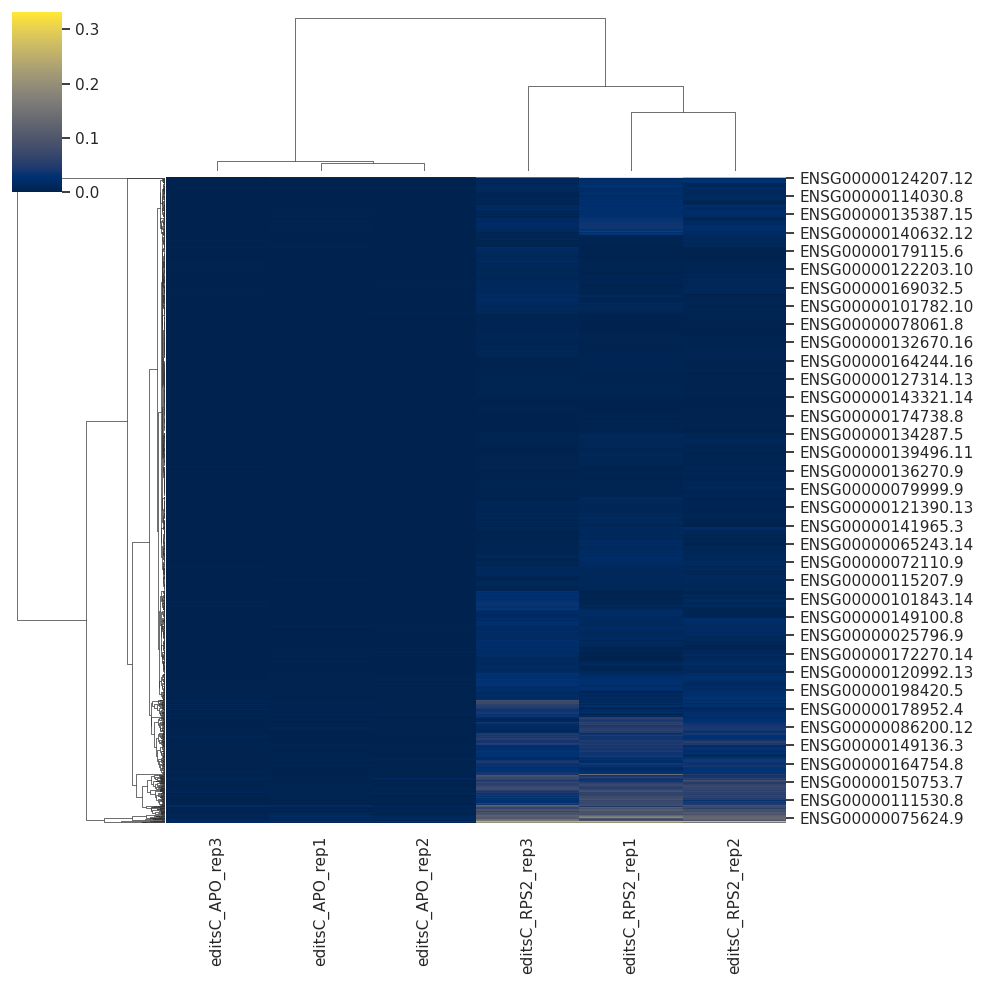

In [113]:
sns.clustermap(annotated_gene_editsC_copy[[i for i in annotated_gene_editsC_copy.columns if (('APO' in i) or ('RPS2' in i)) and ('editsC' in i) and ('rep' in i)]].dropna(), cmap='cividis')

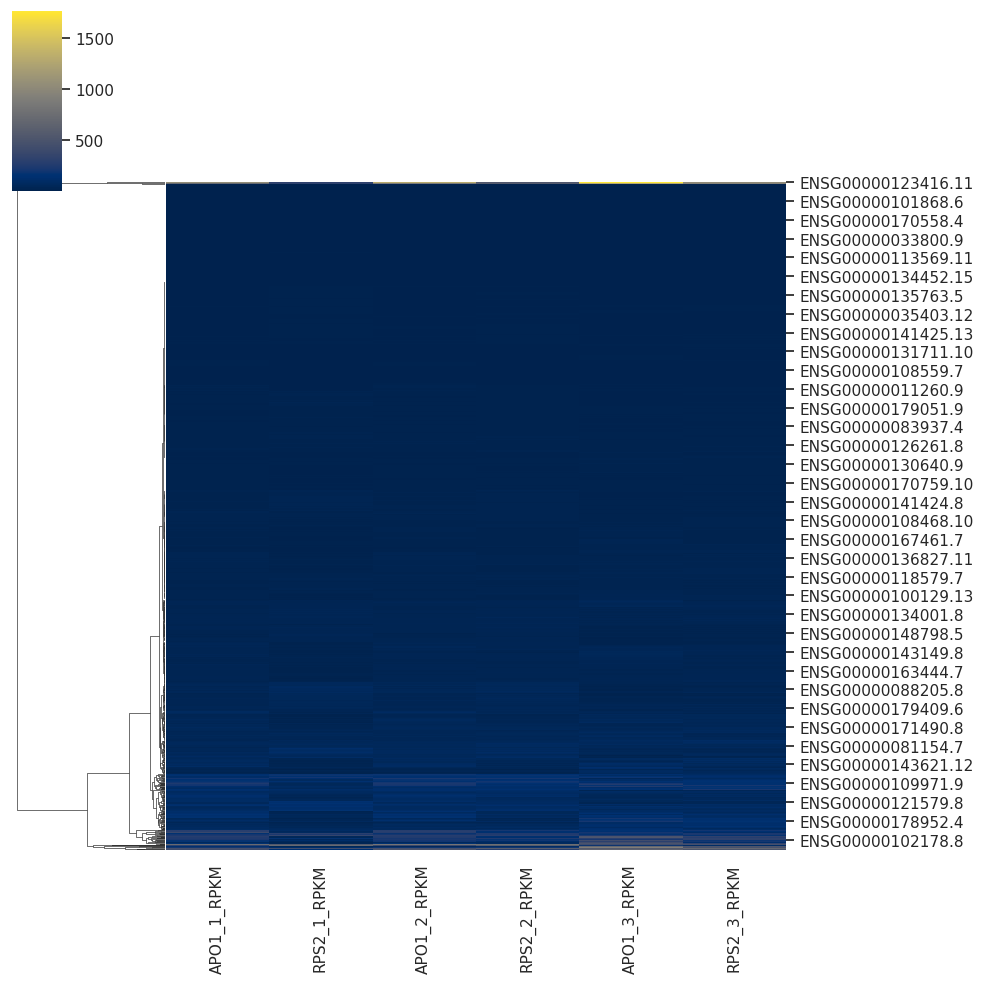

In [114]:
sns.clustermap(annotated_gene_editsC_copy[[i for i in annotated_gene_editsC_copy.columns if (('APO' in i) or ('RPS2' in i)) and ('RPKM' in i)]].dropna(), cmap='cividis', col_cluster=False)

In [115]:
annotated_gene_editsC_copy['APO_RPKM_mean'] = annotated_gene_editsC_copy.apply(lambda x: np.mean([x['APO1_1_RPKM'], x['APO1_2_RPKM'], x['APO1_3_RPKM']]), axis=1)
annotated_gene_editsC_copy['RPS2_RPKM_mean']= annotated_gene_editsC_copy.apply(lambda x: np.mean([x['RPS2_1_RPKM'], x['RPS2_2_RPKM'], x['RPS2_3_RPKM']]), axis=1)

In [116]:
annotated_gene_epkm_copy['APO_RPKM_mean'] = annotated_gene_epkm_copy.apply(lambda x: np.mean([x['APO1_1_RPKM'], x['APO1_2_RPKM'], x['APO1_3_RPKM']]), axis=1)
annotated_gene_epkm_copy['RPS2_RPKM_mean']= annotated_gene_epkm_copy.apply(lambda x: np.mean([x['RPS2_1_RPKM'], x['RPS2_2_RPKM'], x['RPS2_3_RPKM']]), axis=1)

In [117]:
#annotated_gene_editsC_copy['RPS2_editsC/APO_editsC'] = annotated_gene_editsC_copy['RPS2_mean']/annotated_gene_editsC_copy['APO_mean']

In [118]:
#annotated_gene_epkm_copy['RPS2_epkm/APO_epkm'] = annotated_gene_epkm_copy['RPS2_epkm_mean']/annotated_gene_epkm_copy['APO_epkm_mean']

In [119]:
annotated_gene_editsC_copy['RPS2_editsC/RPS2_RPKM_mean'] = annotated_gene_editsC_copy['RPS2_mean']/annotated_gene_editsC_copy['RPS2_RPKM_mean']
annotated_gene_editsC_copy['APO_editsC/APO_RPKM_mean'] = annotated_gene_editsC_copy['APO_mean']/annotated_gene_editsC_copy['APO_RPKM_mean']

In [120]:
annotated_gene_epkm_copy['RPS2_epkm/RPS2_RPKM_mean'] = annotated_gene_epkm_copy['RPS2_epkm_mean']/annotated_gene_epkm_copy['RPS2_RPKM_mean']
annotated_gene_epkm_copy['APO_epkm/APO_RPKM_mean'] = annotated_gene_epkm_copy['APO_epkm_mean']/annotated_gene_epkm_copy['APO_RPKM_mean']

In [121]:
#annotated_gene_editsC_copy[['gene_name', 'editsC_APO_rep1', 'editsC_APO_rep2', 'editsC_APO_rep3','editsC_RPS2_rep1','editsC_RPS2_rep2','editsC_RPS2_rep3', 'APO1_1_RPKM', 'APO1_2_RPKM', 'APO1_3_RPKM', 'RPS2_1_RPKM', 'RPS2_2_RPKM', 'RPS2_3_RPKM']].dropna().set_index('gene_name').to_csv('gene_editsC_forpCA.txt', sep='\t')

In [122]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [206]:
pca_annotated_gene_editsC_copy  = annotated_gene_editsC_copy[(annotated_gene_editsC_copy['APO_mean']!=0) &(annotated_gene_editsC_copy['RPS2_mean']!=0)]

In [207]:
pca_gene_rpkm = pca_annotated_gene_editsC_copy[[col for col in pca_annotated_gene_editsC_copy.columns if 'RPKM' in col and 'mean' not in col]].reset_index()
pca_gene_rpkm['new_index'] = pca_gene_rpkm.apply(lambda x: x['index'] + '_rpkm', axis=1)
pca_gene_rpkm=pca_gene_rpkm.rename(columns={key : f'{key.split("_")[0]}_rep{key.split("_")[1]}' for key in list(pca_gene_rpkm.columns)[1:7]})
pca_gene_rpkm = pca_gene_rpkm.set_index('new_index')
pca_gene_rpkm.head()

index  APO1_rep1  RPS2_rep1  APO1_rep2  \
new_index                                                                      
ENSG00000000003.10_rpkm  ENSG00000000003.10  28.130907        NaN  25.865897   
ENSG00000001036.9_rpkm    ENSG00000001036.9  16.020316        NaN  16.138746   
ENSG00000001084.6_rpkm    ENSG00000001084.6   1.004664        NaN        NaN   
ENSG00000001497.12_rpkm  ENSG00000001497.12  15.162942   5.752751  12.274580   
ENSG00000003056.3_rpkm    ENSG00000003056.3  21.298817  17.745794  18.458702   

                         RPS2_rep2  APO1_rep3  RPS2_rep3  
new_index                                                 
ENSG00000000003.10_rpkm  17.551018  30.987378  41.496736  
ENSG00000001036.9_rpkm   12.612938  22.763764  23.072338  
ENSG00000001084.6_rpkm    1.305119        NaN        NaN  
ENSG00000001497.12_rpkm  14.069690  15.055081  16.155333  
ENSG00000003056.3_rpkm   22.933729  30.477005  22.554702

In [208]:
pca_gene_editsC = pca_annotated_gene_editsC_copy[[col for col in pca_annotated_gene_editsC_copy.columns if 'editsC' in col and 'mean' not in col]].reset_index()
pca_gene_editsC['new_index'] = pca_gene_editsC.apply(lambda x: x['index'] + '_editsC', axis=1)
pca_gene_editsC=pca_gene_editsC.rename(columns={key : f'{key.split("_")[1]}_{key.split("_")[2]}' for key in list(pca_gene_editsC.columns)[1:7]})
pca_gene_editsC=pca_gene_editsC.rename(columns={'APO_rep1':'APO1_rep1', 'APO_rep2':'APO1_rep2', 'APO_rep3':'APO1_rep3'})
pca_gene_editsC = pca_gene_editsC.set_index('new_index')
pca_gene_editsC.head()

index  APO1_rep1  APO1_rep2  \
new_index                                                             
ENSG00000000003.10_editsC  ENSG00000000003.10   0.001416   0.000000   
ENSG00000001036.9_editsC    ENSG00000001036.9   0.002924   0.001462   
ENSG00000001084.6_editsC    ENSG00000001084.6   0.000802        NaN   
ENSG00000001497.12_editsC  ENSG00000001497.12   0.001445   0.000723   
ENSG00000003056.3_editsC    ENSG00000003056.3   0.001131   0.000000   

                           APO1_rep3  RPS2_rep1  RPS2_rep2  RPS2_rep3  
new_index                                                              
ENSG00000000003.10_editsC   0.002833   0.002833   0.012748   0.024079  
ENSG00000001036.9_editsC    0.000000   0.004386   0.017544   0.021930  
ENSG00000001084.6_editsC         NaN        NaN   0.000802   0.000802  
ENSG00000001497.12_editsC   0.000000   0.009393   0.016618   0.022399  
ENSG00000003056.3_editsC    0.000000   0.004525   0.006787   0.001131

In [219]:
def generate_pca_plot(df, figPath):
    pca_df = df.dropna().drop(columns=['index']).T
    pca_df_colnames = pca_df.columns
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(pca_df)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_standardized)
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df = pca_df.reset_index()
    #pca_df['sample'] = pca_df.apply(lambda x: x['index'].split('_')[0], axis=1)
    plt.figure(figsize=(5,5))
    plt.scatter(principal_components[:3, 0], principal_components[:3, 1], c='#028090')
    plt.scatter(principal_components[3:, 0], principal_components[3:, 1], c='#FE9920')
    #for i, label in enumerate(for_pca['sample']):
        #plt.annotate(label, (principal_components[i, 0], principal_components[i, 1]), fontsize=12)
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)')
    plt.title('PCA Plot')
    plt.savefig(os.path.join(fig_path,f'{figPath}.png'))
    plt.savefig(os.path.join(fig_path,f'{figPath}.svg'))
    plt.savefig(os.path.join(fig_path,f'{figPath}.jpg'))
    plt.show()

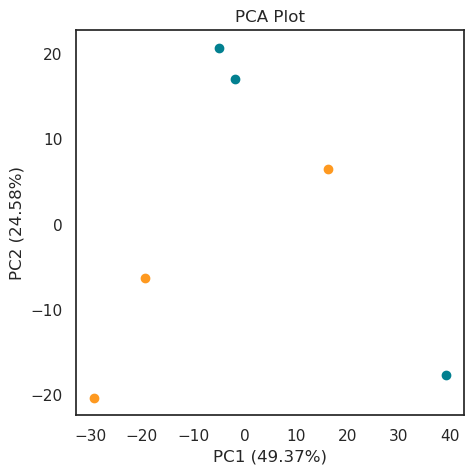

In [220]:
generate_pca_plot(pca_gene_rpkm, 'fig2/PCA_plot_RPKM')

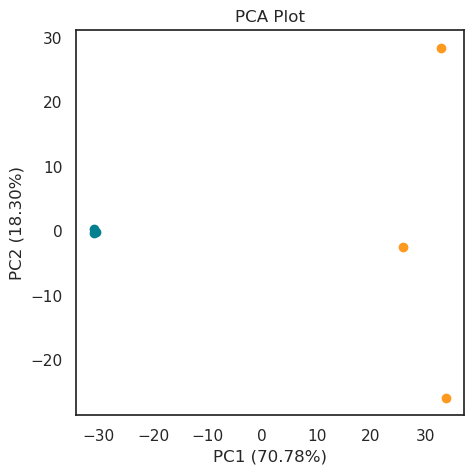

In [221]:
generate_pca_plot(pca_gene_editsC, 'fig2/PCA_plot_EditsC')

In [222]:
for_pca = pd.concat([pca_gene_editsC, pca_gene_rpkm]).dropna().drop(columns=['index']).T

In [223]:
for_pca_colnames = for_pca.columns

In [224]:
for_pca.head()

new_index  ENSG00000000003.10_editsC  ENSG00000001036.9_editsC  \
APO1_rep1                   0.001416                  0.002924   
APO1_rep2                   0.000000                  0.001462   
APO1_rep3                   0.002833                  0.000000   
RPS2_rep1                   0.002833                  0.004386   
RPS2_rep2                   0.012748                  0.017544   

new_index  ENSG00000001497.12_editsC  ENSG00000003056.3_editsC  \
APO1_rep1                   0.001445                  0.001131   
APO1_rep2                   0.000723                  0.000000   
APO1_rep3                   0.000000                  0.000000   
RPS2_rep1                   0.009393                  0.004525   
RPS2_rep2                   0.016618                  0.006787   

new_index  ENSG00000003756.12_editsC  ENSG00000004455.12_editsC  \
APO1_rep1                   0.000459                   0.000770   
APO1_rep2                   0.000459                   0.000770   
APO1_rep3                   0.000000                   0.000770   
RPS2_rep1                   0.003212                   0.011556   
RPS2_rep2                   0.000459                   0.011556   

new_index  ENSG00000004478.5_editsC  ENSG00000004897.7_editsC  \
APO1_rep1                  0.000934                  0.002274   
APO1_rep2                  0.000934                  0.000758   
APO1_rep3                  0.001867                  0.000000   
RPS2_rep1                  0.016807                  0.003791   
RPS2_rep2                  0.017740                  0.009856   

new_index  ENSG00000004975.7_editsC  ENSG00000005020.8_editsC  ...  \
APO1_rep1                  0.000631                  0.000867  ...   
APO1_rep2                  0.000000                  0.000000  ...   
APO1_rep3                  0.001894                  0.000000  ...   
RPS2_rep1                  0.000631                  0.000867  ...   
RPS2_rep2                  0.001894                  0.004333  ...   

new_index  ENSG00000197451.6_rpkm  ENSG00000197579.3_rpkm  \
APO1_rep1              113.742562               30.021975   
APO1_rep2              136.067789               24.951227   
APO1_rep3               87.837136               37.558604   
RPS2_rep1               19.179293               30.563704   
RPS2_rep2               54.369965               33.682109   

new_index  ENSG00000198431.11_rpkm  ENSG00000204628.7_rpkm  \
APO1_rep1                 1.385014               30.079221   
APO1_rep2                 2.025367               25.566959   
APO1_rep3                 1.366290               85.115975   
RPS2_rep1                 2.135774               13.313906   
RPS2_rep2                 2.163281               20.932877   

new_index  ENSG00000213585.6_rpkm  ENSG00000221914.4_rpkm  \
APO1_rep1               12.844074                4.292956   
APO1_rep2               15.786520                4.361974   
APO1_rep3               14.836250                4.526983   
RPS2_rep1                3.683335                2.817512   
RPS2_rep2                8.118288                4.457949   

new_index  ENSG00000240303.3_rpkm  ENSG00000241685.4_rpkm  \
APO1_rep1                1.230162                6.273161   
APO1_rep2                1.991661                4.921946   
APO1_rep3                3.989943                7.378421   
RPS2_rep1                1.607583                1.794160   
RPS2_rep2                1.591136                2.279499   

new_index  ENSG00000242247.6_rpkm  ENSG00000243725.2_rpkm  
APO1_rep1                3.511701               19.481953  
APO1_rep2                3.758765               17.511105  
APO1_rep3                8.542466               16.186176  
RPS2_rep1                2.158857                4.559424  
RPS2_rep2                3.686391               12.958231  

[5 rows x 2387 columns]

In [225]:
scaler = StandardScaler()
data_standardized = scaler.fit_transform(for_pca)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_standardized)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [226]:
pca_df

PC1        PC2
0 -32.293096 -10.855132
1 -31.486499 -13.892737
2 -38.800995   7.159194
3  51.561372 -27.878651
4  30.008195  -3.117554
5  21.011023  48.584880

In [227]:
for_pca = for_pca.reset_index()
for_pca['sample'] = for_pca.apply(lambda x: x['index'].split('_')[0], axis=1)

In [228]:
for_pca

new_index      index  ENSG00000000003.10_editsC  ENSG00000001036.9_editsC  \
0          APO1_rep1                   0.001416                  0.002924   
1          APO1_rep2                   0.000000                  0.001462   
2          APO1_rep3                   0.002833                  0.000000   
3          RPS2_rep1                   0.002833                  0.004386   
4          RPS2_rep2                   0.012748                  0.017544   
5          RPS2_rep3                   0.024079                  0.021930   

new_index  ENSG00000001497.12_editsC  ENSG00000003056.3_editsC  \
0                           0.001445                  0.001131   
1                           0.000723                  0.000000   
2                           0.000000                  0.000000   
3                           0.009393                  0.004525   
4                           0.016618                  0.006787   
5                           0.022399                  0.001131   

new_index  ENSG00000003756.12_editsC  ENSG00000004455.12_editsC  \
0                           0.000459                   0.000770   
1                           0.000459                   0.000770   
2                           0.000000                   0.000770   
3                           0.003212                   0.011556   
4                           0.000459                   0.011556   
5                           0.006425                   0.011556   

new_index  ENSG00000004478.5_editsC  ENSG00000004897.7_editsC  \
0                          0.000934                  0.002274   
1                          0.000934                  0.000758   
2                          0.001867                  0.000000   
3                          0.016807                  0.003791   
4                          0.017740                  0.009856   
5                          0.016807                  0.004549   

new_index  ENSG00000004975.7_editsC  ...  ENSG00000197579.3_rpkm  \
0                          0.000631  ...               30.021975   
1                          0.000000  ...               24.951227   
2                          0.001894  ...               37.558604   
3                          0.000631  ...               30.563704   
4                          0.001894  ...               33.682109   
5                          0.005051  ...               31.398603   

new_index  ENSG00000198431.11_rpkm  ENSG00000204628.7_rpkm  \
0                         1.385014               30.079221   
1                         2.025367               25.566959   
2                         1.366290               85.115975   
3                         2.135774               13.313906   
4                         2.163281               20.932877   
5                         1.470737               53.597282   

new_index  ENSG00000213585.6_rpkm  ENSG00000221914.4_rpkm  \
0                       12.844074                4.292956   
1                       15.786520                4.361974   
2                       14.836250                4.526983   
3                        3.683335                2.817512   
4                        8.118288                4.457949   
5                       13.026717                4.720768   

new_index  ENSG00000240303.3_rpkm  ENSG00000241685.4_rpkm  \
0                        1.230162                6.273161   
1                        1.991661                4.921946   
2                        3.989943                7.378421   
3                        1.607583                1.794160   
4                        1.591136                2.279499   
5                        6.508174                7.148222   

new_index  ENSG00000242247.6_rpkm  ENSG00000243725.2_rpkm  sample  
0                        3.511701               19.481953    APO1  
1                        3.758765               17.511105    APO1  
2                        8.542466               16.186176    APO1  
3                        2.1588

In [229]:
principal_components[:3, 0]

array([-32.29309607, -31.48649888, -38.80099453])

Text(0.5, 1.0, 'PCA Plot')

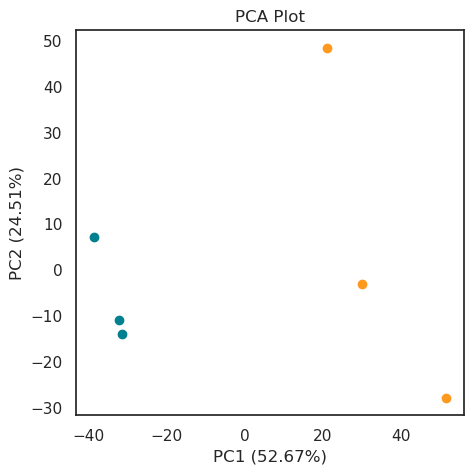

In [230]:
plt.figure(figsize=(5,5))
plt.scatter(principal_components[:3, 0], principal_components[:3, 1], c='#028090')
plt.scatter(principal_components[3:, 0], principal_components[3:, 1], c='#FE9920')
#for i, label in enumerate(for_pca['sample']):
    #plt.annotate(label, (principal_components[i, 0], principal_components[i, 1]), fontsize=12)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)')
plt.title('PCA Plot')
# plt.savefig(os.path.join(fig_path,'fig2/fig2_B.png'))
# plt.savefig(os.path.join(fig_path,'fig2/fig2_B.svg'))
# plt.savefig(os.path.join(fig_path,'fig2/fig2_B.jpg'))

In [231]:
loadings = pca.components_
loadings

array([[ 0.01362589,  0.0167947 ,  0.02137964, ..., -0.01987764,
        -0.00964257, -0.02096878],
       [ 0.035178  ,  0.02813064,  0.02485012, ...,  0.02650686,
         0.03371181,  0.02197679]])

In [232]:
loadings_df = pd.DataFrame(loadings, index=['PC1', 'PC2'], columns=for_pca_colnames)

In [233]:
loadings_df.loc['PC1':'PC1', :].sort_values(by='PC1', axis=1)

new_index  ENSG00000187514.10_rpkm  ENSG00000145191.7_rpkm  \
PC1                      -0.028139               -0.028045   

new_index  ENSG00000108671.5_rpkm  ENSG00000188229.5_rpkm  \
PC1                     -0.027674               -0.027641   

new_index  ENSG00000196230.8_rpkm  ENSG00000197170.5_rpkm  \
PC1                     -0.027619                -0.02741   

new_index  ENSG00000184009.5_rpkm  ENSG00000108344.10_rpkm  \
PC1                      -0.02738                -0.027286   

new_index  ENSG00000147274.10_rpkm  ENSG00000161960.10_rpkm  ...  \
PC1                      -0.027212                -0.027208  ...   

new_index  ENSG00000100225.13_editsC  ENSG00000127022.10_editsC  \
PC1                         0.028123                   0.028128   

new_index  ENSG00000111605.12_editsC  ENSG00000122970.11_editsC  \
PC1                         0.028136                   0.028144   

new_index  ENSG00000084090.9_editsC  ENSG00000146247.13_editsC  \
PC1                        0.028145                   0.028149   

new_index  ENSG00000009307.11_editsC  ENSG00000173473.6_editsC  \
PC1                         0.028152                  0.028165   

new_index  ENSG00000124795.10_editsC  ENSG00000008838.13_editsC  
PC1                         0.028178                   0.028187  

[1 rows x 2387 columns]

In [234]:
pca_gene_row_metric_pc1 = [i.split('_')[1] for i in loadings_df.T.sort_values(by='PC1', ascending=False).index]
pca_gene_row_color_pc1=[]
for i in pca_gene_row_metric_pc1:
    if i=='editsC':
        pca_gene_row_color_pc1.append('#028090')
    else:
        pca_gene_row_color_pc1.append('#7E1F86')

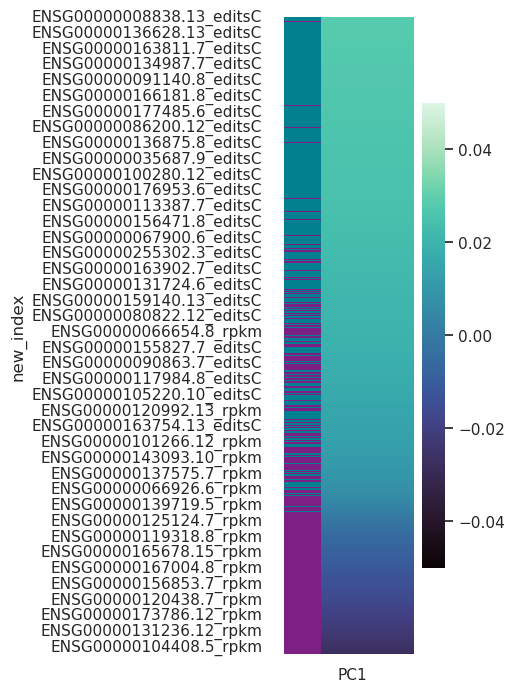

In [235]:
sns.set(rc={'figure.figsize':(2,8.27)})

ax=sns.heatmap(loadings_df.T.sort_values(by='PC1', ascending=False)[['PC1']], cmap='mako', vmin=-0.05, vmax=0.05)#,row_colors=row_colors1, col_cluster=False)#,'switchConsequencesGene']]
ax.tick_params(axis='y', which='major', pad=20, length=0) # extra padding to leave room for the row colors
#ax.set_yticklabels(data['group'], rotation=0) # optionally use the groups as the tick labels
for i, color in enumerate(pca_gene_row_color_pc1):
    ax.add_patch(plt.Rectangle(xy=(-0.05, i), width=0.3, height=1, color=color, lw=0,
                               transform=ax.get_yaxis_transform(), clip_on=False))
#plt.tight_layout()
# plt.savefig(os.path.join(fig_path,'fig2/fig2_B_pc1.png'))
# plt.savefig(os.path.join(fig_path,'fig2/fig2_B_pc1.svg'))
# plt.savefig(os.path.join(fig_path,'fig2/fig2_B_pc1.jpg'))
plt.show()

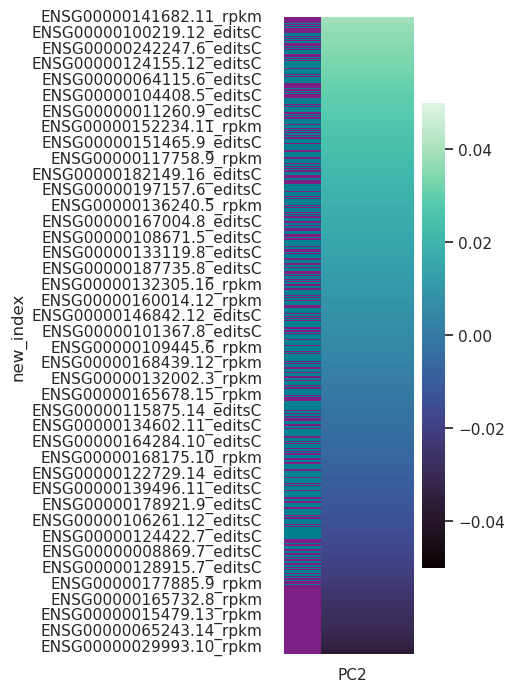

In [236]:
pca_gene_row_metric_pc2 = [i.split('_')[1] for i in loadings_df.T.sort_values(by='PC2', ascending=False).index]
pca_gene_row_color_pc2=[]
for i in pca_gene_row_metric_pc2:
    if i=='editsC':
        pca_gene_row_color_pc2.append('#028090')
    else:
        pca_gene_row_color_pc2.append('#7E1F86')


sns.set(rc={'figure.figsize':(2,8.27)})

ax=sns.heatmap(loadings_df.T.sort_values(by='PC2', ascending=False)[['PC2']], cmap='mako', vmin=-0.05, vmax=0.05)#,row_colors=row_colors1, col_cluster=False)#,'switchConsequencesGene']]
ax.tick_params(axis='y', which='major', pad=20, length=0) # extra padding to leave room for the row colors
#ax.set_yticklabels(data['group'], rotation=0) # optionally use the groups as the tick labels
for i, color in enumerate(pca_gene_row_color_pc2):
    ax.add_patch(plt.Rectangle(xy=(-0.05, i), width=0.3, height=1, color=color, lw=0,
                               transform=ax.get_yaxis_transform(), clip_on=False))
#plt.tight_layout()
# plt.savefig(os.path.join(fig_path,'fig2/fig2_B_pc2.png'))
# plt.savefig(os.path.join(fig_path,'fig2/fig2_B_pc2.svg'))
# plt.savefig(os.path.join(fig_path,'fig2/fig2_B_pc2.jpg'))
plt.show()

In [237]:
print(f'PC1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)')
print(f'PC2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)')

PC1 (52.67%)
PC2 (24.51%)


In [238]:
loadings[0]

array([ 0.01362589,  0.0167947 ,  0.02137964, ..., -0.01987764,
       -0.00964257, -0.02096878])

In [239]:
import statsmodels.api as sm

In [240]:
annotated_gene_editsC_copy_lm = annotated_gene_editsC_copy.copy().dropna()

In [241]:
X = sm.add_constant(annotated_gene_editsC_copy_lm['APO_mean'])  # adding a constant for the intercept
y = annotated_gene_editsC_copy_lm['RPS2_mean']

# Fit a linear regression model using APO_mean as the predictor and RPS2_mean as the response variable
model_linear = sm.OLS(y, X).fit()

# Calculate the residuals
annotated_gene_editsC_copy_lm['residuals'] = model_linear.resid

# Identify significant residuals
# For this example, let's consider residuals that are greater than 1 standard deviation from the mean as significant
mean_residual = annotated_gene_editsC_copy_lm['residuals'].mean()
std_residual = annotated_gene_editsC_copy_lm['residuals'].std()
threshold = mean_residual + std_residual

# Find data points where the signal is significantly greater than the background
significant_signal = annotated_gene_editsC_copy_lm[annotated_gene_editsC_copy_lm['residuals'] > threshold]

# Display the results
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              RPS2_mean   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     2408.
Date:                Tue, 23 Jan 2024   Prob (F-statistic):          9.20e-286
Time:                        14:10:50   Log-Likelihood:                 3311.2
No. Observations:                1167   AIC:                            -6618.
Df Residuals:                    1165   BIC:                            -6608.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.001     11.625      0.000       0.005       0.007
APO_mean      10.9163      0.222     49.069      0.000      10.480      11.353
==============================================================================
Omnibus:                      438.081   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6275.976
Skew:                           1.328   Prob(JB):                         0.00
Kurtosis:                      14.046   Cond. No.                         536.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [242]:
annotated_gene_editsC_copy_lm['sig'] = annotated_gene_editsC_copy_lm['gene_name'].isin(significant_signal['gene_name'].tolist())

In [243]:
annotated_gene_editsC_copy_lm

editsC_APO_rep1  editsC_APO_rep2  editsC_APO_rep3  \
ENSG00000001497.12         0.001445         0.000723         0.000000   
ENSG00000003056.3          0.001131         0.000000         0.000000   
ENSG00000003756.12         0.000459         0.000459         0.000000   
ENSG00000004455.12         0.000770         0.000770         0.000770   
ENSG00000004478.5          0.000934         0.000934         0.001867   
...                             ...              ...              ...   
ENSG00000253719.2          0.000000         0.000000         0.000000   
ENSG00000069275.12         0.000000         0.000000         0.000000   
ENSG00000165512.4          0.000000         0.000000         0.000000   
ENSG00000168672.3          0.000000         0.000000         0.000000   
ENSG00000189306.6          0.000000         0.000000         0.000000   

                    editsC_RPS2_rep1  editsC_RPS2_rep2  editsC_RPS2_rep3  \
ENSG00000001497.12          0.009393          0.016618          0.022399   
ENSG00000003056.3           0.004525          0.006787          0.001131   
ENSG00000003756.12          0.003212          0.000459          0.006425   
ENSG00000004455.12          0.011556          0.011556          0.011556   
ENSG00000004478.5           0.016807          0.017740          0.016807   
...                              ...               ...               ...   
ENSG00000253719.2           0.004837          0.006046          0.001209   
ENSG00000069275.12          0.000000          0.002182          0.001455   
ENSG00000165512.4           0.000000          0.001980          0.005941   
ENSG00000168672.3           0.000000          0.001442          0.000721   
ENSG00000189306.6           0.000000          0.000000          0.000781   

                   gene_name       gene_type  ensembl_gene_id  APO1_1  ...  \
ENSG00000001497.12     LAS1L  protein_coding  ENSG00000001497    56.0  ...   
ENSG00000003056.3       M6PR  protein_coding  ENSG00000003056    34.0  ...   
ENSG00000003756.12      RBM5  protein_coding  ENSG00000003756    26.0  ...   
ENSG00000004455.12       AK2  protein_coding  ENSG00000004455   147.0  ...   
ENSG00000004478.5      FKBP4  protein_coding  ENSG00000004478   113.0  ...   
...                      ...             ...              ...     ...  ...   
ENSG00000253719.2   ATXN7L3B  protein_coding  ENSG00000253719    97.0  ...   
ENSG00000069275.12    NUCKS1  protein_coding  ENSG00000069275    97.0  ...   
ENSG00000165512.4      ZNF22  protein_coding  ENSG00000165512    88.0  ...   
ENSG00000168672.3     FAM84B  protein_coding  ENSG00000168672    40.0  ...   
ENSG00000189306.6      RRP7A  protein_coding  ENSG00000189306    25.0  ...   

                     Length  RPS2_3_RPKM  APO_mean  RPS2_mean  APO_RPKM_mean  \
ENSG00000001497.12  22194.0    16.155333  0.000723   0.016137      14.164201   
ENSG00000003056.3    9593.0    22.554702  0.000377   0.004148      23.411508   
ENSG00000003756.12  30114.0    17.449138  0.000306   0.003365      11.545975   
ENSG00000004455.12  73013.0    13.801011  0.000770   0.011556      13.533863   
ENSG00000004478.5   10458.0    52.018464  0.001245   0.017118      77.136625   
...                     ...          ...       ...        ...            ...   
ENSG00000253719.2    3673.0   220.482365  0.000000   0.004031     173.640331   
ENSG00000069275.12  37458.0    17.163753  0.000000   0.001212      21.854987   
ENSG00000165512.4    4852.0    68.801271  0.000000   0.002640      76.199138   
ENSG00000168672.3    5952.0    33.236138  0.000000   0.000721      49.445661   
ENSG00000189306.6    9835.0    24.513975  0.000000   0.000260      19.051187   

                    RPS2_RPKM_mean  RPS2_editsC/RPS2_RPKM_mean  \
ENSG00000001497.12       11.992591                    0.001346   
ENSG00000003056.3        21.078075                    0.000197   
ENSG00000003756.12       12.629318                    0.000266   
ENSG00000004455.12       10.868241                    0.001063   
EN

In [147]:
#annotated_gene_editsC_copy_lm.to_csv('annotated_gene_editsC_copy_lm_dec2023.txt', sep='\t')

/tmp/ipykernel_2716627/3177314611.py:3: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(x='APO_mean', y='RPS2_mean', data=annotated_gene_editsC_copy_lm, palette=custom_palette, linewidth=0, alpha=0.5, hue='sig')


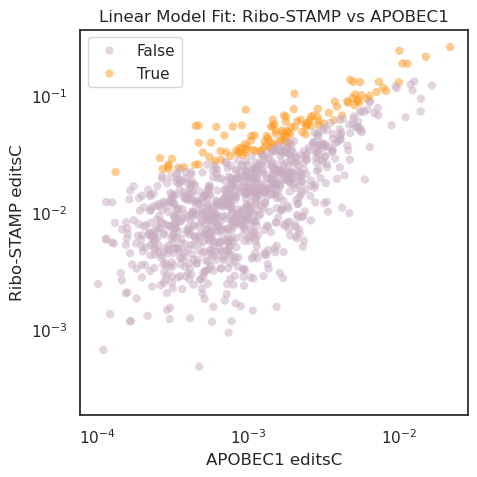

In [244]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style('white')
sns.scatterplot(x='APO_mean', y='RPS2_mean', data=annotated_gene_editsC_copy_lm, palette=custom_palette, linewidth=0, alpha=0.5, hue='sig')

# Predicted values from the linear model
predicted_values = model_linear.predict(X)

# Plotting the regression line
#sns.lineplot(x=annotated_gene_editsC_copy_lm['APO_mean'], y=predicted_values, color='grey', label='Fitted Line', linestyle='dashed')

plt.title('Linear Model Fit: Ribo-STAMP vs APOBEC1')
plt.xlabel('APOBEC1 editsC')
plt.ylabel('Ribo-STAMP editsC')
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.savefig(os.path.join(fig_path,'fig2/fig2_E.png'))
# plt.savefig(os.path.join(fig_path,'fig2/fig2_E.svg'))
# plt.savefig(os.path.join(fig_path,'fig2/fig2_E.jpg'))
plt.show()

In [248]:
dec_lm_results = pd.read_csv('annotated_gene_editsC_copy_lm_dec2023.txt', sep='\t')

In [252]:
dec_lm_results[dec_lm_results['sig']==True].shape

(141, 36)

In [258]:
dec_lm_results.sort_values(by='RPS2_mean', ascending=False).head(150)

Unnamed: 0  editsC_APO_rep1  editsC_APO_rep2  editsC_APO_rep3  \
143  ENSG00000096384.15         0.027869         0.027869         0.009836   
327  ENSG00000124207.12         0.015089         0.013717         0.001372   
626   ENSG00000166598.8         0.019025         0.017836         0.008323   
717  ENSG00000196305.13         0.008516         0.009124         0.013990   
183  ENSG00000102024.13         0.006485         0.006485         0.001297   
..                  ...              ...              ...              ...   
55   ENSG00000064102.10         0.001311         0.000000         0.001311   
274   ENSG00000115758.8         0.004914         0.001229         0.002457   
68   ENSG00000067225.13         0.003861         0.004719         0.002145   
558  ENSG00000159131.12         0.001649         0.001100         0.002199   
136  ENSG00000090060.13         0.001715         0.000429         0.000000   

     editsC_RPS2_rep1  editsC_RPS2_rep2  editsC_RPS2_rep3 gene_name  \
143          0.260656          0.275410          0.249180  HSP90AB1   
327          0.331962          0.264746          0.133059     CSE1L   
626          0.216409          0.198573          0.234245   HSP90B1   
717          0.206813          0.156934          0.203771      IARS   
183          0.182879          0.125811          0.103761      PLS3   
..                ...               ...               ...       ...   
55           0.041940          0.009174          0.048493      ASUN   
274          0.014742          0.039312          0.045455      ODC1   
68           0.030459          0.036036          0.032604       PKM   
558          0.040132          0.021440          0.037383      GART   
136          0.047578          0.033005          0.018003    PAPOLA   

          gene_type  ensembl_gene_id  ...  RPS2_3  RPS2_3_RPKM  APO_mean  \
143  protein_coding  ENSG00000096384  ...   551.0  1081.556905  0.021858   
327  protein_coding  ENSG00000124207  ...   252.0   371.186893  0.010059   
626  protein_coding  ENSG00000166598  ...    36.0    42.145367  0.015061   
717  protein_coding  ENSG00000196305  ...  1570.0  1164.244488  0.010543   
183  protein_coding  ENSG00000102024  ...   326.0   432.376475  0.004756   
..              ...              ...  ...     ...          ...       ...   
55   protein_coding  ENSG00000064102  ...    74.0   121.414496  0.000874   
274  protein_coding  ENSG00000115758  ...   191.0   353.186759  0.002867   
68   protein_coding  ENSG00000067225  ...   537.0   343.816778  0.003575   
558  protein_coding  ENSG00000159131  ...   431.0   303.106292  0.001649   
136  protein_coding  ENSG00000090060  ...   186.0    79.963730  0.000714   

     RPS2_mean  APO_RPKM_mean  RPS2_RPKM_mean  RPS2_editsC/RPS2_RPKM_mean  \
143   0.261749    1518.330232     1313.250874                    0.000199   
327   0.243256     662.951487      982.354786                    0.000248   
626   0.216409      58.628618       36.134111                    0.005989   
717   0.189173     632.218611      830.986894                    0.000228   
183   0.137484     523.243355      651.423292                    0.000211   
..         ...            ...             ...                         ...   
55    0.033202      96.426177      118.102685                    0.000281   
274   0.033170     368.185770      252.475384                    0.000131   
68    0.033033     483.717130      264.042760                    0.000125   
558   0.032985     218.222975      251.333352                    0.000131   
136   0.032862     115.510599      180.269705                    0.000182   

     APO_editsC/APO_RPKM_mean  residuals    sig  
143                  0.000014   0.005828  False  
327                  0.000015   0.123614   True  
626                  0.000257   0.038991   True  
717                  0.000017   0.063941   True  
183                  0.000009   0.079103   True  
..                        ...        ...    ...  
55                   0.000009   0.0

### GO Analysis

In [149]:
editsC_gene_Q1 = np.array_split(significant_signal.dropna().sort_values(by=['RPS2_mean'], ascending=[False]), 4)[0]['gene_name'].tolist() ## most translated
editsC_gene_Q2 = np.array_split(significant_signal.dropna().sort_values(by=['RPS2_mean'], ascending=[False]), 4)[1]['gene_name'].tolist()
editsC_gene_Q3 = np.array_split(significant_signal.dropna().sort_values(by=['RPS2_mean'], ascending=[False]), 4)[2]['gene_name'].tolist()
editsC_gene_Q4 = np.array_split(significant_signal.dropna().sort_values(by=['RPS2_mean'], ascending=[False]), 4)[3]['gene_name'].tolist() ## least translated

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [150]:
for i in range(0,4):
    np.array_split(significant_signal.dropna().sort_values(by=['RPS2_mean'], ascending=[False]), 4)[i].to_csv(f'Q{i+1}_table_lm_sig.txt', sep='\t')

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


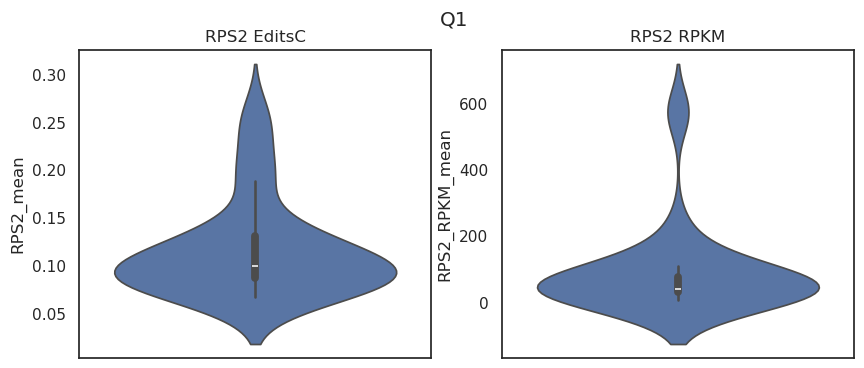

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


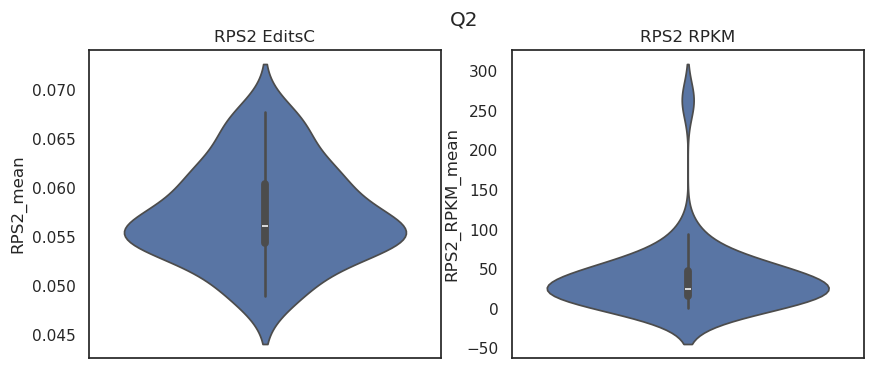

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


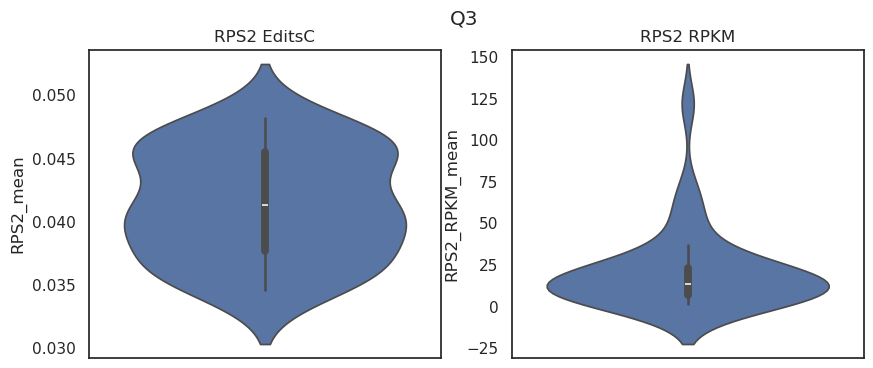

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


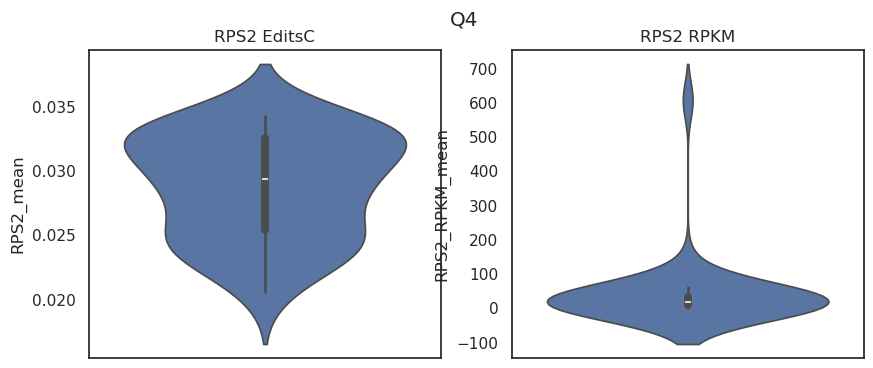

In [151]:

for i in range(0,4):
    sns.set(rc={'figure.figsize':(5,2)})
    sns.set_style('white')
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.violinplot(np.array_split(significant_signal.dropna().sort_values(by=['RPS2_mean'], ascending=[False]), 4)[i]['RPS2_mean'], ax=axes[0])
    sns.violinplot(np.array_split(significant_signal.dropna().sort_values(by=['RPS2_mean'], ascending=[False]), 4)[i]['RPS2_RPKM_mean'], ax=axes[1])
    axes[0].set_title('RPS2 EditsC')
    axes[1].set_title('RPS2 RPKM')
    plt.suptitle(f'Q{int(i+1)}')
    plt.show()

### Correlation analysis

#### Replicate

In [152]:
from scipy import stats
import itertools

In [153]:
sns.set_style('white')
def plot_rep_corelation(annotated_df, sample):
    fig, axes = plt.subplots(3,1, figsize=(5, 15))
    count=0
    #for rep1 in [f'editsC_{sample}_rep1',f'editsC_{sample}_rep2',f'editsC_{sample}_rep3']:
        #for rep2 in [f'editsC_{sample}_rep1',f'editsC_{sample}_rep2',f'editsC_{sample}_rep3']:
    for combo in list(itertools.combinations([f'editsC_{sample}_rep1',f'editsC_{sample}_rep2',f'editsC_{sample}_rep3'], 2)):
        rep1=combo[0]
        rep2=combo[1]
        #sns.scatterplot(data=annotated_df, x=rep1, y=rep2, ax=axes[count], linewidth=0, alpha=0.5)
        print(rep1, rep2, stats.pearsonr(annotated_df[rep1].tolist(), annotated_df[rep2].tolist()))
        if sample=='APO':
            sns.scatterplot(data=annotated_df, x=rep1, y=rep2, ax=axes[count], linewidth=0, alpha=0.5, color='#028090')
            axes[count].text(0.025, 0.014, f'{stats.spearmanr(annotated_df[rep1].tolist(), annotated_df[rep2].tolist())[0]:.3f}')
        if sample=='RPS2':
            sns.scatterplot(data=annotated_df, x=rep1, y=rep2, ax=axes[count], linewidth=0, alpha=0.5, color='#FE9920')
            axes[count].text(0.25, 0.25, f'{stats.spearmanr(annotated_df[rep1].tolist(), annotated_df[rep2].tolist())[0]:.3f}')
        plt.legend([])
        count+=1
    # plt.savefig(os.path.join(fig_path,f'sup1/su1B_{sample}.png'))
    # plt.savefig(os.path.join(fig_path,f'sup1/su1B_{sample}.svg'))
    # plt.savefig(os.path.join(fig_path,f'sup1/su1B_{sample}.jpg'))  

editsC_APO_rep1 editsC_APO_rep2 PearsonRResult(statistic=0.8406439737681783, pvalue=3.657171602740454e-36)
editsC_APO_rep1 editsC_APO_rep3 PearsonRResult(statistic=0.5769317860907092, pvalue=5.503898083598402e-13)
editsC_APO_rep2 editsC_APO_rep3 PearsonRResult(statistic=0.6574248477430265, pvalue=1.475504682029595e-17)
editsC_RPS2_rep1 editsC_RPS2_rep2 PearsonRResult(statistic=0.8883834486429701, pvalue=1.917051360184747e-45)
editsC_RPS2_rep1 editsC_RPS2_rep3 PearsonRResult(statistic=0.6807302349841473, pvalue=3.7313754436594204e-19)
editsC_RPS2_rep2 editsC_RPS2_rep3 PearsonRResult(statistic=0.8153826645951917, pvalue=2.0455453331967977e-32)


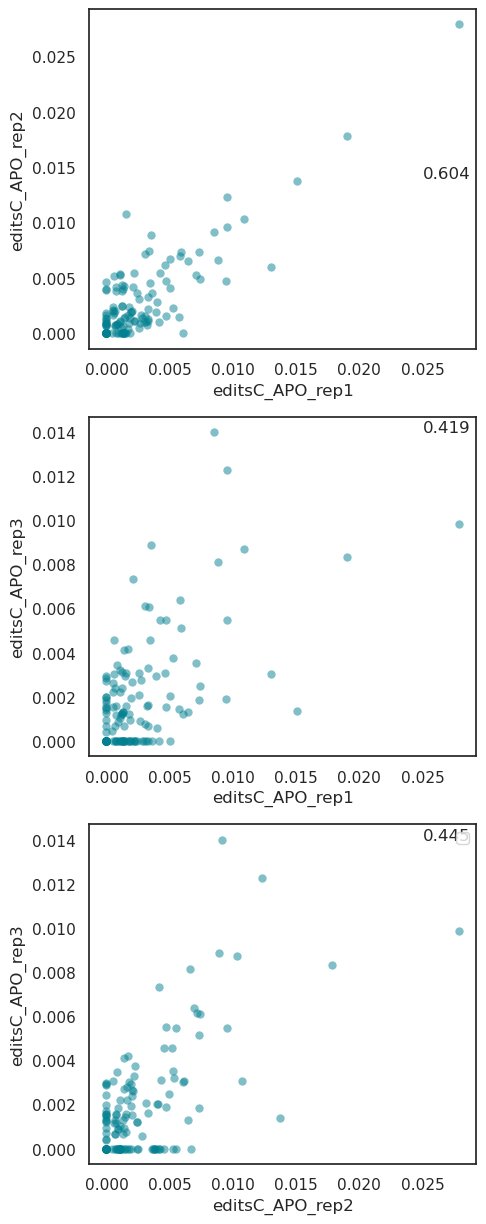

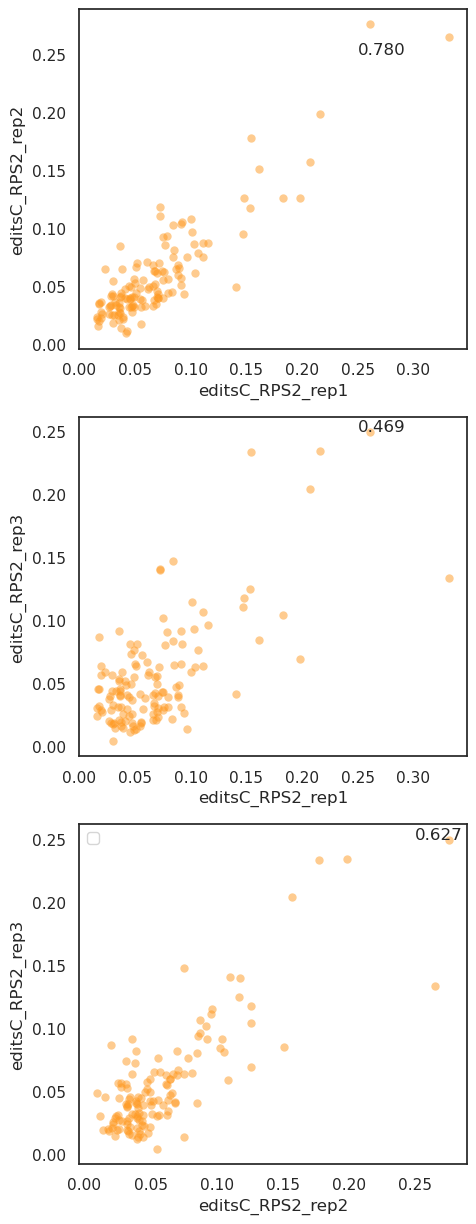

In [154]:
plot_rep_corelation(significant_signal.dropna(), 'APO')
plot_rep_corelation(significant_signal.dropna(), 'RPS2')

In [155]:
def plot_apo_rps2_corelation(annotated_df):
    sns.set_style('white')

    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    count=0
    for rep in ['rep1', 'rep2', 'rep3']:
        sns.scatterplot(data=annotated_df, x=f'editsC_APO_{rep}', y=f'editsC_RPS2_{rep}', ax=axes[count], linewidth=0, alpha=0.5, color='#151E3F')
        print(stats.pearsonr(annotated_df[f'editsC_APO_{rep}'].tolist(), annotated_df[f'editsC_RPS2_{rep}'].tolist()))
        axes[count].text(0.012, 0.2, f"{stats.pearsonr(annotated_df[f'editsC_APO_{rep}'].tolist(), annotated_df[f'editsC_RPS2_{rep}'].tolist())[0]:.3f}")
        count+=1
    # plt.savefig(os.path.join(fig_path,f'sup1/sup1C_apo_rps2_corr.png'))
    # plt.savefig(os.path.join(fig_path,f'sup1/sup1C_apo_rps2_corr.svg'))
    # plt.savefig(os.path.join(fig_path,f'sup1/sup1C_apo_rps2_corr.jpg'))

In [156]:
#stats.scatterplot(annotated_gene_editsC[f'editsC_APO_rep1'].tolist(),annotated_gene_editsC[f'editsC_RPS2_rep1'].tolist()

PearsonRResult(statistic=0.7977288204670286, pvalue=4.0227859220708255e-30)
PearsonRResult(statistic=0.8704530764702738, pvalue=1.5744257769434747e-41)
PearsonRResult(statistic=0.7802316736485339, pvalue=4.612742525777208e-28)


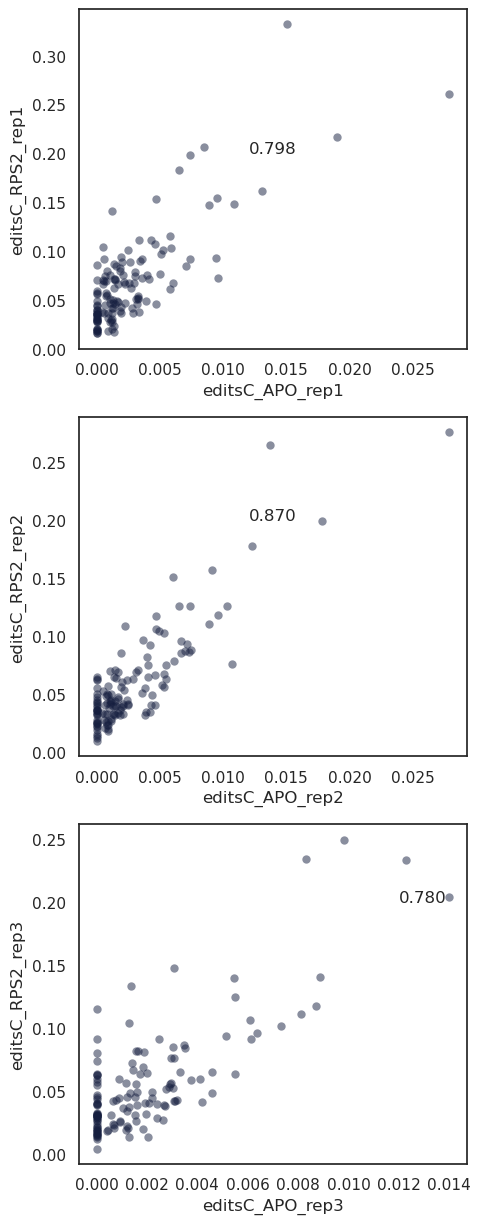

In [157]:
plot_apo_rps2_corelation(significant_signal.dropna())

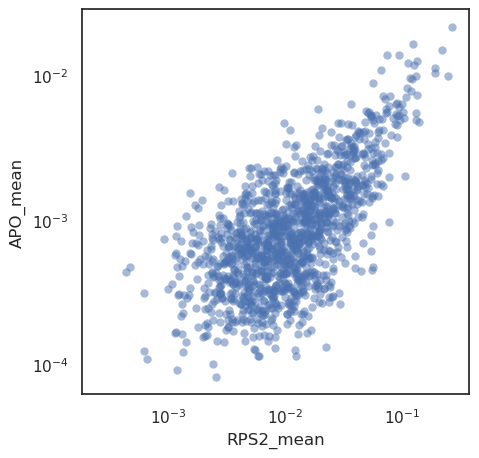

In [158]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style('white')
sns.scatterplot(data=annotated_gene_editsC_copy, x='RPS2_mean', y='APO_mean', linewidth=0, alpha=0.5)
plt.yscale('log')
plt.xscale('log')

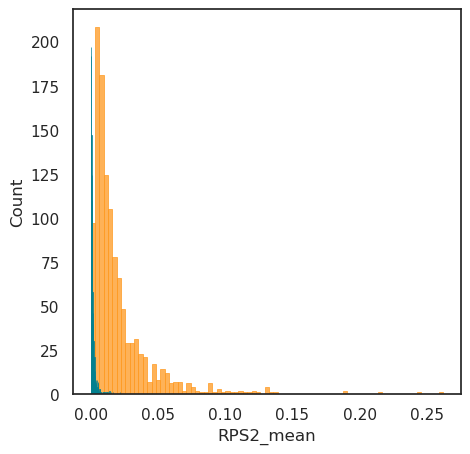

In [144]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style('white')
sns.histplot(annotated_gene_editsC_copy.dropna()['RPS2_mean'], color='#FE9920', edgecolor='#FE9920', linewidth=0.5)
# plt.savefig(os.path.join(fig_path,f'sup1/sup1_rps2_mean_dist.png'))
# plt.savefig(os.path.join(fig_path,f'sup1/sup1_rps2_mean_dist.svg'))
# plt.savefig(os.path.join(fig_path,f'sup1/sup1_rps2_mean_dist.jpg'))
#plt.show()
sns.histplot(annotated_gene_editsC_copy.dropna()['APO_mean'], color='#028090', edgecolor='#028090', linewidth=0.5)
plt.savefig(os.path.join(fig_path,f'sup1/sup1_apo_rps2_mean_dist.png'))
plt.savefig(os.path.join(fig_path,f'sup1/sup1_apo_rps2_mean_dist.svg'))
plt.savefig(os.path.join(fig_path,f'sup1/sup1_apo_rps2_mean_dist.jpg'))

### Short read

In [160]:
sr_epr = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/RPS2/RPS2_STAMP_SR/epkm_outputs/epkm_6_epkms_merged/epr.CDS.merged.tsv', sep='\t', index_col =0).iloc[:,:1].reset_index()
sr_epkm = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/RPS2/RPS2_STAMP_SR/epkm_outputs/epkm_6_epkms_merged/epkm.CDS.merged.tsv', sep='\t', index_col =0).iloc[:,:1].reset_index()

In [161]:
annotated_gene_editsC_copy.columns

Index(['editsC_APO_rep1', 'editsC_APO_rep2', 'editsC_APO_rep3',
       'editsC_RPS2_rep1', 'editsC_RPS2_rep2', 'editsC_RPS2_rep3', 'gene_name',
       'gene_type', 'ensembl_gene_id', 'APO1_1', 'Length', 'APO1_1_RPKM',
       'RPS2_1', 'Length', 'RPS2_1_RPKM', 'APO1_2', 'Length', 'APO1_2_RPKM',
       'RPS2_2', 'Length', 'RPS2_2_RPKM', 'APO1_3', 'Length', 'APO1_3_RPKM',
       'RPS2_3', 'Length', 'RPS2_3_RPKM', 'APO_mean', 'RPS2_mean',
       'APO_RPKM_mean', 'RPS2_RPKM_mean', 'RPS2_editsC/RPS2_RPKM_mean',
       'APO_editsC/APO_RPKM_mean'],
      dtype='object')

In [162]:
lr_sr_stamp = significant_signal.merge(sr_epr, left_on='ensembl_gene_id', right_on='index').dropna()

SignificanceResult(statistic=-0.04241178668659585, pvalue=0.6305241570694344)


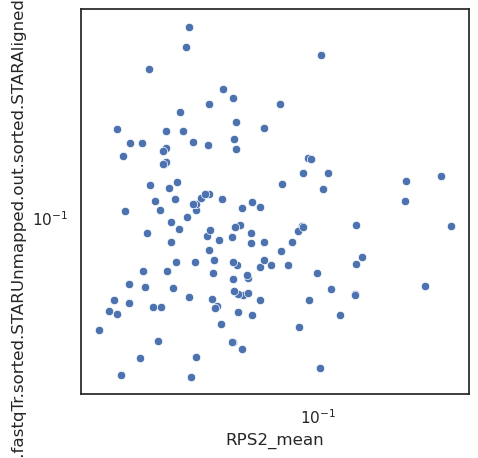

In [163]:
sns.scatterplot(data=lr_sr_stamp, x='RPS2_mean', y='RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam.epr.CDS.extract.tsv')
plt.yscale('log')
plt.xscale('log')
print(stats.spearmanr(lr_sr_stamp['RPS2_mean'], lr_sr_stamp['RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam.epr.CDS.extract.tsv']))

In [164]:
lr_sr_epkm_stamp = significant_signal.merge(sr_epkm, left_on='ensembl_gene_id', right_on='index').dropna()

SignificanceResult(statistic=0.29168312603427105, pvalue=0.0007241063852923222)


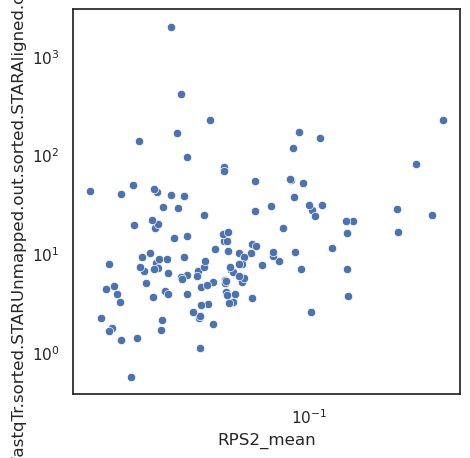

In [165]:
sns.scatterplot(data=lr_sr_epkm_stamp, x='RPS2_mean', y='RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam.epkm.CDS.extract.tsv')
plt.yscale('log')
plt.xscale('log')
print(stats.spearmanr(lr_sr_epkm_stamp['RPS2_mean'], lr_sr_epkm_stamp['RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam.epkm.CDS.extract.tsv']))

### Riboseq

In [166]:
##### MAKE QUARTILE PLOTS

In [167]:
from scipy import stats

In [168]:
orel_riboseq = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/orel_hek_all_rpkm.csv', sep='\t')

In [169]:
orel_riboseq_counts = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/orel_hek_all_reads.csv', sep='\t')

In [170]:
riboseq_data = orel_riboseq.merge(orel_riboseq_counts, on='gene_name', suffixes=('_rpkm', '_counts'))

In [171]:
riboseq_data['gene'] = riboseq_data.apply(lambda x: x['gene_name'].split('|')[0], axis=1)

In [172]:
riboseq_data = riboseq_data[(riboseq_data['reads_fp_chx__293t_calibration_rep1']>=20) & (riboseq_data['reads_fp_chx__293t_calibration_rep2']>=20) & (riboseq_data['reads_mrna_293t_calibration_rep1']>=20) & (riboseq_data['reads_mrna_293t_calibration_rep2']>=20)]

In [173]:
riboseq_data['avg_fp'] = riboseq_data.apply(lambda x: np.mean([x['rpkm_fp_chx__293t_calibration_rep1'],x['rpkm_fp_chx__293t_calibration_rep2']]), axis=1)

In [174]:
riboseq_data['avg_mrna'] = riboseq_data.apply(lambda x: np.mean([x['rpkm_mrna_293t_calibration_rep1'],x['rpkm_mrna_293t_calibration_rep2']]), axis=1)

In [175]:
riboseq_data['TE'] = riboseq_data['avg_fp']/riboseq_data['avg_mrna']

In [176]:
annotated_gene_editsC_copy_ribomerge = significant_signal.merge(riboseq_data.set_index('gene'), left_on='gene_name', right_on='gene').dropna()

In [177]:
annotated_gene_epkm_copy_ribomerge = annotated_gene_epkm_copy.merge(riboseq_data.set_index('gene'), left_on='gene_name', right_on='gene').dropna()

In [178]:
annotated_gene_editsC_copy_ribomerge.head()

editsC_APO_rep1  editsC_APO_rep2  editsC_APO_rep3  editsC_RPS2_rep1  \
0         0.001575         0.000000         0.001575          0.048819   
1         0.003061         0.007143         0.006122          0.078571   
2         0.001436         0.001436         0.000000          0.045944   
3         0.001669         0.001669         0.004174          0.065943   
4         0.001311         0.000000         0.001311          0.041940   

   editsC_RPS2_rep2  editsC_RPS2_rep3 gene_name_x       gene_type  \
0          0.031496          0.055118       TTC27  protein_coding   
1          0.092857          0.090816       HSPA5  protein_coding   
2          0.039483          0.011486         ZFR  protein_coding   
3          0.068447          0.040902       CCAR1  protein_coding   
4          0.009174          0.048493        ASUN  protein_coding   

   ensembl_gene_id  APO1_1  ...  rpkm_fp_chx__293t_calibration_rep2  \
0  ENSG00000018699    67.0  ...                           37.406702   
1  ENSG00000044574   487.0  ...                           46.148152   
2  ENSG00000056097    69.0  ...                           40.270766   
3  ENSG00000060339   163.0  ...                           87.424969   
4  ENSG00000064102    54.0  ...                           50.711896   

   rpkm_mrna_293t_calibration_rep1  rpkm_mrna_293t_calibration_rep2  \
0                        11.647793                        14.240166   
1                       110.820942                       107.427465   
2                        25.885207                        28.908236   
3                        28.476164                        30.417944   
4                        15.573799                        17.108065   

   reads_fp_chx__293t_calibration_rep1  reads_fp_chx__293t_calibration_rep2  \
0                                  222                                  311   
1                                  532                                  522   
2                                  476                                  541   
3                                  778                                  961   
4                                  305                                  430   

   reads_mrna_293t_calibration_rep1  reads_mrna_293t_calibration_rep2  \
0                               198                               182   
1                              2563                              1868   
2                               711                               597   
3                               640                               514   
4                               270                               223   

      avg_fp    avg_mrna        TE  
0  32.964679   12.943980  2.546719  
1  48.193716  109.124203  0.441641  
2  39.059583   27.396721  1.425703  
3  81.514038   29.447054  2.768156  
4  44.567356   16.340932  2.727345  

[5 rows x 46 columns]

In [179]:
annotated_gene_epkm_copy_ribomerge.head()

edit_count_rep1_apo  edit_count_rep2_apo  edit_count_rep3_apo  \
7                   1.0                  1.0                  1.0   
8                   1.0                  1.0                  2.0   
15                  2.0                  1.0                  2.0   
25                  1.0                  1.0                  1.0   
27                  7.0                  4.0                  2.0   

    epkm_rep1_apo  epkm_rep2_apo  epkm_rep3_apo  edit_count_rep1_rps2  \
7        0.041604       0.045617       0.054297                  15.0   
8        0.290458       0.318479       0.758156                  18.0   
15       2.080556       1.140636       2.715342                   5.0   
25       0.052328       0.057376       0.068293                   9.0   
27       0.824254       0.516441       0.307354                  52.0   

    edit_count_rep2_rps2  edit_count_rep3_rps2  epkm_rep1_rps2  ...  \
7                   15.0                  15.0        0.537441  ...   
8                   19.0                  18.0        4.502605  ...   
15                  11.0                  25.0        4.479475  ...   
25                   9.0                  19.0        0.405584  ...   
27                  42.0                  20.0        5.273199  ...   

    rpkm_fp_chx__293t_calibration_rep2  rpkm_mrna_293t_calibration_rep1  \
7                            15.392458                        58.919902   
8                            49.160682                       114.530356   
15                           70.922105                       611.666188   
25                           14.098935                        11.492764   
27                           64.688112                        65.000743   

   rpkm_mrna_293t_calibration_rep2 reads_fp_chx__293t_calibration_rep1  \
7                        55.691937                                  98   
8                       118.641742                                 511   
15                      598.917947                                 268   
25                        9.496743                                 122   
27                       56.892108                                 739   

    reads_fp_chx__293t_calibration_rep2  reads_mrna_293t_calibration_rep1  \
7                                   121                               947   
8                                   524                              2496   
15                                  273                              4814   
25                                  141                               235   
27                                  679                              1395   

    reads_mrna_293t_calibration_rep2     avg_fp    avg_mrna        TE  
7                                673  14.354579   57.305920  0.250490  
8                               1944  50.185382  116.586049  0.430458  
15                              3544  72.646389  605.292068  0.120019  
25                               146  13.564926   10.494753  1.292544  
27                               918  69.946589   60.946426  1.147673  

[5 rows x 50 columns]

The RPKM of riboseq and RNA-seq should be well correlated. Everything in the middle is noise. Stuff on the outside is what's actually being translated. Bin by expression, higher expression will likeley be better correlated

SignificanceResult(statistic=0.7644644245849194, pvalue=0.0)


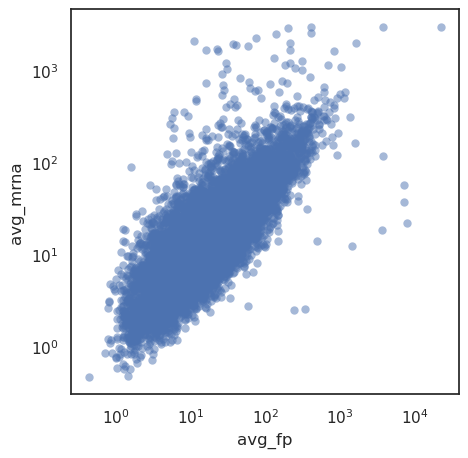

In [180]:
sns.scatterplot(data=riboseq_data, x='avg_fp', y='avg_mrna', linewidth=0, alpha=0.5)
print(stats.spearmanr(riboseq_data['avg_fp'], riboseq_data['avg_mrna']))
plt.xscale('log')
plt.yscale('log')

SignificanceResult(statistic=0.6142962598425196, pvalue=1.5797341512594542e-14)
SignificanceResult(statistic=0.4965609767529059, pvalue=2.89621873611304e-09)


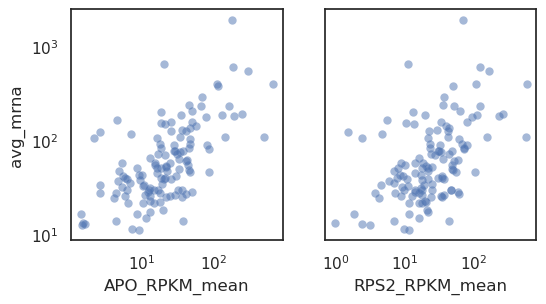

In [181]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

sns.scatterplot(data=annotated_gene_editsC_copy_ribomerge.dropna(), x='APO_RPKM_mean', y='avg_mrna', linewidth=0, alpha=0.5, ax=axes[0])
sns.scatterplot(data=annotated_gene_editsC_copy_ribomerge.dropna(), x='RPS2_RPKM_mean', y='avg_mrna', linewidth=0, alpha=0.5, ax=axes[1])


print(stats.spearmanr(annotated_gene_editsC_copy_ribomerge.dropna()['APO_RPKM_mean'], annotated_gene_editsC_copy_ribomerge.dropna()['avg_mrna']))
print(stats.spearmanr(annotated_gene_editsC_copy_ribomerge.dropna()['RPS2_RPKM_mean'], annotated_gene_editsC_copy_ribomerge.dropna()['avg_mrna']))

axes[0].set_xscale('log')
axes[1].set_xscale('log')

plt.yscale('log')

SignificanceResult(statistic=0.46480492914994526, pvalue=3.689355808002237e-08)
SignificanceResult(statistic=0.48497844019497566, pvalue=7.550879109308878e-09)


Text(0.5, 0.98, 'RPKM vs. EditsC')

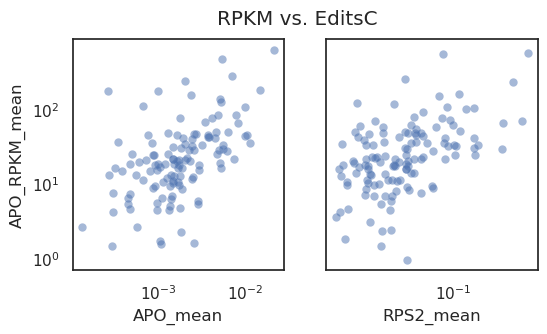

In [182]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

sns.scatterplot(data=annotated_gene_editsC_copy_ribomerge.dropna(), x='APO_mean', y='APO_RPKM_mean', linewidth=0, alpha=0.5, ax=axes[0])
sns.scatterplot(data=annotated_gene_editsC_copy_ribomerge.dropna(), x='RPS2_mean', y='RPS2_RPKM_mean', linewidth=0, alpha=0.5, ax=axes[1])


print(stats.spearmanr(annotated_gene_editsC_copy_ribomerge.dropna()['APO_mean'], annotated_gene_editsC_copy_ribomerge.dropna()['APO_RPKM_mean']))
print(stats.spearmanr(annotated_gene_editsC_copy_ribomerge.dropna()['RPS2_mean'], annotated_gene_editsC_copy_ribomerge.dropna()['RPS2_RPKM_mean']))

axes[0].set_xscale('log')
axes[1].set_xscale('log')

plt.yscale('log')
plt.suptitle('RPKM vs. EditsC')

In [183]:
annotated_gene_editsC_copy_ribomerge.columns

Index(['editsC_APO_rep1', 'editsC_APO_rep2', 'editsC_APO_rep3',
       'editsC_RPS2_rep1', 'editsC_RPS2_rep2', 'editsC_RPS2_rep3',
       'gene_name_x', 'gene_type', 'ensembl_gene_id', 'APO1_1', 'Length',
       'APO1_1_RPKM', 'RPS2_1', 'Length', 'RPS2_1_RPKM', 'APO1_2', 'Length',
       'APO1_2_RPKM', 'RPS2_2', 'Length', 'RPS2_2_RPKM', 'APO1_3', 'Length',
       'APO1_3_RPKM', 'RPS2_3', 'Length', 'RPS2_3_RPKM', 'APO_mean',
       'RPS2_mean', 'APO_RPKM_mean', 'RPS2_RPKM_mean',
       'RPS2_editsC/RPS2_RPKM_mean', 'APO_editsC/APO_RPKM_mean', 'residuals',
       'gene_name_y', 'rpkm_fp_chx__293t_calibration_rep1',
       'rpkm_fp_chx__293t_calibration_rep2', 'rpkm_mrna_293t_calibration_rep1',
       'rpkm_mrna_293t_calibration_rep2',
       'reads_fp_chx__293t_calibration_rep1',
       'reads_fp_chx__293t_calibration_rep2',
       'reads_mrna_293t_calibration_rep1', 'reads_mrna_293t_calibration_rep2',
       'avg_fp', 'avg_mrna', 'TE'],
      dtype='object')

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/sit

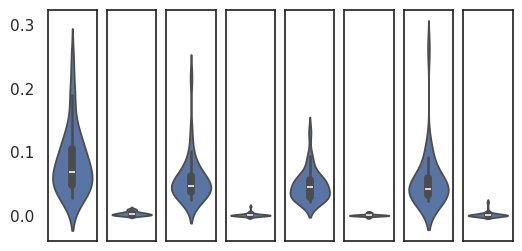

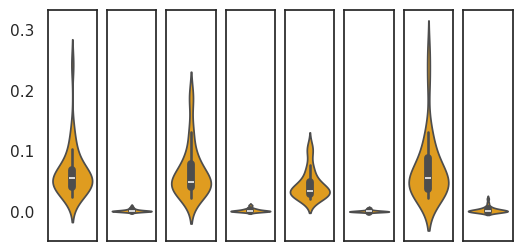

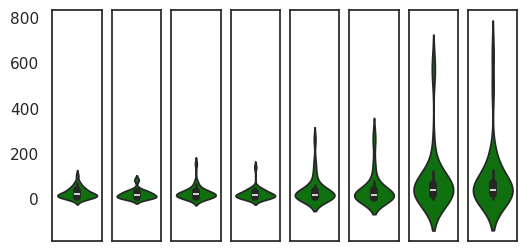

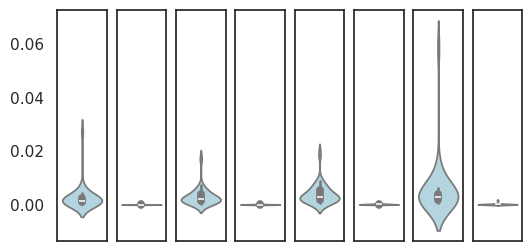

In [184]:
count = 0
fig, axes = plt.subplots(1, 8, figsize=(6, 3), sharey=True)
for i in np.array_split(annotated_gene_editsC_copy_ribomerge.sort_values(by=['avg_fp'], ascending=False), 4):
    
    sns.violinplot(pd.DataFrame(i)['RPS2_mean'].tolist(), ax=axes[count])
    sns.violinplot(pd.DataFrame(i)['APO_mean'].tolist(), ax=axes[count+1])
    count +=2
    
    
count = 0
fig, axes = plt.subplots(1, 8, figsize=(6, 3), sharey=True)
for i in np.array_split(annotated_gene_editsC_copy_ribomerge.sort_values(by=['TE'], ascending=False), 4):
    sns.violinplot(pd.DataFrame(i)['RPS2_mean'].tolist(), ax=axes[count], color='orange')
    sns.violinplot(pd.DataFrame(i)['APO_mean'].tolist(), ax=axes[count+1], color='orange')
    count +=2
    
count = 0    
fig, axes = plt.subplots(1, 8, figsize=(6, 3), sharey=True)
for i in np.array_split(annotated_gene_editsC_copy_ribomerge.sort_values(by=['TE'], ascending=False), 4):
    sns.violinplot(pd.DataFrame(i)['RPS2_RPKM_mean'].tolist(), ax=axes[count], color='green')
    sns.violinplot(pd.DataFrame(i)['APO_RPKM_mean'].tolist(), ax=axes[count+1], color='green')
    count +=2
count = 0     
fig, axes = plt.subplots(1, 8, figsize=(6, 3), sharey=True)
for i in np.array_split(annotated_gene_editsC_copy_ribomerge.sort_values(by=['TE'], ascending=True), 4):
    sns.violinplot(pd.DataFrame(i)['RPS2_editsC/RPS2_RPKM_mean'].tolist(), ax=axes[count], color='lightblue')
    sns.violinplot(pd.DataFrame(i)['APO_editsC/APO_RPKM_mean'].tolist(), ax=axes[count+1], color='lightblue')
    count +=2

SignificanceResult(statistic=0.04967664933565877, pvalue=0.579144483826811)
SignificanceResult(statistic=0.09418939820022497, pvalue=0.29219927598083845)


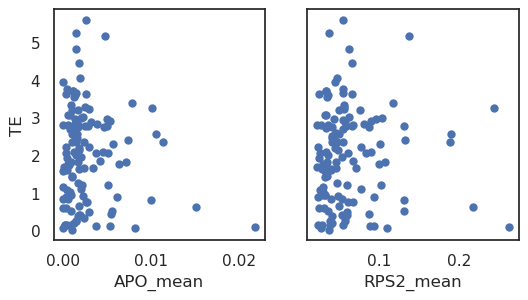

In [185]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
sns.scatterplot(data=annotated_gene_editsC_copy_ribomerge, x='APO_mean', y='TE', ax=axes[0], linewidth=0)
sns.scatterplot(data=annotated_gene_editsC_copy_ribomerge, x='RPS2_mean', y='TE', ax=axes[1], linewidth=0)
#axes[0].set_xscale('log')
#axes[1].set_xscale('log')
print(stats.spearmanr(annotated_gene_editsC_copy_ribomerge['APO_mean'], annotated_gene_editsC_copy_ribomerge['TE']))
print(stats.spearmanr(annotated_gene_editsC_copy_ribomerge['RPS2_mean'], annotated_gene_editsC_copy_ribomerge['TE']))
plt.show()

In [186]:
cell_division_genes = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/GO_term_summary_20231207_214416.txt', sep='\t')['MGI Gene/Marker ID'].tolist()
cell_division_genes = set([i.upper() for i in cell_division_genes])

SignificanceResult(statistic=0.19090909090909092, pvalue=0.5739131682855215)
SignificanceResult(statistic=0.30000000000000004, pvalue=0.37008312228206786)


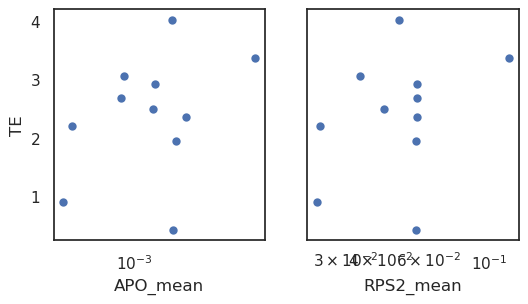

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
sns.scatterplot(data=annotated_gene_editsC_copy_ribomerge[annotated_gene_editsC_copy_ribomerge['gene_name_x'].isin(cell_division_genes)].dropna(), x='APO_mean', y='TE', ax=axes[0], linewidth=0)
sns.scatterplot(data=annotated_gene_editsC_copy_ribomerge[annotated_gene_editsC_copy_ribomerge['gene_name_x'].isin(cell_division_genes)].dropna(), x='RPS2_mean', y='TE', ax=axes[1], linewidth=0)
axes[0].set_xscale('log')
axes[1].set_xscale('log')
print(stats.spearmanr(annotated_gene_editsC_copy_ribomerge[annotated_gene_editsC_copy_ribomerge['gene_name_x'].isin(cell_division_genes)].dropna()['APO_mean'], annotated_gene_editsC_copy_ribomerge[annotated_gene_editsC_copy_ribomerge['gene_name_x'].isin(cell_division_genes)].dropna()['TE']))
print(stats.spearmanr(annotated_gene_editsC_copy_ribomerge[annotated_gene_editsC_copy_ribomerge['gene_name_x'].isin(cell_division_genes)].dropna()['RPS2_mean'], annotated_gene_editsC_copy_ribomerge[annotated_gene_editsC_copy_ribomerge['gene_name_x'].isin(cell_division_genes)].dropna()['TE']))
plt.show()

In [188]:
def annotate_sr_stamp(gtf_file_path, sr_df):
    df_gtf = pd.read_csv(gtf_file_path, sep='\t', comment='#', header=None, names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])

    # Filter for gene features
    df_gtf = df_gtf[df_gtf['feature'] == 'gene']

    # Extract gene ID, gene name, and gene type from the 'attribute' column
    df_gtf['gene_id'] = df_gtf['attribute'].str.extract('gene_id "([^"]+)"')
    df_gtf['ensembl_gene_id'] = df_gtf.apply(lambda x: x['gene_id'].split('.')[0], axis=1)
    df_gtf['gene_name'] = df_gtf['attribute'].str.extract('gene_name "([^"]+)"')
    df_gtf['gene_type'] = df_gtf['attribute'].str.extract('gene_type "([^"]+)"')

    # Create a new DataFrame with just the gene ID, gene name, and gene type
    df_genes = df_gtf[['gene_id', 'gene_name', 'gene_type', 'ensembl_gene_id']].set_index('ensembl_gene_id')
    return pd.concat([sr_df.set_index('index'), df_gtf.set_index('ensembl_gene_id')], axis=1)

In [189]:
annotated_sr_epkm = annotate_sr_stamp(gtf_file, sr_epkm)

In [190]:
sr_epkm_ribomerge = annotated_sr_epkm.merge(riboseq_data.set_index('gene'), left_on='gene_name', right_on='gene').dropna()

SignificanceResult(statistic=0.2341353607389425, pvalue=6.224758367362596e-111)


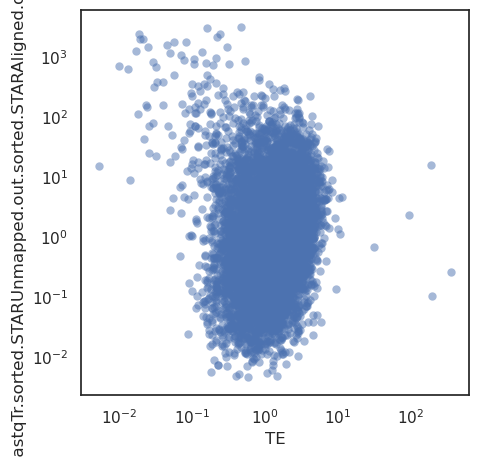

In [191]:
sns.scatterplot(data=sr_epkm_ribomerge, y='RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam.epkm.CDS.extract.tsv', x='TE', linewidth=0, alpha=0.5)
print(stats.spearmanr(sr_epkm_ribomerge['TE'], sr_epkm_ribomerge['RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam.epkm.CDS.extract.tsv']))
plt.xscale('log')
plt.yscale('log')

### Masspec

In [192]:
masspec_data = pd.read_csv(os.path.join('/tscc/nfs/home/pjaganna1/projects/STAMP/isoform_pipeline/masspec_hek/combined/txt', 'proteinGroups.txt'), sep='\t')
masspec_data_foranalysis = masspec_data[['Protein IDs', 'Peptide IDs', 'LFQ intensity SHegazi_WT1', 'LFQ intensity SHegazi_WT2', 'LFQ intensity SHegazi_WT3', 'LFQ intensity SHegazi_WT4']]

In [193]:
masspec_data_foranalysis['WT LFQ Average'] = masspec_data_foranalysis.apply(lambda x: np.mean([x['LFQ intensity SHegazi_WT1'], 
                                                                                               x['LFQ intensity SHegazi_WT2'], 
                                                                                               x['LFQ intensity SHegazi_WT3'],
                                                                                               x['LFQ intensity SHegazi_WT4']]), axis=1)

/tmp/ipykernel_4147396/1752964394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masspec_data_foranalysis['WT LFQ Average'] = masspec_data_foranalysis.apply(lambda x: np.mean([x['LFQ intensity SHegazi_WT1'],


In [194]:
masspec_data_foranalysis.head()

Protein IDs  \
0                    CON__ENSEMBL:ENSBTAP00000032840   
1                                        CON__P00761   
2                                        CON__P01966   
3  sp|P02769|ALBU_BOVIN;CON__P02769;sp|P02768|ALB...   
4                                        CON__P02777   

                                         Peptide IDs  \
0                                         9865;28252   
1                      13578;17580;20567;29330;32564   
2                                               3207   
3  4138;4234;5370;7044;11933;12073;15940;17611;18...   
4                                        11778;12597   

   LFQ intensity SHegazi_WT1  LFQ intensity SHegazi_WT2  \
0                          0                   47726000   
1                 6630000000                 5942900000   
2                          0                          0   
3                  177590000                  294060000   
4                  557020000                  988800000   

   LFQ intensity SHegazi_WT3  LFQ intensity SHegazi_WT4  WT LFQ Average  
0                          0                          0    1.193150e+07  
1                 6664700000                 4943600000    6.045300e+09  
2                          0                   17523000    4.380750e+06  
3                  137580000                  436630000    2.614650e+08  
4                  629820000                 1525900000    9.253850e+08

In [195]:
masspec_data_foranalysis_cp = masspec_data_foranalysis.copy()

In [196]:
def get_protein_name(df):
    protein_id = df['Protein IDs']
    if len(protein_id.split(';'))==1:
        if '_HUMAN' in protein_id:
            return protein_id.split('|')[2].strip('_HUMAN')
    else:
        return None
masspec_data_foranalysis['Protein Name'] = masspec_data_foranalysis.apply(get_protein_name, axis=1)

/tmp/ipykernel_4147396/188340865.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masspec_data_foranalysis['Protein Name'] = masspec_data_foranalysis.apply(get_protein_name, axis=1)


In [197]:
masspec_data_foranalysis = masspec_data_foranalysis.dropna(subset=['Protein Name'])

In [198]:
masspec_data_foranalysis.head()

Protein IDs Peptide IDs  LFQ intensity SHegazi_WT1  \
16  REV__sp|A0AVI2|FR1L5_HUMAN        8811                          0   
17  REV__sp|A8MXQ7|YH010_HUMAN       18874                          0   
18  REV__sp|O00458|IFRD1_HUMAN  7843;27401                          0   
20  REV__sp|O15015|ZN646_HUMAN       24807                  496540000   
24   REV__sp|P10124|SRGN_HUMAN       14179                          0   

    LFQ intensity SHegazi_WT2  LFQ intensity SHegazi_WT3  \
16                          0                          0   
17                  151570000                  123550000   
18                          0                          0   
20                  604250000                  581810000   
24                          0                  107500000   

    LFQ intensity SHegazi_WT4  WT LFQ Average Protein Name  
16                   72068000      18017000.0        FR1L5  
17                          0      68780000.0        YH010  
18                   86668000      21667000.0        IFRD1  
20                  574890000     564372500.0        ZN646  
24                          0      26875000.0          SRG

In [199]:
masspec_data_sorted=masspec_data_foranalysis.sort_values('WT LFQ Average', ascending=False)

In [200]:
masspec_stamp_merge = significant_signal.merge(masspec_data_sorted, left_on='gene_name', right_on='Protein Name')

In [201]:
masspec_stamp_merge.dropna().head()

editsC_APO_rep1  editsC_APO_rep2  editsC_APO_rep3  editsC_RPS2_rep1  \
0         0.001575         0.000000         0.001575          0.048819   
1         0.001436         0.001436         0.000000          0.045944   
2         0.001669         0.001669         0.004174          0.065943   
3         0.001934         0.001934         0.000000          0.042553   
4         0.001302         0.000651         0.001302          0.049479   

   editsC_RPS2_rep2  editsC_RPS2_rep3 gene_name       gene_type  \
0          0.031496          0.055118     TTC27  protein_coding   
1          0.039483          0.011486       ZFR  protein_coding   
2          0.068447          0.040902     CCAR1  protein_coding   
3          0.038685          0.040619      PCNP  protein_coding   
4          0.040365          0.013021     IPO11  protein_coding   

   ensembl_gene_id  APO1_1  ...  APO_editsC/APO_RPKM_mean  residuals  \
0  ENSG00000018699    67.0  ...                  0.000621   0.027794   
1  ENSG00000056097    69.0  ...                  0.000218   0.015966   
2  ENSG00000060339   163.0  ...                  0.000200   0.025205   
3  ENSG00000081154   162.0  ...                  0.000026   0.020653   
4  ENSG00000086200    69.0  ...                  0.000707   0.016554   

             Protein IDs                                        Peptide IDs  \
0  sp|Q6P3X3|TTC27_HUMAN              1851;4556;5784;5826;22519;23322;25871   
1    sp|Q96KR1|ZFR_HUMAN  1530;2308;3663;3824;4908;10323;10885;11462;164...   
2  sp|Q8IX12|CCAR1_HUMAN  1171;4785;8468;14488;14582;18844;20037;20703;2...   
3   sp|Q8WW12|PCNP_HUMAN                                    1046;7578;27122   
4  sp|Q9UI26|IPO11_HUMAN  1168;1982;4970;6072;20932;21624;22905;23591;23...   

   LFQ intensity SHegazi_WT1  LFQ intensity SHegazi_WT2  \
0                  405610000                  407560000   
1                  354680000                  408810000   
2                  856610000                  848920000   
3                   97904000                  102220000   
4                  187430000                  165410000   

   LFQ intensity SHegazi_WT3  LFQ intensity SHegazi_WT4  WT LFQ Average  \
0                  248470000                  315200000     344210000.0   
1                  377670000                  347780000     372235000.0   
2                  809960000                  667350000     795710000.0   
3                          0                          0      50031000.0   
4                  270850000                  204810000     207125000.0   

   Protein Name  
0         TTC27  
1           ZFR  
2         CCAR1  
3          PCNP  
4         IPO11  

[5 rows x 42 columns]

APO SignificanceResult(statistic=0.407431812734692, pvalue=0.00547147350597376)
RPS2 SignificanceResult(statistic=0.2902503293807641, pvalue=0.053096923955080824)


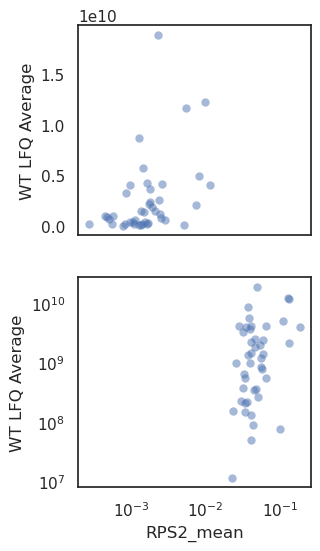

In [202]:
fig, axes = plt.subplots(2, 1, figsize=(3, 6), sharex=True)

sns.scatterplot(data=masspec_stamp_merge, x='APO_mean', y='WT LFQ Average', linewidth=0, alpha=0.5, ax=axes[0])
sns.scatterplot(data=masspec_stamp_merge, x='RPS2_mean', y='WT LFQ Average', linewidth=0, alpha=0.5, ax=axes[1])

print('APO', stats.spearmanr(masspec_stamp_merge.dropna()['APO_mean'], masspec_stamp_merge.dropna()['WT LFQ Average']))
print('RPS2', stats.spearmanr(masspec_stamp_merge.dropna()['RPS2_mean'], masspec_stamp_merge.dropna()['WT LFQ Average']))
#plt.legend(['APO', 'RPS2'])
axes[0].set_xscale('log')
axes[1].set_xscale('log')

plt.yscale('log')

In [203]:
riboseq_masspec = riboseq_data.merge(masspec_data_sorted, left_on='gene', right_on='Protein Name').dropna()

SignificanceResult(statistic=0.08884328240854243, pvalue=0.0005293008797554974)


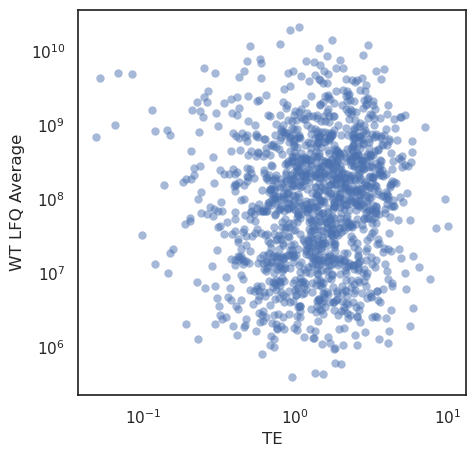

In [204]:
sns.scatterplot(data=riboseq_masspec, x='TE', y='WT LFQ Average', linewidth=0, alpha=0.5)
print(stats.spearmanr(riboseq_masspec.dropna()['TE'], riboseq_masspec.dropna()['WT LFQ Average']))
plt.xscale('log')
plt.yscale('log')

In [205]:
annotated_transcript_editsC = annotate_dataframe_with_transcript_info(transcript_editsC, gtf_file)

In [206]:
for key in transcript_counts:
    annotated_transcript_editsC = pd.concat([annotated_transcript_editsC, transcript_counts[key]], axis=1)

In [207]:
#transcript_counts

In [208]:
def add_zero_edits_transcript(df):
    for rep in ['1', '2', '3']:
        df.loc[~df[f'APO1_{rep}_count'].isna() & df[f'editsC_APO_rep{rep}'].isna(), f'editsC_APO_rep{rep}'] = 0
        df.loc[~df[f'RPS2_{rep}_count'].isna()& df[f'editsC_RPS2_rep{rep}'].isna(), f'editsC_RPS2_rep{rep}'] = 0
        
    return df

In [209]:
add_zero_edits_transcript(annotated_transcript_editsC)

editsC_APO_rep1  editsC_APO_rep2  editsC_APO_rep3  \
transcript_id                                                          
ENST00000000412.3         0.001131         0.000000         0.000000   
ENST00000001008.4         0.001520         0.001520         0.003040   
ENST00000002165.6         0.002924         0.001462         0.000000   
ENST00000005340.5         0.000650         0.000000         0.001951   
ENST00000008527.5         0.002125         0.000000         0.000000   
...                            ...              ...              ...   
ENST00000266458.5              NaN              NaN              NaN   
ENST00000398073.2              NaN              NaN              NaN   
ENST00000268483.3              NaN              NaN              NaN   
ENST00000397554.1              NaN              NaN              NaN   
ENST00000215941.4              NaN              NaN              NaN   

                   editsC_RPS2_rep1  editsC_RPS2_rep2  editsC_RPS2_rep3  \
transcript_id                                                             
ENST00000000412.3          0.004525          0.006787          0.001131   
ENST00000001008.4          0.027356          0.028875          0.027356   
ENST00000002165.6          0.004386          0.017544          0.021930   
ENST00000005340.5          0.000650          0.001951          0.005202   
ENST00000008527.5          0.019129          0.012752          0.011690   
...                             ...               ...               ...   
ENST00000266458.5               NaN               NaN          0.000000   
ENST00000398073.2               NaN               NaN          0.000000   
ENST00000268483.3               NaN               NaN          0.000000   
ENST00000397554.1               NaN               NaN          0.000000   
ENST00000215941.4               NaN               NaN          0.000000   

                  gene_name transcript_type  APO1_1_count    Length  ...  \
transcript_id                                                        ...   
ENST00000000412.3      M6PR  protein_coding          34.0    9590.0  ...   
ENST00000001008.4     FKBP4  protein_coding         113.0    9005.0  ...   
ENST00000002165.6     FUCA2  protein_coding          45.0   16879.0  ...   
ENST00000005340.5      DVL2  protein_coding          23.0    9204.0  ...   
ENST00000008527.5      CRY1  protein_coding          75.0  102465.0  ...   
...                     ...             ...           ...       ...  ...   
ENST00000266458.5       NaN             NaN           NaN       NaN  ...   
ENST00000398073.2       NaN             NaN           NaN       NaN  ...   
ENST00000268483.3       NaN             NaN           NaN       NaN  ...   
ENST00000397554.1       NaN             NaN           NaN       NaN  ...   
ENST00000215941.4       NaN             NaN           NaN       NaN  ...   

                   APO1_2_RPKM  RPS2_2_count    Length  RPS2_2_RPKM  \
transcript_id                                                         
ENST00000000412.3    16.016290          31.0    9590.0    19.855615   
ENST00000001008.4    69.539142          47.0    9005.0    32.059327   
ENST00000002165.6    13.999756          30.0   16879.0    10.917289   
ENST00000005340.5    16.046140           NaN       NaN          NaN   
ENST00000008527.5     2.767406          69.0  102465.0     4.136317   
...                        ...           ...       ...          ...   
ENST00000266458.5          NaN           NaN       NaN          NaN   
ENST00000398073.2          NaN           NaN       NaN          NaN   
ENST00000268483.3          NaN           NaN       NaN          NaN   
ENST00000397554.1          NaN           NaN       NaN          NaN   
ENST00000215941.4          NaN           NaN       NaN          NaN   

                   APO1_3_count    Length  APO1_3_RPKM  RPS2_3_count  \
transcript_id                                                          
ENST00000000412.3          35.0    9590.0    25.3

In [210]:
annotated_transcript_editsC.columns

Index(['editsC_APO_rep1', 'editsC_APO_rep2', 'editsC_APO_rep3',
       'editsC_RPS2_rep1', 'editsC_RPS2_rep2', 'editsC_RPS2_rep3', 'gene_name',
       'transcript_type', 'APO1_1_count', 'Length', 'APO1_1_RPKM',
       'RPS2_1_count', 'Length', 'RPS2_1_RPKM', 'APO1_2_count', 'Length',
       'APO1_2_RPKM', 'RPS2_2_count', 'Length', 'RPS2_2_RPKM', 'APO1_3_count',
       'Length', 'APO1_3_RPKM', 'RPS2_3_count', 'Length', 'RPS2_3_RPKM'],
      dtype='object')

In [211]:
annotated_transcript_editsC['APO_mean'] = annotated_transcript_editsC.apply(calculate_mean_apo, axis=1)

In [212]:
annotated_transcript_editsC['RPS2_mean'] = annotated_transcript_editsC.apply(calculate_mean_rps2, axis=1)

In [213]:
annotated_transcript_editsC['shortened_transcript_id'] = annotated_transcript_editsC.apply(lambda x: x.name.split('.')[0], axis=1)

In [214]:
annotated_transcript_editsC['APO_RPKM_mean'] = annotated_transcript_editsC.apply(lambda x: np.mean([x['APO1_1_RPKM'], x['APO1_2_RPKM'], x['APO1_3_RPKM']]), axis=1)
annotated_transcript_editsC['RPS2_RPKM_mean']= annotated_transcript_editsC.apply(lambda x: np.mean([x['RPS2_1_RPKM'], x['RPS2_2_RPKM'], x['RPS2_3_RPKM']]), axis=1)

In [215]:
annotated_transcript_editsC.dropna().head()

editsC_APO_rep1  editsC_APO_rep2  editsC_APO_rep3  \
transcript_id                                                          
ENST00000000412.3         0.001131         0.000000          0.00000   
ENST00000001008.4         0.001520         0.001520          0.00304   
ENST00000008527.5         0.002125         0.000000          0.00000   
ENST00000066544.3         0.002530         0.000843          0.00000   
ENST00000081029.3         0.005291         0.000000          0.00000   

                   editsC_RPS2_rep1  editsC_RPS2_rep2  editsC_RPS2_rep3  \
transcript_id                                                             
ENST00000000412.3          0.004525          0.006787          0.001131   
ENST00000001008.4          0.027356          0.028875          0.027356   
ENST00000008527.5          0.019129          0.012752          0.011690   
ENST00000066544.3          0.004216          0.010961          0.005059   
ENST00000081029.3          0.021164          0.021164          0.029101   

                  gene_name transcript_type  APO1_1_count    Length  ...  \
transcript_id                                                        ...   
ENST00000000412.3      M6PR  protein_coding          34.0    9590.0  ...   
ENST00000001008.4     FKBP4  protein_coding         113.0    9005.0  ...   
ENST00000008527.5      CRY1  protein_coding          75.0  102465.0  ...   
ENST00000066544.3     CDC27  protein_coding          55.0   71563.0  ...   
ENST00000081029.3    MRPS35  protein_coding          31.0   45522.0  ...   

                     Length  APO1_3_RPKM  RPS2_3_count    Length  RPS2_3_RPKM  \
transcript_id                                                                   
ENST00000000412.3    9590.0    25.364239          35.0    9590.0    19.479889   
ENST00000001008.4    9005.0    94.156113          88.0    9005.0    52.159808   
ENST00000008527.5  102465.0     1.831305          73.0  102465.0     3.802632   
ENST00000066544.3   71563.0     2.136518          25.0   71563.0     1.864612   
ENST00000081029.3   45522.0     3.664058          38.0   45522.0     4.455529   

                   APO_mean  RPS2_mean  shortened_transcript_id  \
transcript_id                                                     
ENST00000000412.3  0.000377   0.004148          ENST00000000412   
ENST00000001008.4  0.002026   0.027862          ENST00000001008   
ENST00000008527.5  0.000708   0.014524          ENST00000008527   
ENST00000066544.3  0.001124   0.006745          ENST00000066544   
ENST00000081029.3  0.001764   0.023810          ENST00000081029   

                   APO_RPKM_mean  RPS2_RPKM_mean  
transcript_id                                     
ENST00000000412.3      19.926767       18.342747  
ENST00000001008.4      76.273372       32.947436  
ENST00000008527.5       2.799145        4.421031  
ENST00000066544.3       3.335012        2.970785  
ENST00000081029.3       3.913446        4.169106  

[5 rows x 31 columns]

<Axes: xlabel='RPS2_mean', ylabel='Count'>

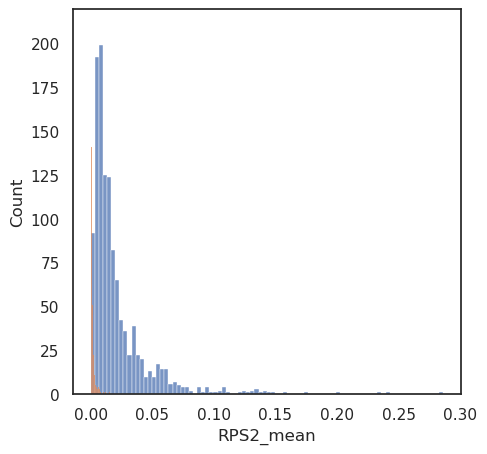

In [216]:
sns.histplot(annotated_transcript_editsC.dropna()['RPS2_mean'])
sns.histplot(annotated_transcript_editsC.dropna()['APO_mean'])

In [217]:
transcripts_per_gene_df = pd.DataFrame(annotated_transcript_editsC.dropna()['gene_name'].value_counts())

In [218]:
annotated_transcript_editsC.dropna()['transcript_type'].value_counts()

transcript_type
protein_coding             1201
nonsense_mediated_decay       3
Name: count, dtype: int64

In [219]:
annotated_transcript_editsC_lm = annotated_transcript_editsC.copy().dropna()

In [220]:
X_transcript = sm.add_constant(annotated_transcript_editsC_lm['APO_mean'])  # adding a constant for the intercept
y_transcript = annotated_transcript_editsC_lm['RPS2_mean']

# Fit a linear regression model using APO_mean as the predictor and RPS2_mean as the response variable
model_linear_transcript = sm.OLS(y_transcript, X_transcript).fit()

# Calculate the residuals
annotated_transcript_editsC_lm['residuals'] = model_linear_transcript.resid

# Identify significant residuals
# For this example, let's consider residuals that are greater than 1 standard deviation from the mean as significant
mean_residual_transcript = annotated_transcript_editsC_lm['residuals'].mean()
std_residual_transcript = annotated_transcript_editsC_lm['residuals'].std()
threshold_transcript = mean_residual_transcript + std_residual_transcript

# Find data points where the signal is significantly greater than the background
significant_signal_transcript = annotated_transcript_editsC_lm[annotated_transcript_editsC_lm['residuals'] > threshold]

# Display the results
model_linear_transcript.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              RPS2_mean   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     2398.
Date:                Fri, 19 Jan 2024   Prob (F-statistic):          1.41e-288
Time:                        00:27:56   Log-Likelihood:                 3324.0
No. Observations:                1204   AIC:                            -6644.
Df Residuals:                    1202   BIC:                            -6634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.001     12.092      0.000       0.005       0.008
APO_mean      10.9756      0.224     48.967      0.000      10.536      11.415
==============================================================================
Omnibus:                      447.517   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5190.935
Skew:                           1.379   Prob(JB):                         0.00
Kurtosis:                      12.791   Cond. No.                         508.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [221]:
annotated_transcript_editsC_lm['sig'] = annotated_transcript_editsC_lm['gene_name'].isin(significant_signal_transcript['gene_name'].tolist())

/tmp/ipykernel_4147396/2669255943.py:3: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(x='APO_mean', y='RPS2_mean', data=annotated_transcript_editsC_lm, palette=custom_palette, linewidth=0, alpha=0.5, hue='sig')


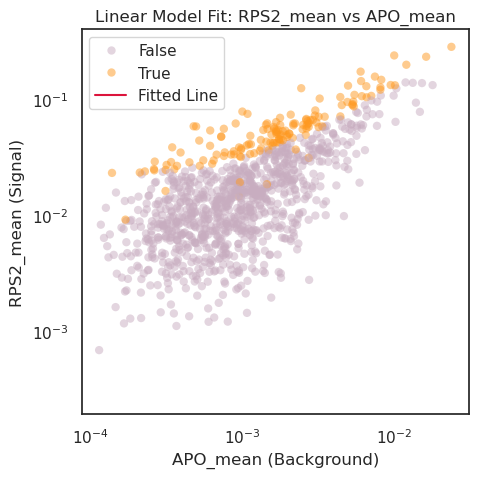

In [222]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style('white')
sns.scatterplot(x='APO_mean', y='RPS2_mean', data=annotated_transcript_editsC_lm, palette=custom_palette, linewidth=0, alpha=0.5, hue='sig')

# Predicted values from the linear model
predicted_values_transcript = model_linear_transcript.predict(X)

# Plotting the regression line
sns.lineplot(x=annotated_transcript_editsC_lm['APO_mean'], y=predicted_values_transcript, color='crimson', label='Fitted Line')

plt.title('Linear Model Fit: RPS2_mean vs APO_mean')
plt.xlabel('APO_mean (Background)')
plt.ylabel('RPS2_mean (Signal)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.savefig(os.path.join(fig_path,'sup2/transcript_lm.png'))
# plt.savefig(os.path.join(fig_path,'sup2/transcript_lm.svg'))
# plt.savefig(os.path.join(fig_path,'sup2/transcript_lm.jpg'))
plt.show()

In [223]:
five_UTR_seq_annotation = pd.read_csv('5UTR_gtf_seq_annotation.txt', sep='\t')

In [224]:
five_UTR_seq_top_present = set(five_UTR_seq_annotation[five_UTR_seq_annotation['five_top_motif']==True]['transcript_id'].tolist())

In [225]:
five_UTR_seq_top_absent = set(five_UTR_seq_annotation[five_UTR_seq_annotation['five_top_motif']==False]['transcript_id'].tolist())

299
8711


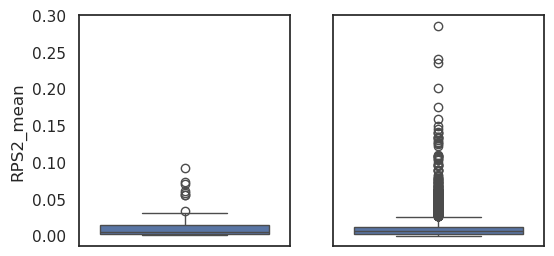

In [226]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

sns.boxplot(annotated_transcript_editsC[annotated_transcript_editsC.index.isin(five_UTR_seq_top_present)]['RPS2_mean'], ax=axes[0])
print(annotated_transcript_editsC[annotated_transcript_editsC.index.isin(five_UTR_seq_top_present)].shape[0])
sns.boxplot(annotated_transcript_editsC[annotated_transcript_editsC.index.isin(five_UTR_seq_top_absent)]['RPS2_mean'], ax=axes[1])
print(annotated_transcript_editsC[annotated_transcript_editsC.index.isin(five_UTR_seq_top_absent)].shape[0])

299
8711


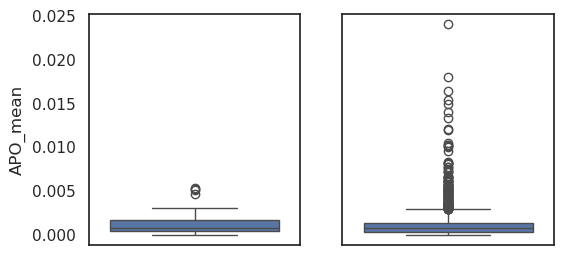

In [227]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

sns.boxplot(annotated_transcript_editsC[annotated_transcript_editsC.index.isin(five_UTR_seq_top_present)]['APO_mean'], ax=axes[0])
print(annotated_transcript_editsC[annotated_transcript_editsC.index.isin(five_UTR_seq_top_present)].shape[0])
sns.boxplot(annotated_transcript_editsC[annotated_transcript_editsC.index.isin(five_UTR_seq_top_absent)]['APO_mean'], ax=axes[1])
print(annotated_transcript_editsC[annotated_transcript_editsC.index.isin(five_UTR_seq_top_absent)].shape[0])

In [228]:
#annotated_transcript_editsC_lm.to_csv('annotated_transcript_editsC_lm_dec2023.txt', sep='\t')

In [229]:
low_translation_transcript = np.array_split(annotated_transcript_editsC.sort_values('RPS2_mean'), 4)[0].index.tolist()
high_translation_transcript = np.array_split(annotated_transcript_editsC.sort_values('RPS2_mean'), 4)[3].index.tolist()

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [220]:
def make_transcript_fasta_dict(file_path):
    """
    Reads a FASTA file using Bio.SeqIO and returns a dictionary where the keys are the transcript identifiers
    and the values are the corresponding sequences.

    :param file_path: Path to the FASTA file
    :return: Dictionary with transcript identifiers as keys and sequences as values
    """
    sequences = {}
    with open(file_path, 'r') as fasta_file:
        for record in SeqIO.parse(fasta_file, "fasta"):
            sequences[record.id.split('|')[0]] = str(record.seq)
    return sequences

transcript_fasta_file_path = '/tscc/nfs/home/pjaganna1/projects/genomes/hg19/gencode.v19.pc_transcripts.fa'
transcripts_sequence_dict = make_transcript_fasta_dict(transcript_fasta_file_path)

In [221]:
def get_gc_content(transcripts, seq_dict):
    gc_content = []
    for t in transcripts:
        if t in seq_dict:
            seq = seq_dict[t]
            gc_content.append((seq.count('G') + seq.count('C'))/(seq.count('A') + seq.count('T') + seq.count('G') + seq.count('C')))
        # else:
        #     print(t)
    return gc_content

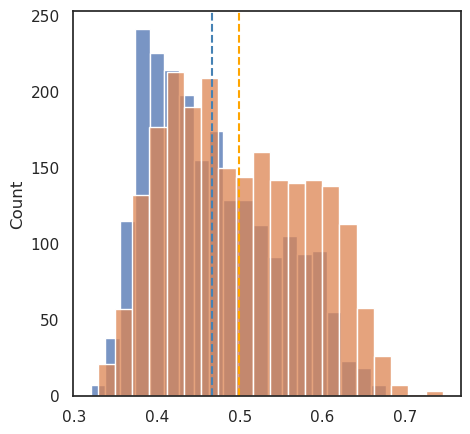

In [332]:
sns.histplot(get_gc_content(low_translation_transcript, transcripts_sequence_dict))
sns.histplot(get_gc_content(high_translation_transcript, transcripts_sequence_dict))
plt.axvline(np.mean(get_gc_content(low_translation_transcript, transcripts_sequence_dict)), linestyle='dashed', color='steelblue')
plt.axvline(np.mean(get_gc_content(high_translation_transcript, transcripts_sequence_dict)), linestyle='dashed', color='orange')


In [214]:
#multiple_transcript_genes_df.dropna().to_csv('multiple_transcripts_RPS2_APO_edits.txt', sep='\t')

In [222]:
multiple_transcript_genes_df.head()

NameError: name 'multiple_transcript_genes_df' is not defined

In [ ]:
multiple_transcript_genes_df['iso_group'] = ['A', 'B']* int(multiple_transcript_genes_df.shape[0]/2)

In [ ]:
multiple_transcript_genes_df = multiple_transcript_genes_df[multiple_transcript_genes_df['iso_group']=='A'].merge(multiple_transcript_genes_df[multiple_transcript_genes_df['iso_group']=='B'], on='gene_name', suffixes=['_A', '_B']).set_index('gene_name')

In [ ]:
multiple_transcript_genes_df_cols = [i for i in multiple_transcript_genes_df.columns if 'editsC' in i]

In [ ]:
multiple_transcript_genes_df[['APO_mean_A', 'RPS2_mean_A', 'APO_mean_B', 'RPS2_mean_B']].head()

In [ ]:
multiple_transcript_genes_df_toplot = multiple_transcript_genes_df[multiple_transcript_genes_df_cols[:3] + multiple_transcript_genes_df_cols[6:9] + multiple_transcript_genes_df_cols[3:6]  + multiple_transcript_genes_df_cols[9:]]

In [ ]:
sns.clustermap(data=multiple_transcript_genes_df[multiple_transcript_genes_df_cols[:3] + multiple_transcript_genes_df_cols[6:9] + multiple_transcript_genes_df_cols[3:6]  + multiple_transcript_genes_df_cols[9:]], col_cluster=False, cmap='cividis')


In [289]:
viz_out = '/tscc/nfs/home/pjaganna1/scratch/sshfs_connect'

In [230]:
gname = 'PCNP'

In [291]:
gname = 'PCNP'
for i in ['ENST00000460231.1', 'ENST00000265260.3']:
    for rep in ['rep1', 'rep2', 'rep3']:
        keep_edits_apo[rep][keep_edits_apo[rep]['transcript_id']==i][[0,1,2,3,4,5]].to_csv(os.path.join(viz_out,f'CDS_{gname}_apo_{rep}_{i}_.bed'), sep='\t', header=None, index=False)
        keep_edits_rps2[rep][keep_edits_rps2[rep]['transcript_id']==i][[0,1,2,3,4,5]].to_csv(os.path.join(viz_out,f'CDS_{gname}_rps2_{rep}_{i}.bed'), sep='\t', header=None, index=False)
        

In [292]:
infile = os.path.join(working_dir, f'{sample_dict_apo["rep1"]}/output_dir/split_bam_{sample_dict_apo["rep1"]}')
split_dictionary = pd.read_pickle(infile)

In [293]:
viz_out = '/tscc/nfs/home/pjaganna1/scratch/sshfs_connect'
gname = 'PCNP'
print('#!/bin/bash')
print()
print('module load samtools')
for i in ['ENST00000460231.1', 'ENST00000265260.3']:
    for rep in ['rep1', 'rep2', 'rep3']:
        keep_edits_apo[rep][keep_edits_apo[rep]['transcript_id']==i][[0,1,2,3,4,5]].to_csv(os.path.join(viz_out,f'CDS_{gname}_apo_{rep}_{i}_.bed'), sep='\t', header=None, index=False)
        keep_edits_rps2[rep][keep_edits_rps2[rep]['transcript_id']==i][[0,1,2,3,4,5]].to_csv(os.path.join(viz_out,f'CDS_{gname}_rps2_{rep}_{i}.bed'), sep='\t', header=None, index=False)
for sample_dict in [sample_dict_apo, sample_dict_rps2]:
    for rep in ['rep1', 'rep2', 'rep3']:
        infile = os.path.join(working_dir, f'{sample_dict[rep]}/output_dir/split_bam_{sample_dict[rep]}')
        split_dictionary = pd.read_pickle(infile)
        for i in ['ENST00000460231.1', 'ENST00000265260.3']:
            for s in split_dictionary:
                if i in split_dictionary[s]['isoform'].tolist():
                    print("cp " + os.path.join(working_dir, f'{sample_dict[rep]}/output_dir/{s}.sorted.bam ') + '/tscc/nfs/home/pjaganna1/scratch/sshfs_connect/' + f'CDS_{gname}_{sample_dict[rep]}_{i}.sorted.bam')
                    print('samtools index ' + '/tscc/nfs/home/pjaganna1/scratch/sshfs_connect/' + f'CDS_{gname}_{sample_dict[rep]}_{i}.sorted.bam')

print('module unload samtools')


#!/bin/bash

module load samtools
cp /tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/APO1_1/output_dir/split_bam_1_79.sorted.bam /tscc/nfs/home/pjaganna1/scratch/sshfs_connect/CDS_PCNP_APO1_1_ENST00000460231.1.sorted.bam
samtools index /tscc/nfs/home/pjaganna1/scratch/sshfs_connect/CDS_PCNP_APO1_1_ENST00000460231.1.sorted.bam
cp /tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/APO1_1/output_dir/split_bam_4_0.sorted.bam /tscc/nfs/home/pjaganna1/scratch/sshfs_connect/CDS_PCNP_APO1_1_ENST00000265260.3.sorted.bam
samtools index /tscc/nfs/home/pjaganna1/scratch/sshfs_connect/CDS_PCNP_APO1_1_ENST00000265260.3.sorted.bam
cp /tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/APO1_2/output_dir/split_bam_4_1.sorted.bam /tscc/nfs/home/pjaganna1/scratch/sshfs_connect/CDS_PCNP_APO1_2_ENST00000460231.1.sorted.bam
samtools index /tscc/nfs/home/pjaganna1/scratch/sshfs_connect/CDS_PCNP_APO1_2_ENST00000460231.1.sorted.bam
cp /tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipe

In [232]:
import itertools

In [233]:
gene_toplot = annotated_transcript_editsC[(annotated_transcript_editsC['gene_name']=='PCNP') & (annotated_transcript_editsC.index.isin(['ENST00000460231.1', 'ENST00000265260.3']))]

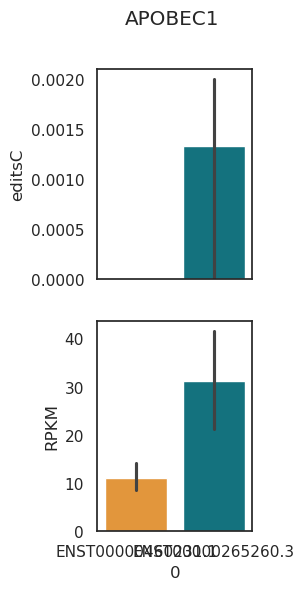

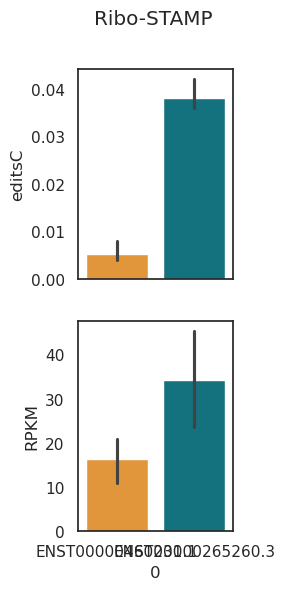

In [234]:
for i in list(itertools.combinations(['ENST00000460231.1', 'ENST00000265260.3'], 2)):
    i1 = i[0]
    i2 = i[1]
    fig, axes = plt.subplots(2,1, sharey=False, figsize=(2,6),sharex=True)
    sns.barplot(pd.DataFrame([[f'{i[0]}', gene_toplot.loc[i[0],'editsC_APO_rep1'], gene_toplot.loc[i[0],'editsC_APO_rep2'],gene_toplot.loc[i[0],'editsC_APO_rep3']], [f'{i[1]}', gene_toplot.loc[i[1],'editsC_APO_rep1'], gene_toplot.loc[i[1],'editsC_APO_rep2'], gene_toplot.loc[i[1],'editsC_APO_rep3']]]).set_index(0).T, ax=axes[0], palette=['#FE9920', '#028090'])
    sns.barplot(pd.DataFrame([[f'{i[0]}', gene_toplot.loc[i[0],'APO1_1_RPKM'], gene_toplot.loc[i[0],'APO1_2_RPKM'],gene_toplot.loc[i[0],'APO1_3_RPKM']], [f'{i[1]}', gene_toplot.loc[i[1],'APO1_1_RPKM'], gene_toplot.loc[i[1],'APO1_2_RPKM'], gene_toplot.loc[i[1],'APO1_3_RPKM']]]).set_index(0).T, ax=axes[1], palette=['#FE9920', '#028090'])
    fig.suptitle(f'{gname} {i}')
    axes[0].set_ylabel('editsC')
    axes[1].set_ylabel('RPKM')
    plt.suptitle('APOBEC1')
    plt.savefig(os.path.join(fig_path,'fig3/PCNP_APOBEC1.png'))
    plt.savefig(os.path.join(fig_path,'fig3/PCNP_APOBEC1.svg'))
    plt.savefig(os.path.join(fig_path,'fig3/PCNP_APOBEC1.jpg'))
    plt.show()

    fig, axes = plt.subplots(2, 1, sharey=False, figsize=(2,6),sharex=True)
    sns.barplot(pd.DataFrame([[f'{i[0]}', gene_toplot.loc[i[0],'editsC_RPS2_rep1'], gene_toplot.loc[i[0],'editsC_RPS2_rep2'],gene_toplot.loc[i[0],'editsC_RPS2_rep3']], [f'{i[1]}', gene_toplot.loc[i[1],'editsC_RPS2_rep1'], gene_toplot.loc[i[1],'editsC_RPS2_rep2'], gene_toplot.loc[i[1],'editsC_RPS2_rep3']]]).set_index(0).T, ax=axes[0], palette=['#FE9920', '#028090'])
    sns.barplot(pd.DataFrame([[f'{i[0]}', gene_toplot.loc[i[0],'RPS2_1_RPKM'], gene_toplot.loc[i[0],'RPS2_2_RPKM'],gene_toplot.loc[i[0],'RPS2_3_RPKM']], [f'{i[1]}', gene_toplot.loc[i[1],'RPS2_1_RPKM'], gene_toplot.loc[i[1],'RPS2_2_RPKM'], gene_toplot.loc[i[1],'RPS2_3_RPKM']]]).set_index(0).T, ax=axes[1], palette=['#FE9920', '#028090'])
    axes[0].set_ylabel('editsC')
    axes[1].set_ylabel('RPKM')
    plt.suptitle('Ribo-STAMP')
    plt.savefig(os.path.join(fig_path,'fig3/PCNP_RiboSTAMP.png'))
    plt.savefig(os.path.join(fig_path,'fig3/PCNP_RiboSTAMP.svg'))
    plt.savefig(os.path.join(fig_path,'fig3/PCNP_RiboSTAMP.jpg'))

In [227]:
trip = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/polysome_profiling_Sept2021/TRIPseq/GSE69352_tripseq_isoform_tpm_ensembl_v75.csv')

In [228]:
trip = trip[['gene_name', 'gene_id', 'gene_biotype', 'isoform_id', 'isoform_biotype','poly2_1', 'poly2_2', 'poly3_1','poly3_2', 'poly4_1', 'poly4_2', 'poly5_1', 'poly5_2', 'poly6_1','poly6_2', 'poly7_1', 'poly7_2', 'poly8_1', 'poly8_2']]

In [229]:
trip.head()

gene_name          gene_id gene_biotype       isoform_id isoform_biotype  \
0   5S_rRNA  ENSG00000201285         rRNA  ENST00000364415            rRNA   
1   5S_rRNA  ENSG00000212595         rRNA  ENST00000391293            rRNA   
2   5S_rRNA  ENSG00000238602         rRNA  ENST00000458901            rRNA   
3   5S_rRNA  ENSG00000238762         rRNA  ENST00000458805            rRNA   
4   5S_rRNA  ENSG00000239156         rRNA  ENST00000459052            rRNA   

   poly2_1  poly2_2  poly3_1  poly3_2  poly4_1  poly4_2  poly5_1  poly5_2  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   poly6_1  poly6_2  poly7_1  poly7_2  poly8_1  poly8_2  
0      0.0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      0.0      0.0      0.0  
4      0.0      0.0      0.0      0.0      0.0      0.0

In [230]:
def categorize_isoform(d):

    find_max = {'poly2':np.mean([d['poly2_1'],d['poly2_2']]), 'poly3':np.mean([d['poly3_1'],d['poly3_2']]), 'poly4':np.mean([d['poly4_1'],d['poly4_2']]), 'poly5':np.mean([d['poly5_1'],d['poly5_2']]), 'poly6':np.mean([d['poly6_1'],d['poly6_2']]), 'poly7':np.mean([d['poly7_1'],d['poly7_2']]), 'poly8':np.mean([d['poly8_1'],d['poly8_2']])}
    if find_max[max(find_max, key=find_max.get)] != 0:
        # if max(find_max, key=find_max.get) in ['poly2','poly3'] : #['poly2','poly3','poly4']:
        #     return 'low'
        # elif max(find_max, key=find_max.get) in ['poly7','poly8']:#['poly5','poly6','poly7','poly8']:
        #     return 'high'
        return max(find_max, key=find_max.get)

In [231]:
polysome_cols = [col for col in trip.columns if 'poly' in col]

# Calculate means for each pair
for i in range(2, len(polysome_cols)//2 + 2):
    cols_to_average = [f'poly{i}_1', f'poly{i}_2']
    trip[f'poly{i}_mean'] = trip[cols_to_average].mean(axis=1)

In [232]:
trip['translation_status'] = trip.apply(categorize_isoform,axis=1)

In [233]:
trip = trip.dropna()

In [236]:
annotated_transcript_editsC.head()

editsC_APO_rep1  editsC_APO_rep2  editsC_APO_rep3  \
transcript_id                                                          
ENST00000000412.3         0.001131         0.000000         0.000000   
ENST00000001008.4         0.001520         0.001520         0.003040   
ENST00000002165.6         0.002924         0.001462         0.000000   
ENST00000005340.5         0.000650         0.000000         0.001951   
ENST00000008527.5         0.002125         0.000000         0.000000   

                   editsC_RPS2_rep1  editsC_RPS2_rep2  editsC_RPS2_rep3  \
transcript_id                                                             
ENST00000000412.3          0.004525          0.006787          0.001131   
ENST00000001008.4          0.027356          0.028875          0.027356   
ENST00000002165.6          0.004386          0.017544          0.021930   
ENST00000005340.5          0.000650          0.001951          0.005202   
ENST00000008527.5          0.019129          0.012752          0.011690   

                  gene_name transcript_type  APO1_1_count  RPS2_1_count  \
transcript_id                                                             
ENST00000000412.3      M6PR  protein_coding          34.0          32.0   
ENST00000001008.4     FKBP4  protein_coding         113.0          28.0   
ENST00000002165.6     FUCA2  protein_coding          45.0           NaN   
ENST00000005340.5      DVL2  protein_coding          23.0           NaN   
ENST00000008527.5      CRY1  protein_coding          75.0         116.0   

                   APO1_2_count  RPS2_2_count  APO1_3_count  RPS2_3_count  \
transcript_id                                                               
ENST00000000412.3          26.0          31.0          35.0          35.0   
ENST00000001008.4         106.0          47.0         122.0          88.0   
ENST00000002165.6          40.0          30.0          46.0          63.0   
ENST00000005340.5          25.0           NaN          34.0          43.0   
ENST00000008527.5          48.0          69.0          27.0          73.0   

                   APO_mean  RPS2_mean shortened_transcript_id  
transcript_id                                                   
ENST00000000412.3  0.000377   0.004148         ENST00000000412  
ENST00000001008.4  0.002026   0.027862         ENST00000001008  
ENST00000002165.6  0.001462   0.014620         ENST00000002165  
ENST00000005340.5  0.000867   0.002601         ENST00000005340  
ENST00000008527.5  0.000708   0.014524         ENST00000008527

In [237]:
trip_stamp_merged = trip.merge(annotated_transcript_editsC[['shortened_transcript_id', 'editsC_APO_rep1', 'editsC_APO_rep2', 'editsC_APO_rep3', 'editsC_RPS2_rep1', 'editsC_RPS2_rep2', 'editsC_RPS2_rep3','APO_mean', 'RPS2_mean']], left_on='isoform_id', right_on='shortened_transcript_id').dropna()

In [238]:
trip_stamp_merged.columns

Index(['gene_name', 'gene_id', 'gene_biotype', 'isoform_id', 'isoform_biotype',
       'poly2_1', 'poly2_2', 'poly3_1', 'poly3_2', 'poly4_1', 'poly4_2',
       'poly5_1', 'poly5_2', 'poly6_1', 'poly6_2', 'poly7_1', 'poly7_2',
       'poly8_1', 'poly8_2', 'poly2_mean', 'poly3_mean', 'poly4_mean',
       'poly5_mean', 'poly6_mean', 'poly7_mean', 'poly8_mean',
       'translation_status', 'shortened_transcript_id', 'editsC_APO_rep1',
       'editsC_APO_rep2', 'editsC_APO_rep3', 'editsC_RPS2_rep1',
       'editsC_RPS2_rep2', 'editsC_RPS2_rep3', 'APO_mean', 'RPS2_mean'],
      dtype='object')

In [239]:
trip_stamp_merged.head()

gene_name          gene_id    gene_biotype       isoform_id  \
4      AAGAB  ENSG00000103591  protein_coding  ENST00000261880   
8       AAR2  ENSG00000131043  protein_coding  ENST00000320849   
10      AARS  ENSG00000090861  protein_coding  ENST00000261772   
14  AASDHPPT  ENSG00000149313  protein_coding  ENST00000278618   
37     ABCE1  ENSG00000164163  protein_coding  ENST00000296577   

   isoform_biotype   poly2_1   poly2_2   poly3_1  poly3_2  poly4_1  ...  \
4   protein_coding   3.21236   8.91430  12.08469  4.41961  6.06826  ...   
8   protein_coding   2.46579   7.07439   4.46241  2.75719  6.08237  ...   
10  protein_coding   5.90300   8.60405   6.75651  5.87932  3.66940  ...   
14  protein_coding   6.56972  13.39212  19.50665  8.17343  6.54588  ...   
37  protein_coding  10.66693  10.51595  16.15533  7.13364  6.96477  ...   

    translation_status  shortened_transcript_id  editsC_APO_rep1  \
4                poly7          ENST00000261880         0.000000   
8                poly8          ENST00000320849         0.000000   
10               poly8          ENST00000261772         0.002396   
14               poly8          ENST00000278618         0.000000   
37               poly8          ENST00000296577         0.000880   

    editsC_APO_rep2  editsC_APO_rep3  editsC_RPS2_rep1  editsC_RPS2_rep2  \
4          0.001269         0.001269          0.016497          0.015228   
8          0.001287         0.000000          0.003861          0.009009   
10         0.001597         0.002396          0.010383          0.007188   
14         0.000000         0.000993          0.013903          0.009930   
37         0.000880         0.000880          0.036972          0.026408   

    editsC_RPS2_rep3  APO_mean  RPS2_mean  
4           0.010152  0.000846   0.013959  
8           0.003861  0.000429   0.005577  
10          0.021565  0.002130   0.013046  
14          0.011917  0.000331   0.011917  
37          0.044014  0.000880   0.035798  

[5 rows x 36 columns]

<Axes: xlabel='translation_status'>

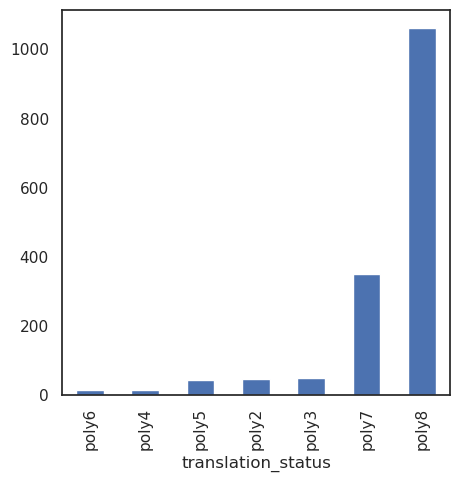

In [241]:
trip_stamp_merged['translation_status'].value_counts().sort_values().plot.bar()

/tmp/ipykernel_4185019/2102314108.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(data=trip_stamp_merged.sort_values(by='translation_status'), x='translation_status', y='APO_mean', color='steelblue', ax=axes[1], scale='count')
/tmp/ipykernel_4185019/2102314108.py:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(data=trip_stamp_merged.sort_values(by='translation_status'), x='translation_status', y='RPS2_mean', color='orange', ax=axes[0], scale='count')


<Axes: xlabel='translation_status', ylabel='RPS2_mean'>

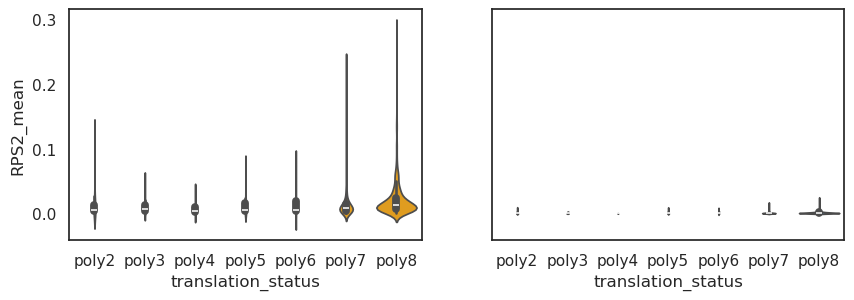

In [242]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

sns.violinplot(data=trip_stamp_merged.sort_values(by='translation_status'), x='translation_status', y='APO_mean', color='steelblue', ax=axes[1], scale='count')
sns.violinplot(data=trip_stamp_merged.sort_values(by='translation_status'), x='translation_status', y='RPS2_mean', color='orange', ax=axes[0], scale='count')

In [ ]:
# for f in ['poly8', 'poly7', 'poly6', 'poly5', 'poly3', 'poly4']:
#     sns.jointplot(data=trip_stamp_merged[trip_stamp_merged['translation_status']==f], x=f'{f}_mean', y='RPS2_mean', linewidth=0, alpha=0.5)
#     plt.ylim(-0.005, 0.20)
#     print(f, stats.spearmanr(trip_stamp_merged[trip_stamp_merged['translation_status']==f][f'{f}_mean'], trip_stamp_merged[trip_stamp_merged['translation_status']==f]['RPS2_mean'])[0])

0.26255252920654915


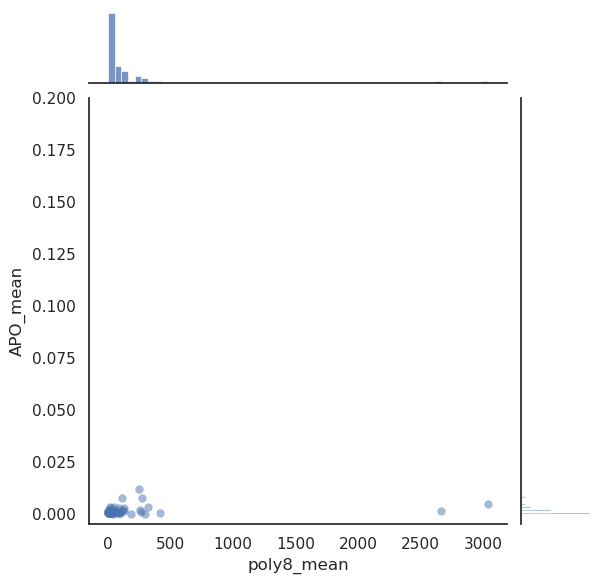

In [244]:
trip_stamp_merged_multiple_genes = trip_stamp_merged[trip_stamp_merged['gene_name'].isin(multiple_transcript_genes)]
sns.jointplot(data=trip_stamp_merged_multiple_genes[trip_stamp_merged_multiple_genes['translation_status']=='poly8'], x='poly8_mean', y='APO_mean', linewidth=0, alpha=0.5)
plt.ylim(-0.005, 0.20)
print(stats.spearmanr(trip_stamp_merged_multiple_genes[trip_stamp_merged_multiple_genes['translation_status']=='poly8'][f'poly8_mean'], trip_stamp_merged_multiple_genes[trip_stamp_merged_multiple_genes['translation_status']=='poly8']['APO_mean'])[0])

0.24792912201916997


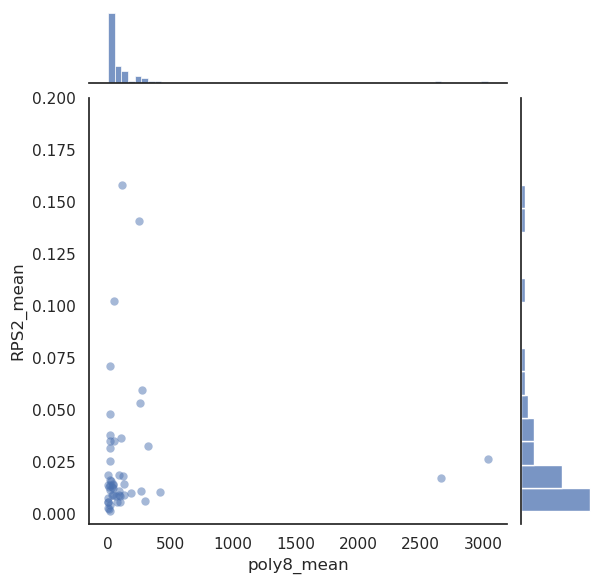

In [245]:
trip_stamp_merged_multiple_genes = trip_stamp_merged[trip_stamp_merged['gene_name'].isin(multiple_transcript_genes)]
sns.jointplot(data=trip_stamp_merged_multiple_genes[trip_stamp_merged_multiple_genes['translation_status']=='poly8'], x='poly8_mean', y='RPS2_mean', linewidth=0, alpha=0.5)
plt.ylim(-0.005, 0.20)
print(stats.spearmanr(trip_stamp_merged_multiple_genes[trip_stamp_merged_multiple_genes['translation_status']=='poly8'][f'poly8_mean'], trip_stamp_merged_multiple_genes[trip_stamp_merged_multiple_genes['translation_status']=='poly8']['RPS2_mean'])[0])

In [246]:
trip_stamp_merged_multiple_genes['RPS2_mean/APO_mean'] = trip_stamp_merged_multiple_genes['RPS2_mean']/trip_stamp_merged_multiple_genes['APO_mean']

/tmp/ipykernel_4185019/3293055026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_stamp_merged_multiple_genes['RPS2_mean/APO_mean'] = trip_stamp_merged_multiple_genes['RPS2_mean']/trip_stamp_merged_multiple_genes['APO_mean']


In [248]:
trip_stamp_merged_multiple_genes.head()#[["gene_name","gene_id","gene_biotype","isoform_id","isoform_biotype", "poly8_mean","translation_status","shortened_transcript_id","APO_mean","RPS2_mean","RPS2_mean/APO_mean"]]

gene_name          gene_id    gene_biotype       isoform_id  \
122      ACTG1  ENSG00000184009  protein_coding  ENST00000331925   
124      ACTG1  ENSG00000184009  protein_coding  ENST00000576544   
310     ANAPC5  ENSG00000089053  protein_coding  ENST00000261819   
311     ANAPC5  ENSG00000089053  protein_coding  ENST00000541887   
1159     CCNG1  ENSG00000113328  protein_coding  ENST00000340828   

              isoform_biotype    poly2_1    poly2_2    poly3_1    poly3_2  \
122            protein_coding  111.10228  218.10356  146.68846  100.85693   
124   nonsense_mediated_decay    0.16450    7.08912    0.24276    3.84056   
310            protein_coding   17.40819   33.69718   26.22302   31.03641   
311            protein_coding    0.52116    2.17616    0.00000    5.10861   
1159           protein_coding  116.17507  156.77997  138.02457  103.78897   

       poly4_1  ...  shortened_transcript_id  editsC_APO_rep1  \
122   99.36155  ...          ENST00000331925         0.006452   
124    0.35916  ...          ENST00000576544         0.011613   
310   41.16087  ...          ENST00000261819         0.001574   
311    0.00000  ...          ENST00000541887         0.000000   
1159  86.77990  ...          ENST00000340828         0.000000   

      editsC_APO_rep2  editsC_APO_rep3  editsC_RPS2_rep1  editsC_RPS2_rep2  \
122          0.003871         0.003871          0.015484          0.032258   
124          0.006452         0.005161          0.059355          0.060645   
310          0.000787         0.001968          0.022826          0.018497   
311          0.000394         0.000000          0.003148          0.004723   
1159         0.000000         0.003831          0.007663          0.015326   

      editsC_RPS2_rep3  APO_mean  RPS2_mean  RPS2_mean/APO_mean  
122           0.030968  0.004731   0.026237            5.545455  
124           0.058065  0.007742   0.059355            7.666667  
310           0.021645  0.001443   0.020989           14.545455  
311           0.005116  0.000131   0.004329           33.000000  
1159          0.030651  0.001277   0.017880           14.000000  

[5 rows x 37 columns]

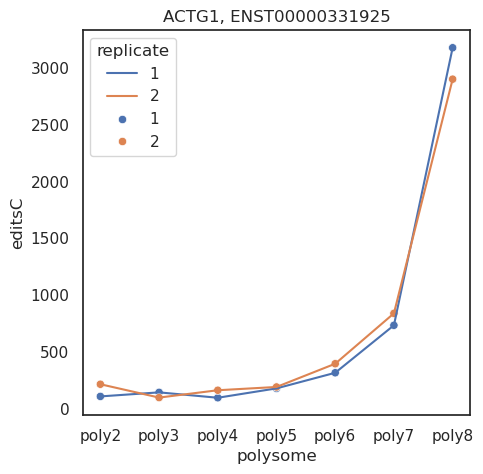

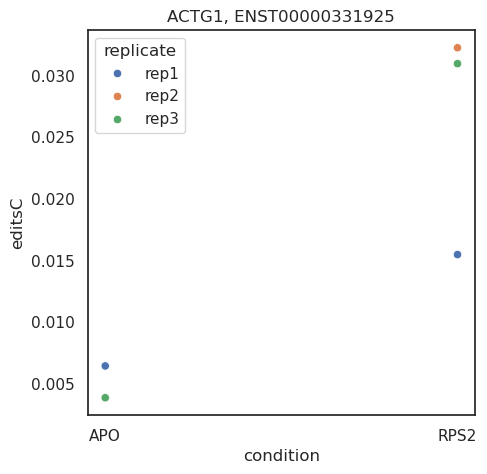

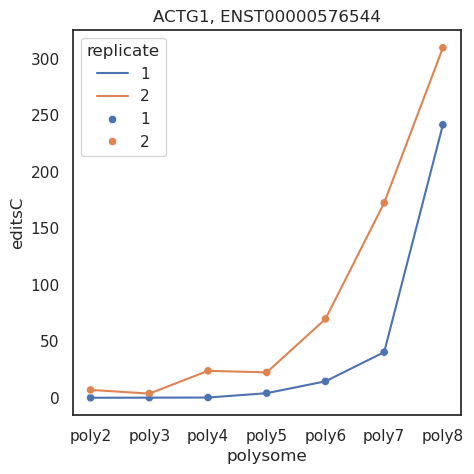

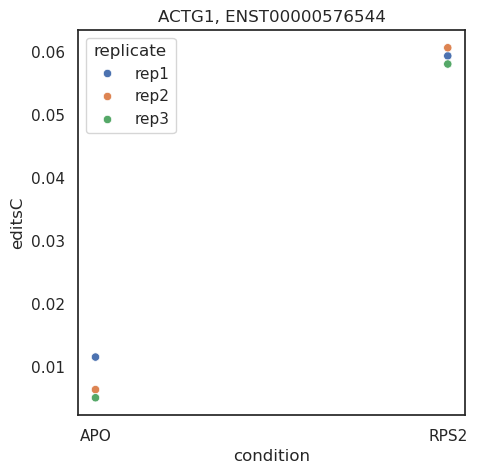

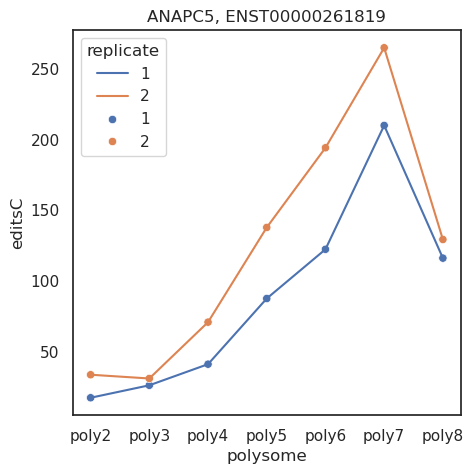

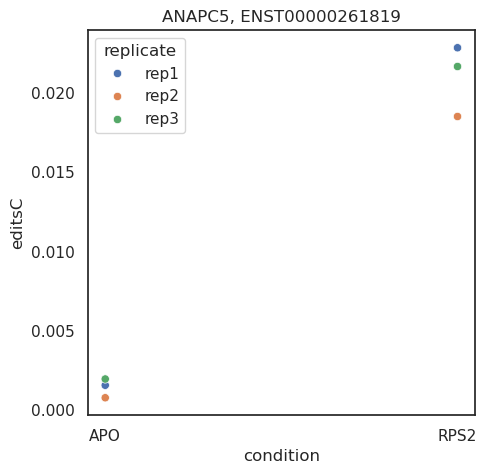

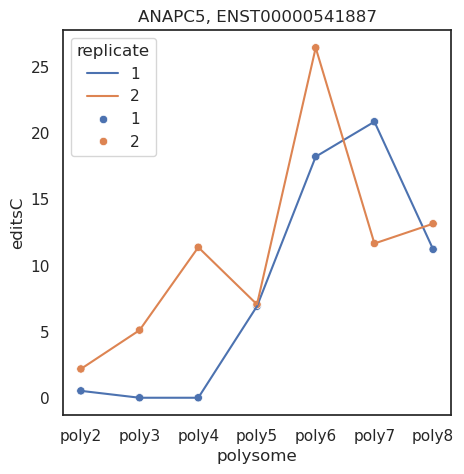

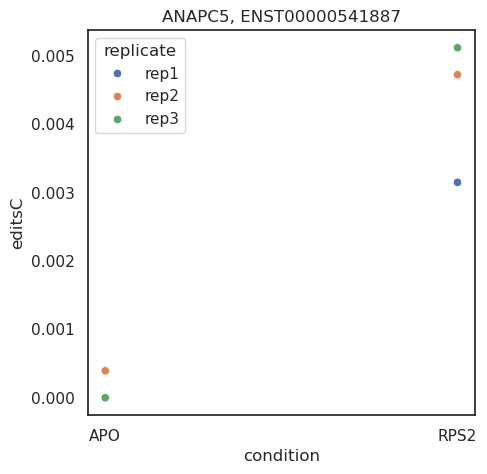

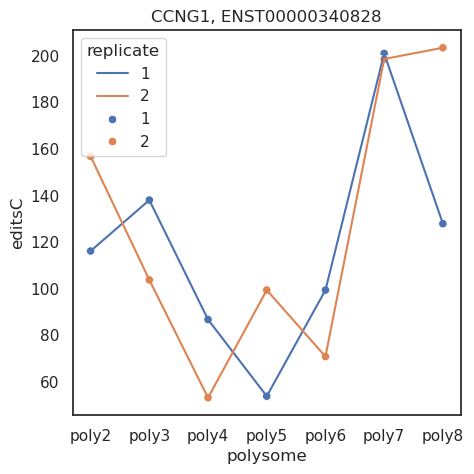

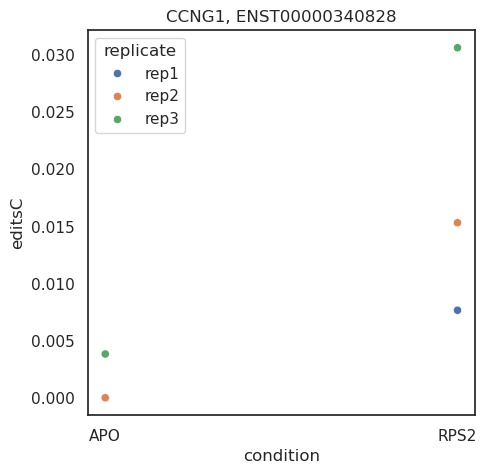

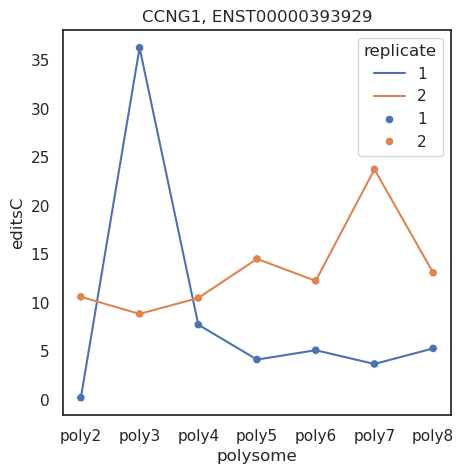

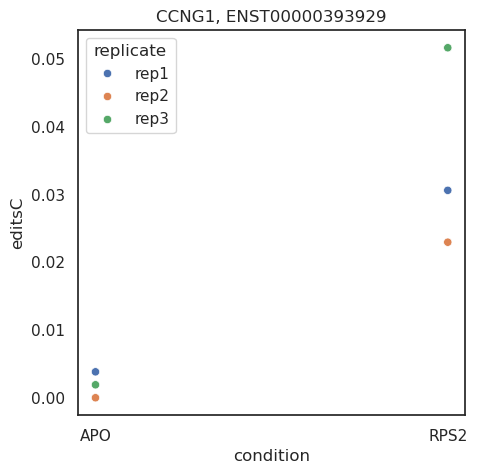

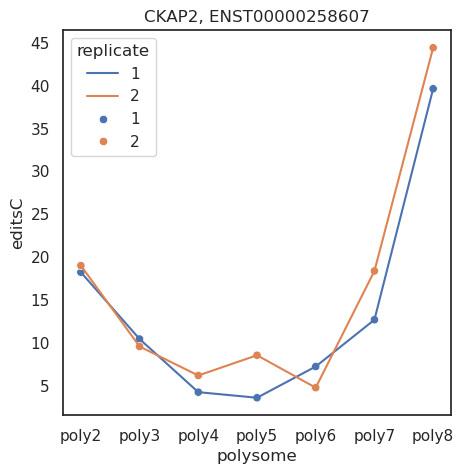

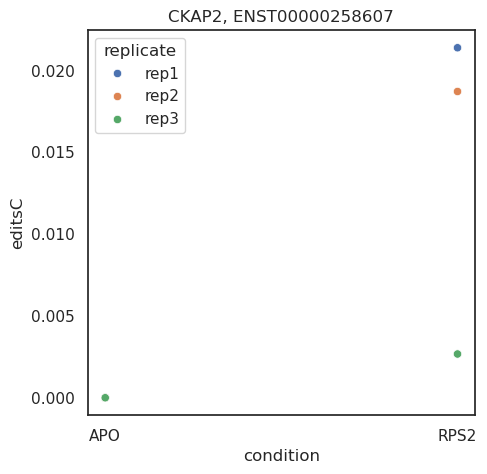

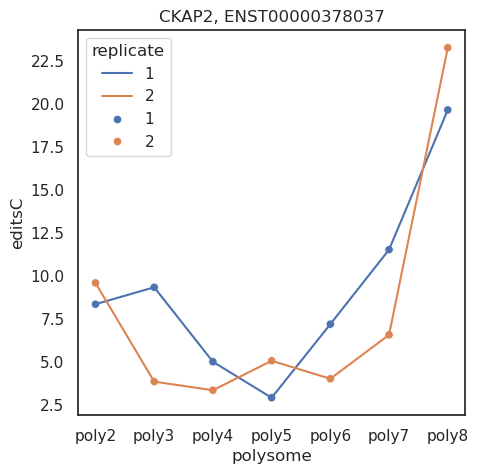

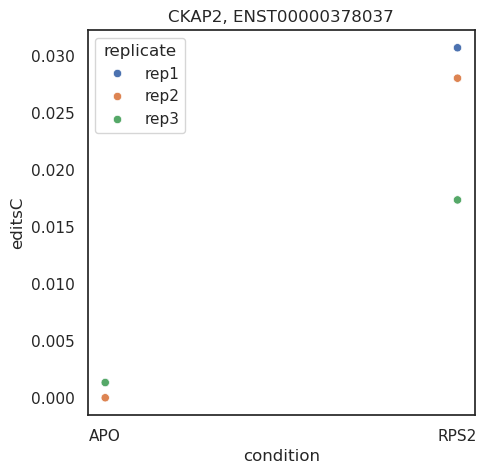

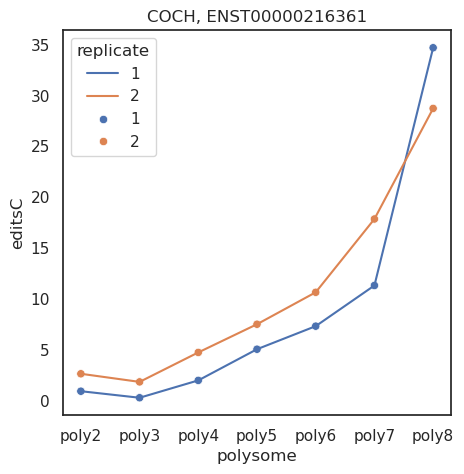

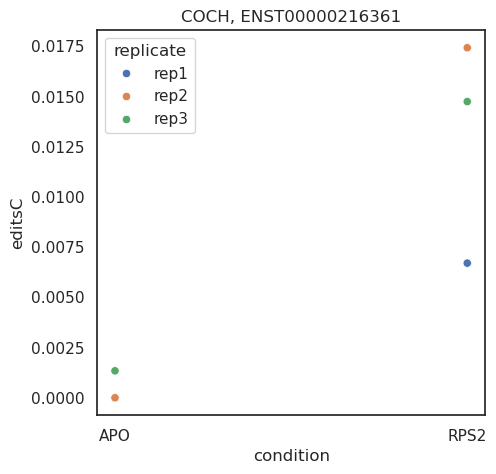

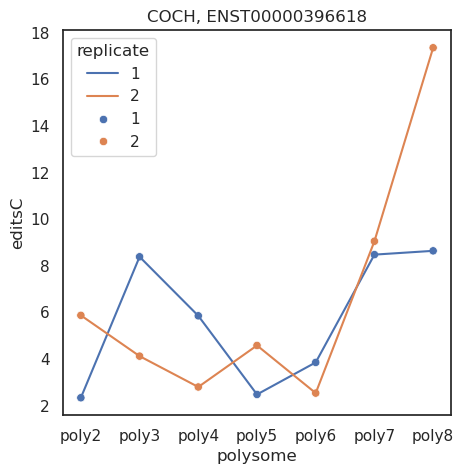

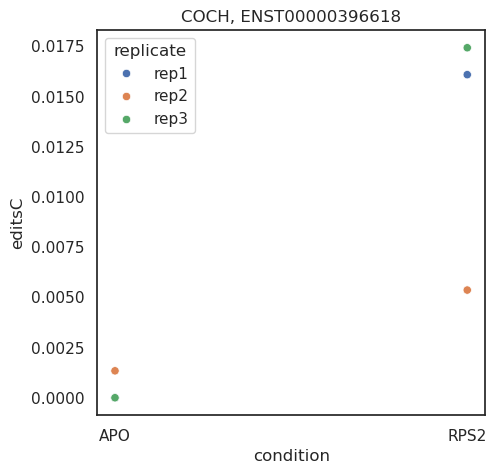

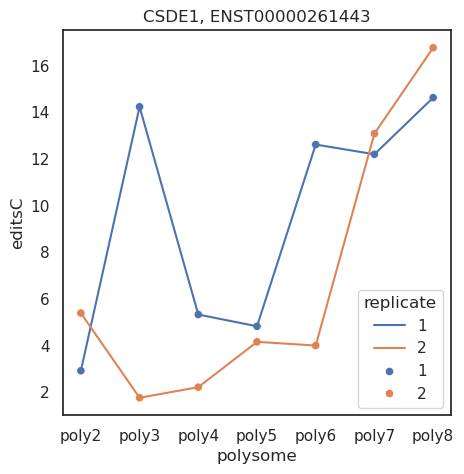

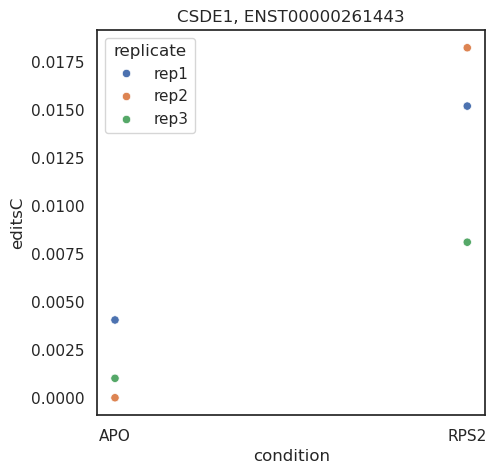

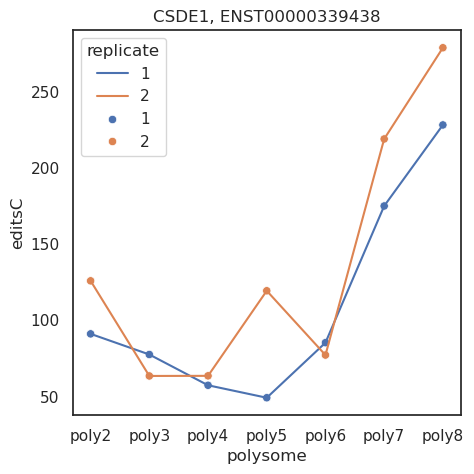

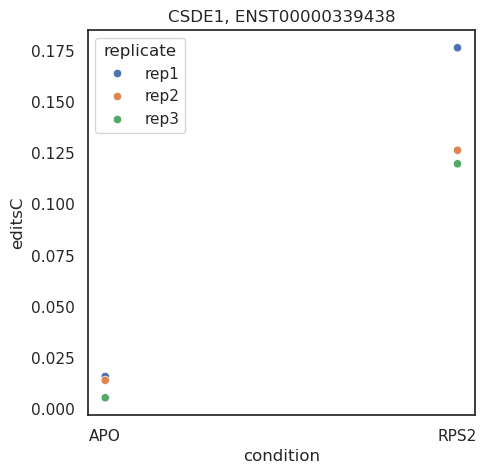

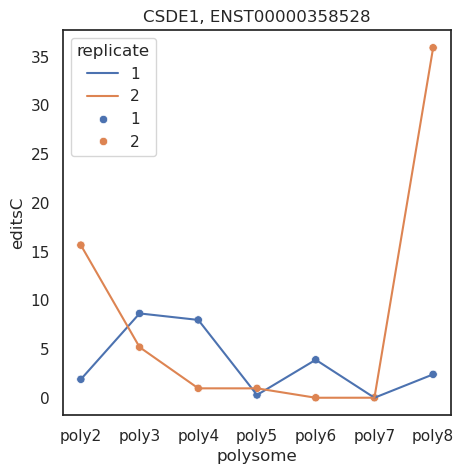

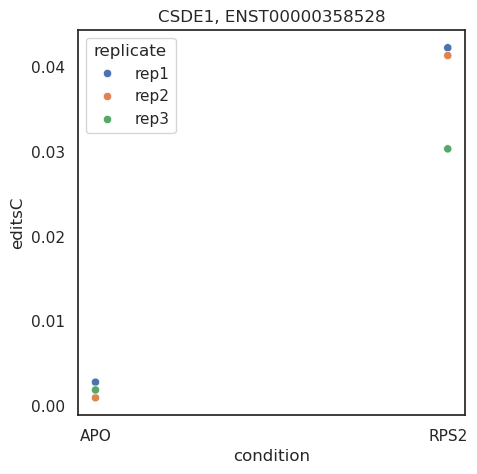

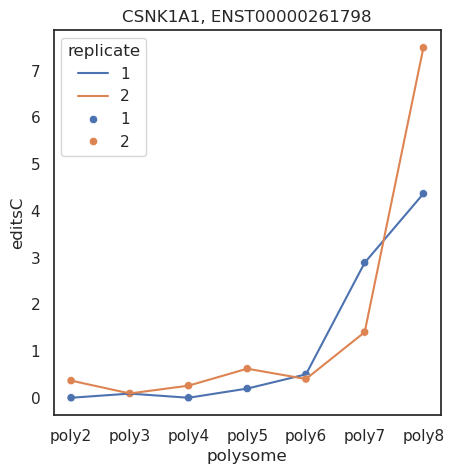

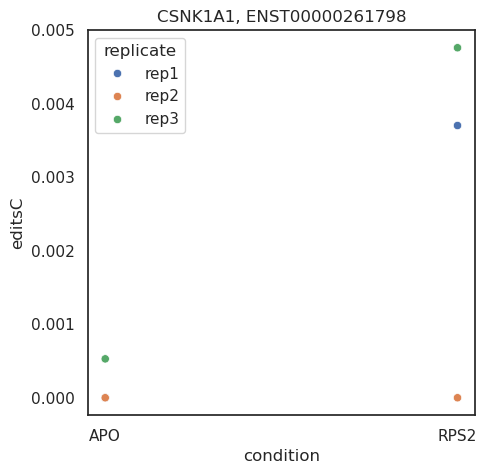

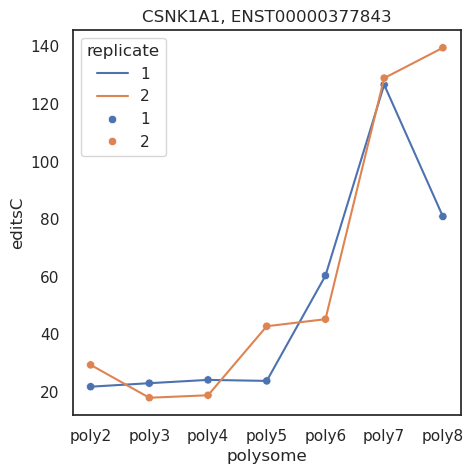

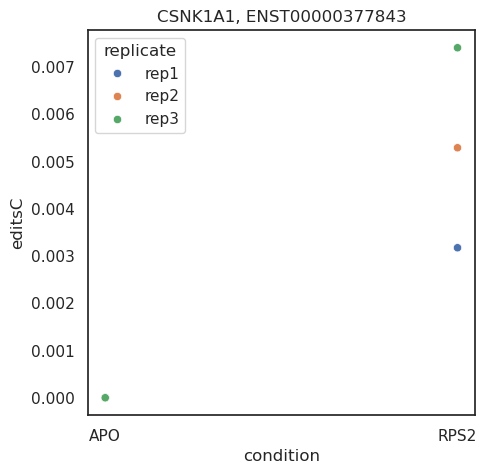

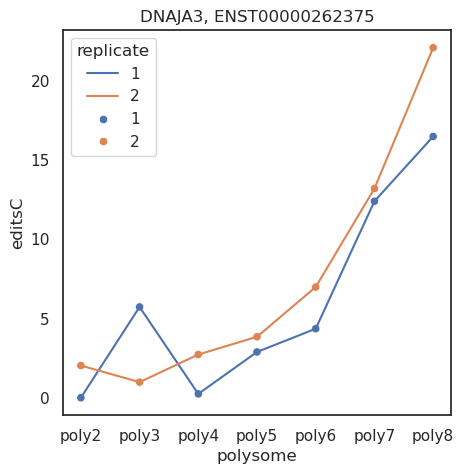

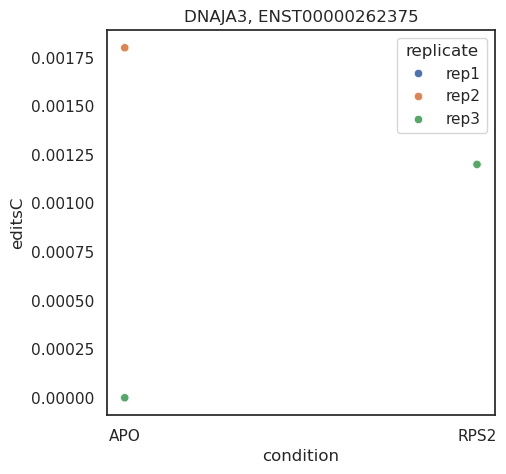

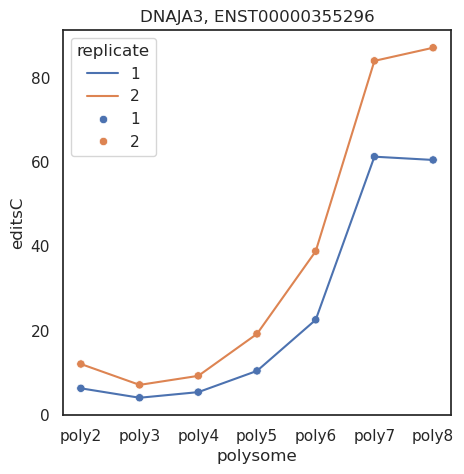

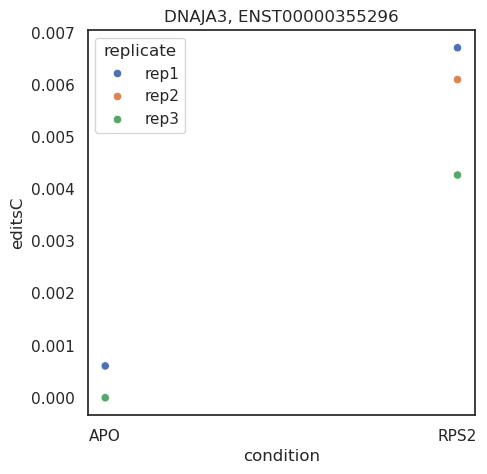

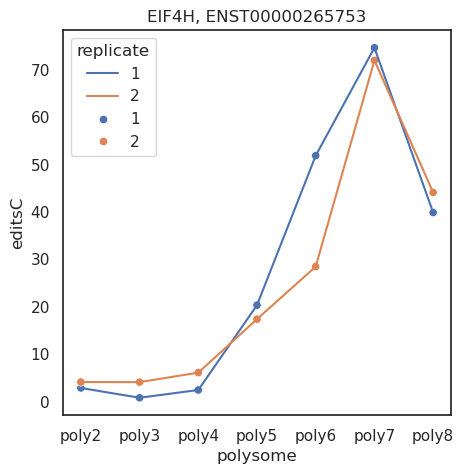

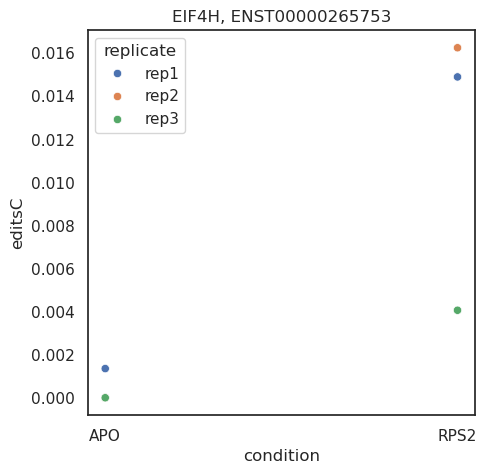

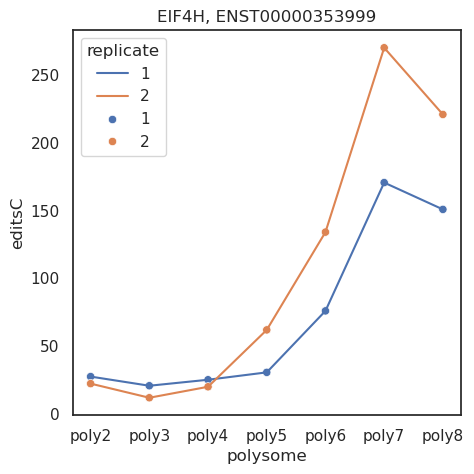

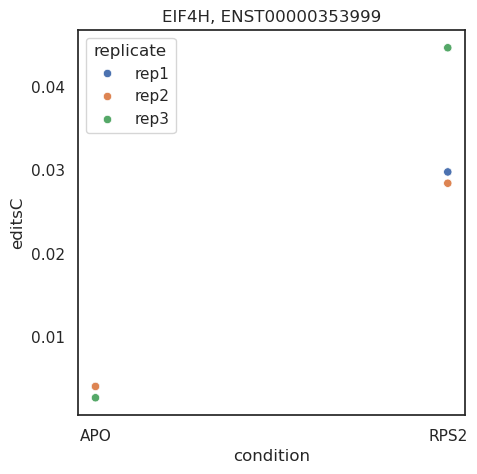

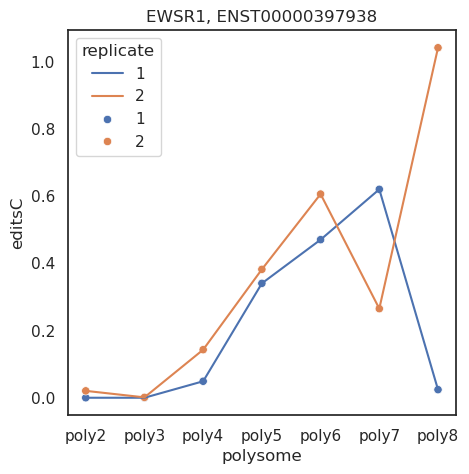

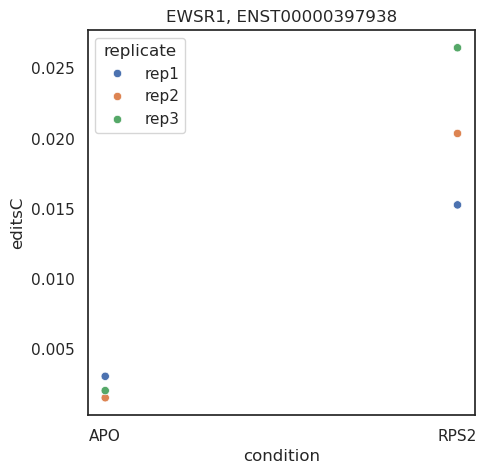

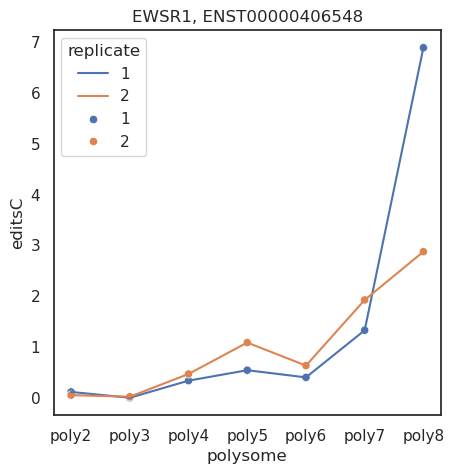

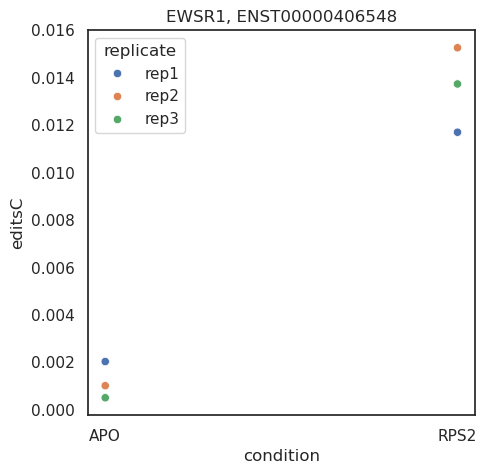

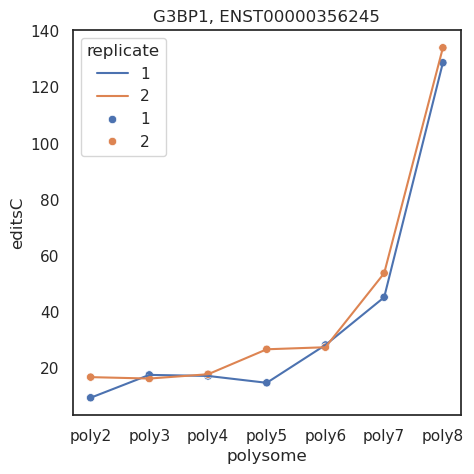

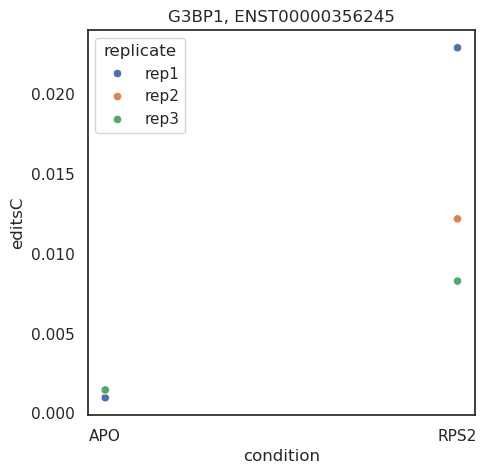

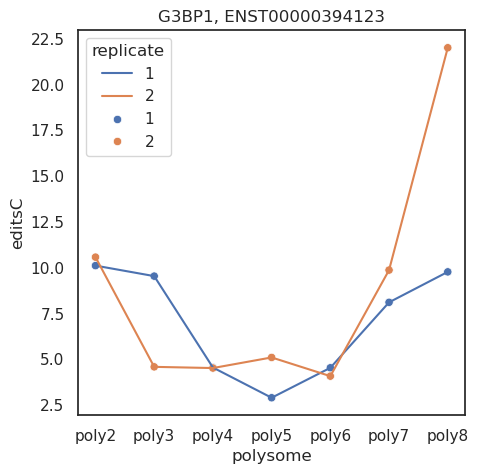

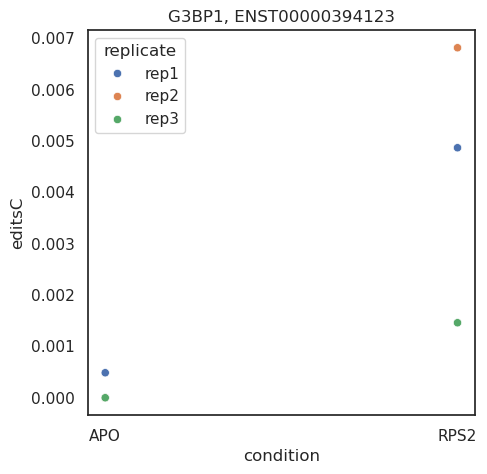

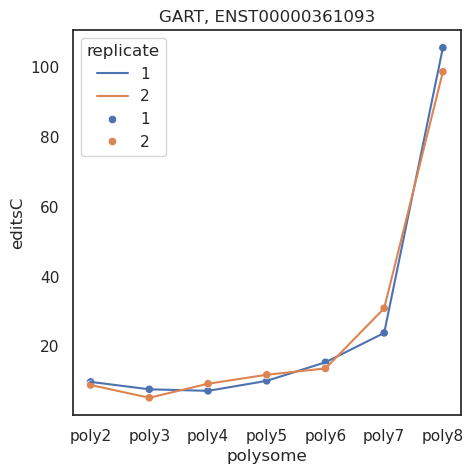

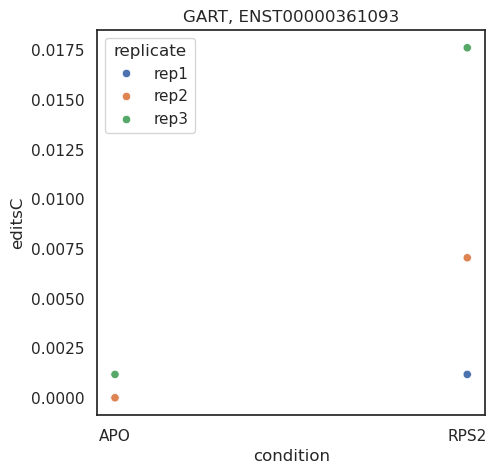

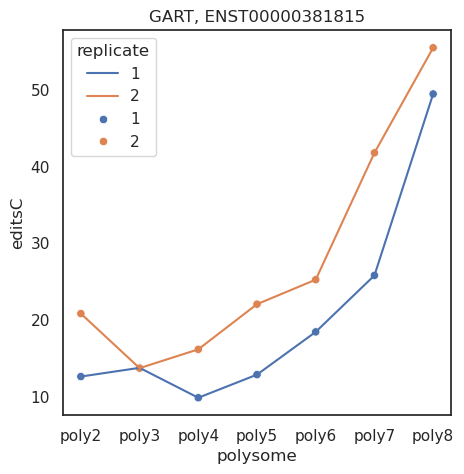

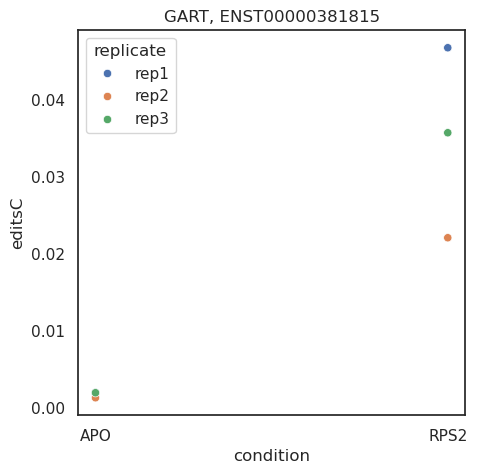

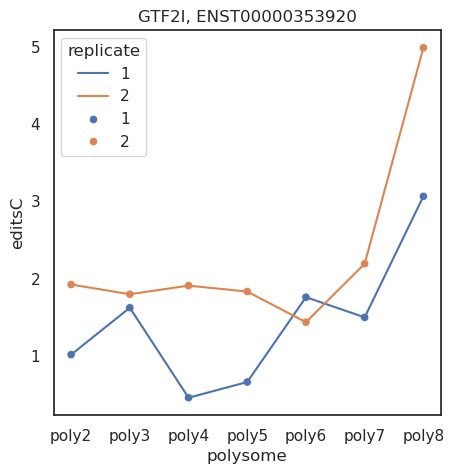

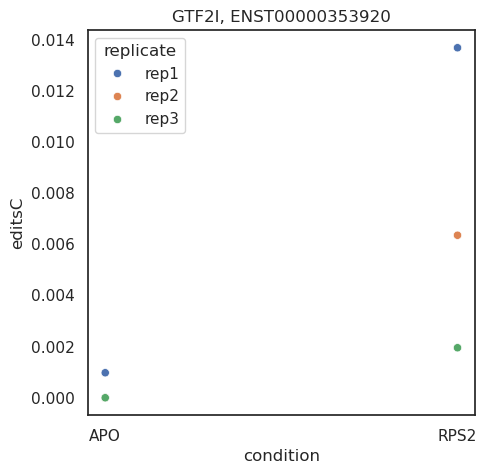

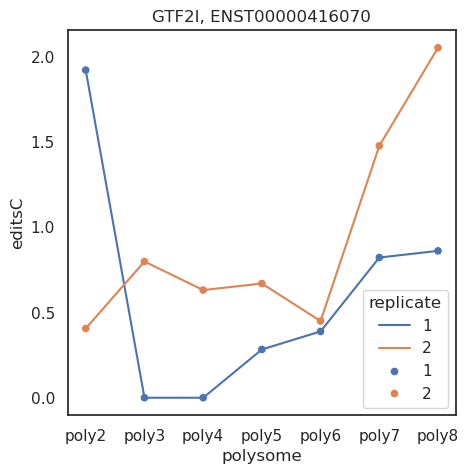

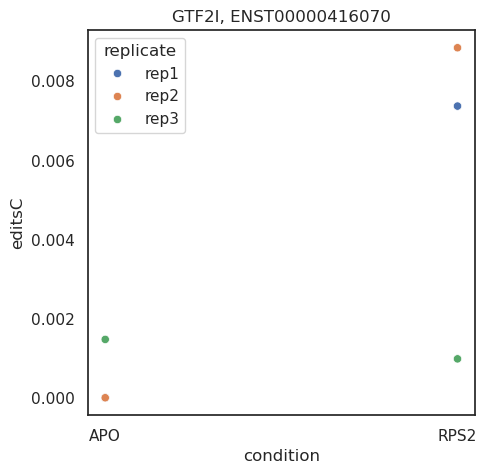

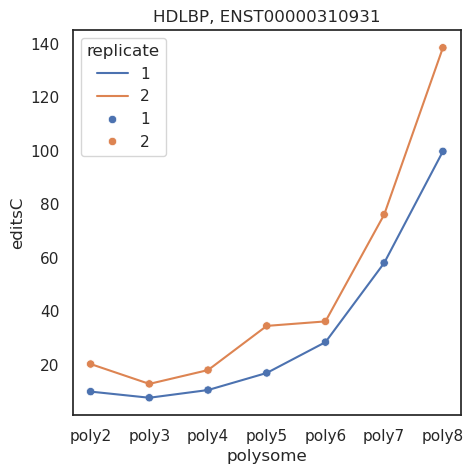

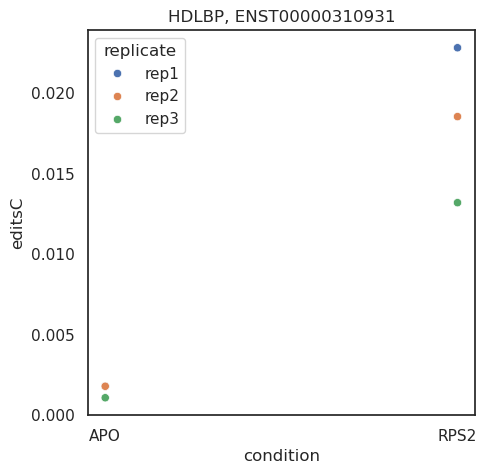

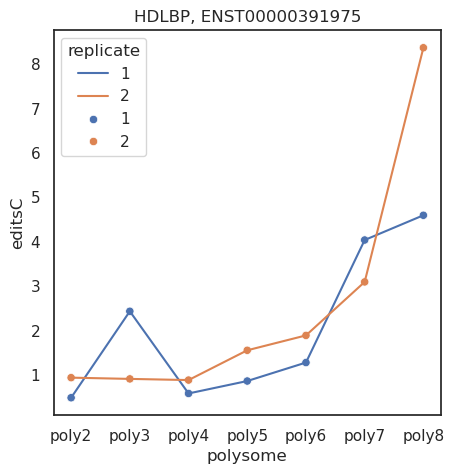

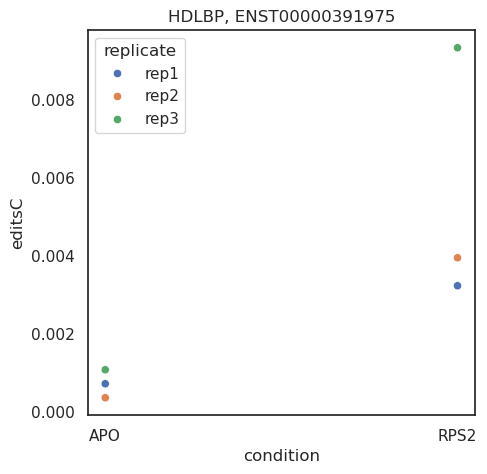

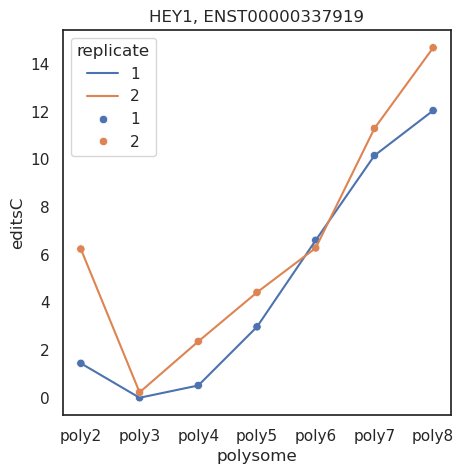

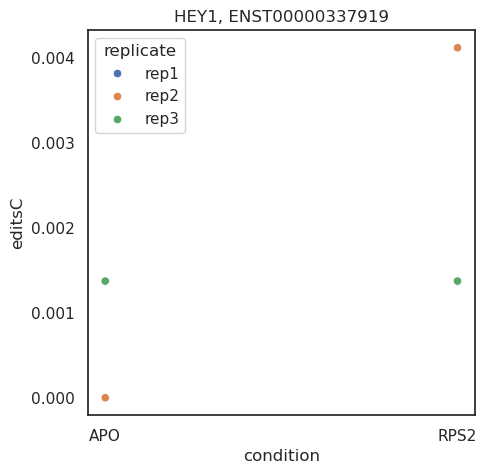

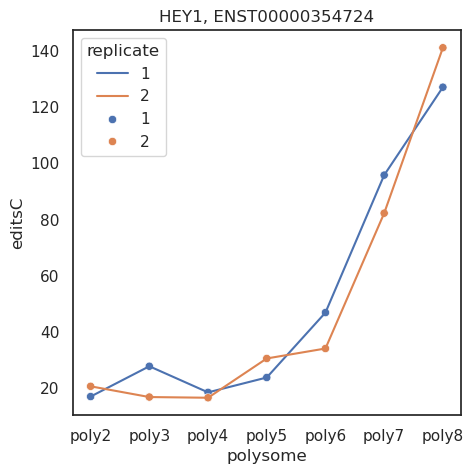

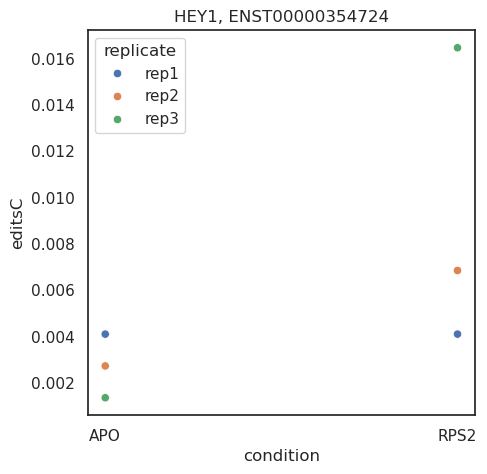

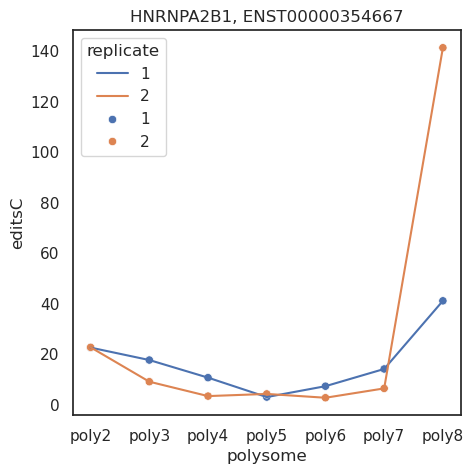

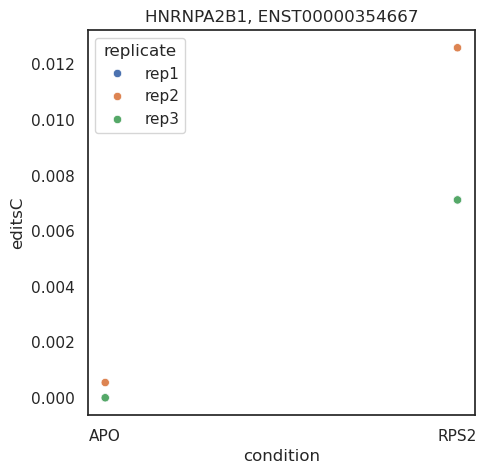

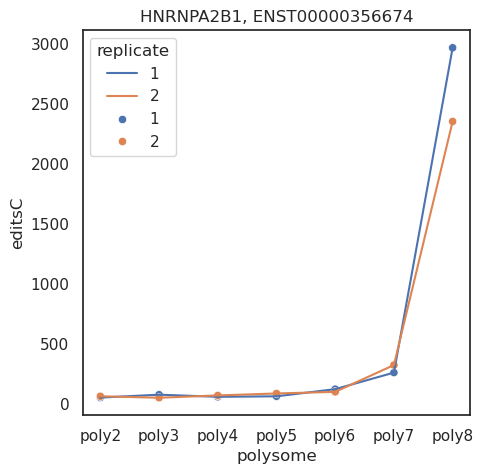

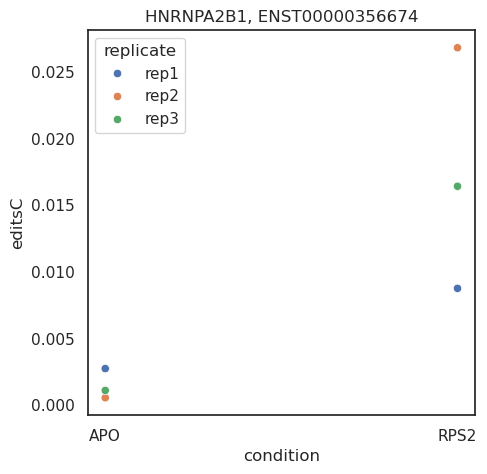

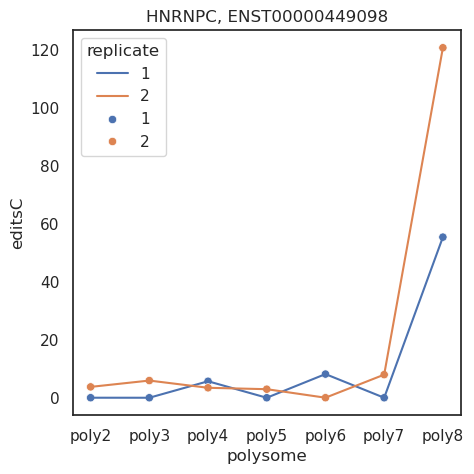

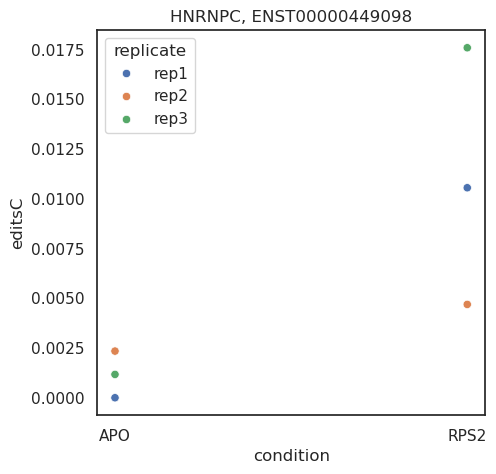

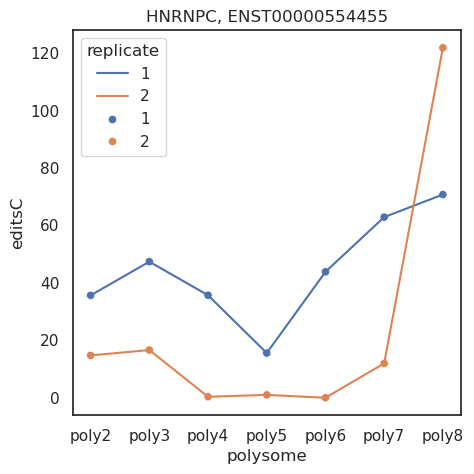

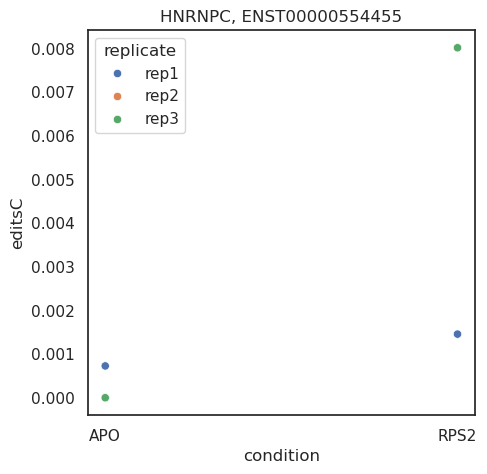

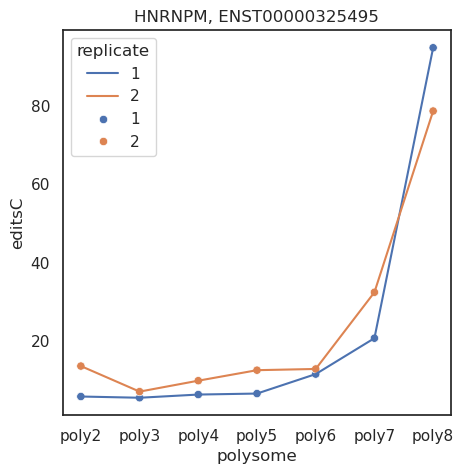

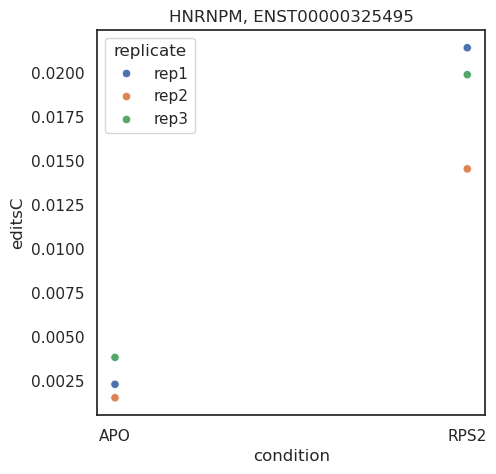

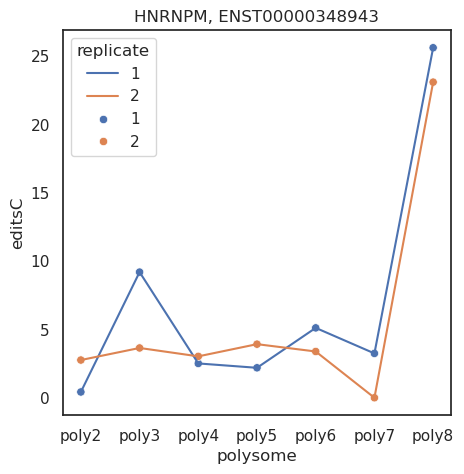

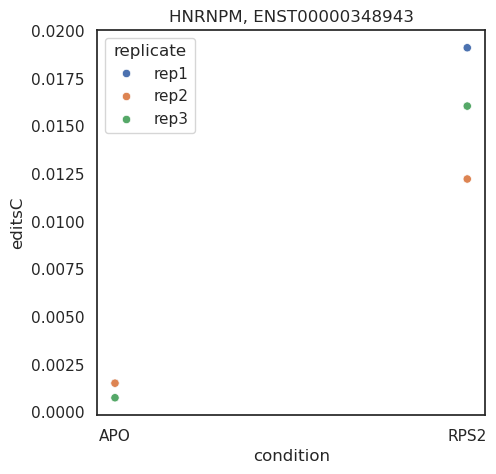

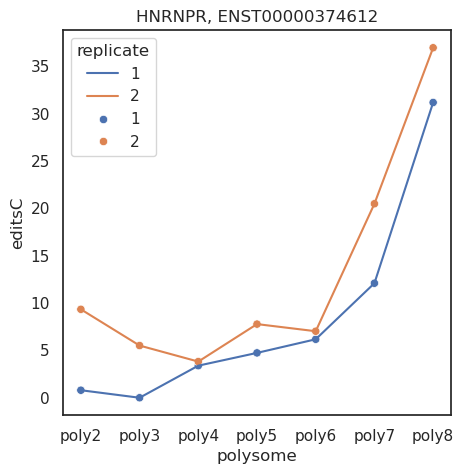

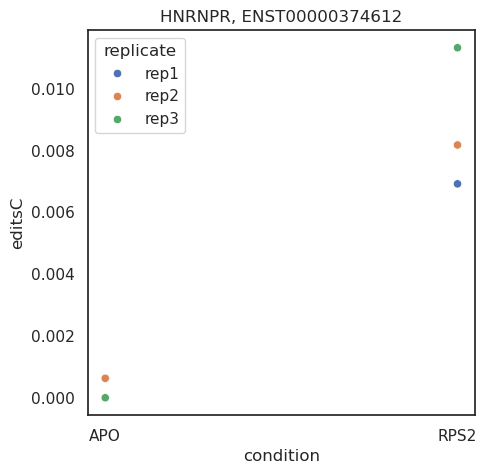

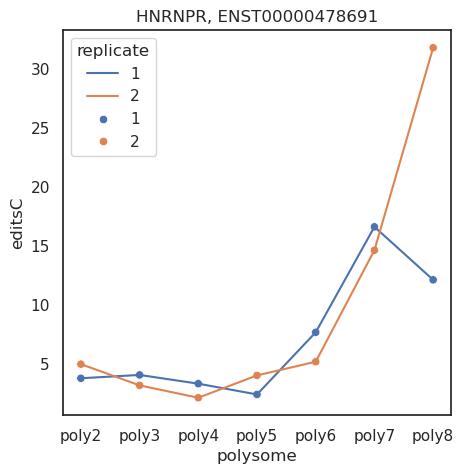

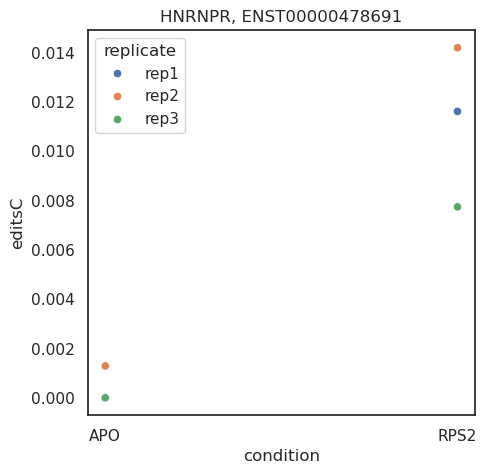

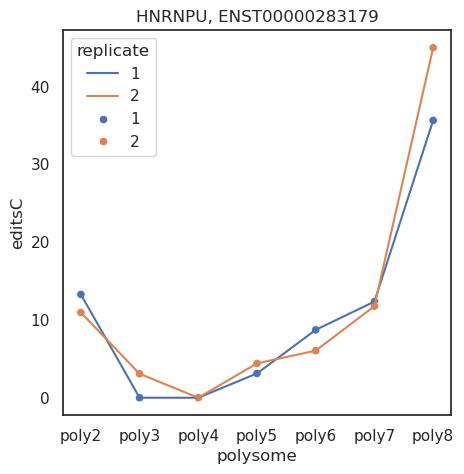

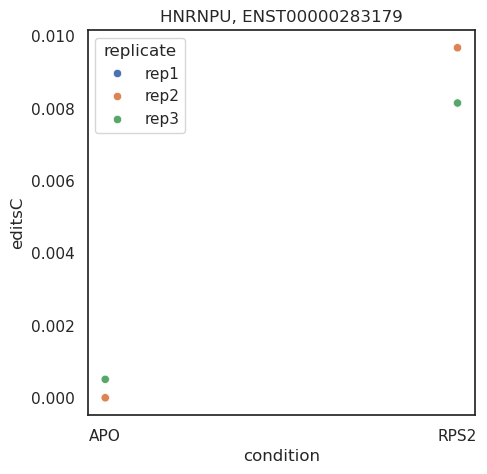

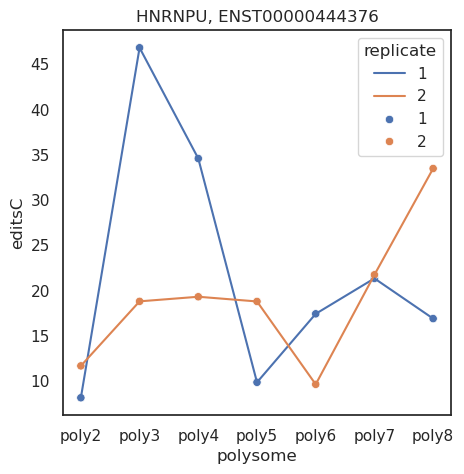

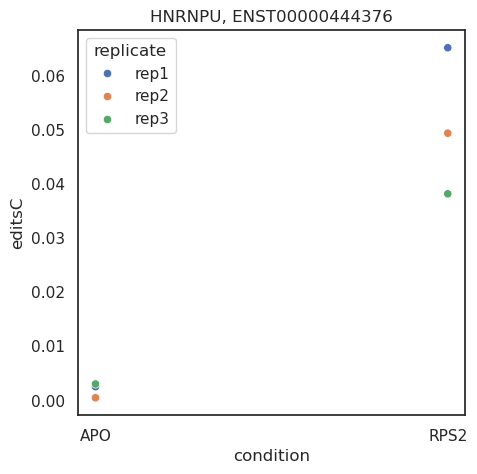

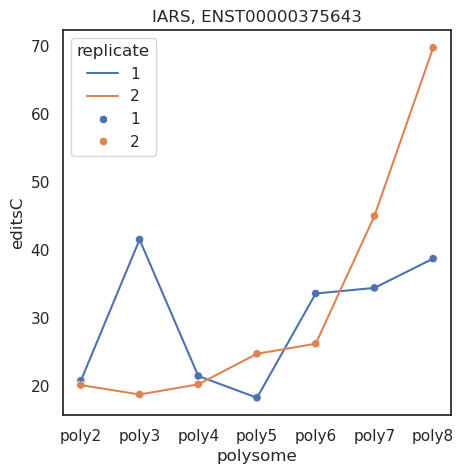

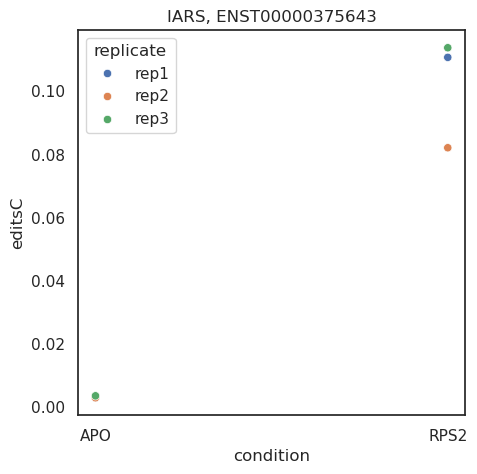

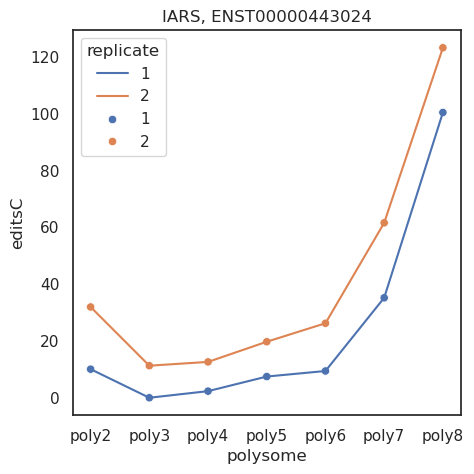

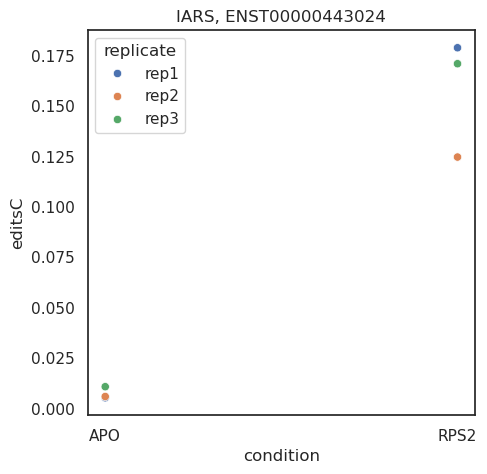

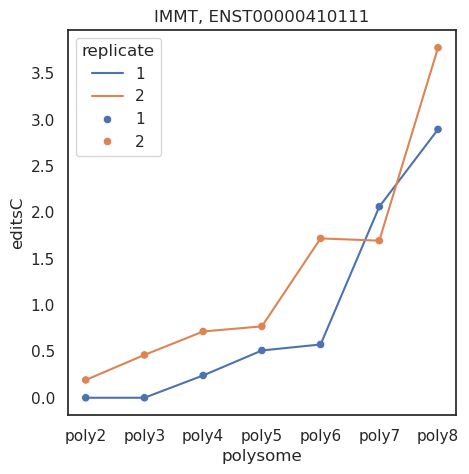

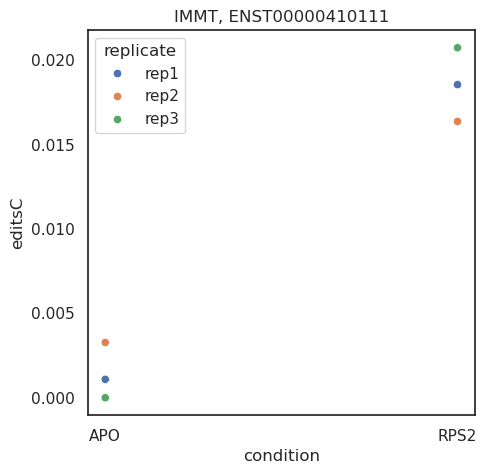

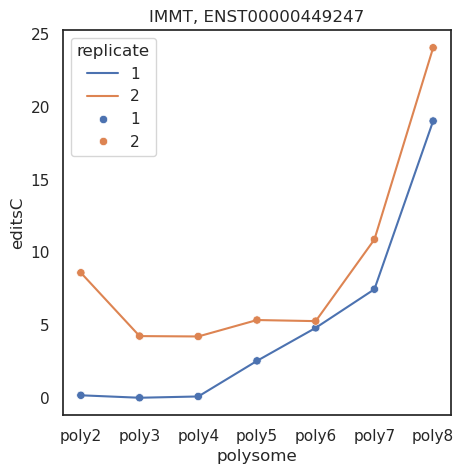

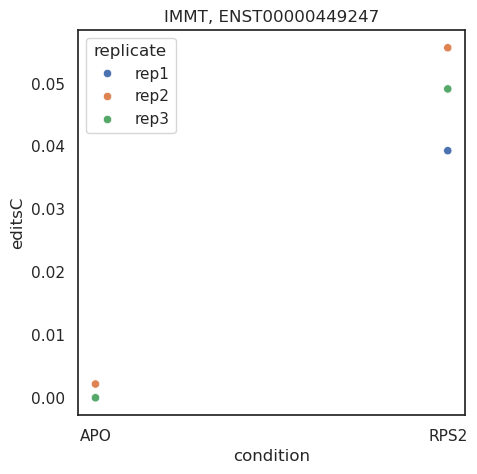

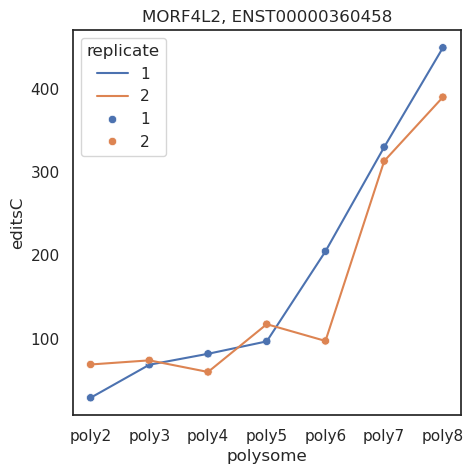

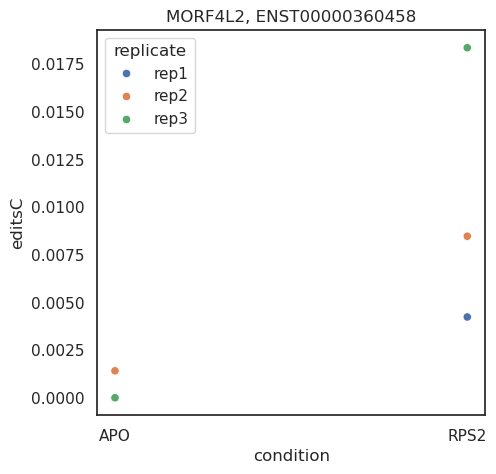

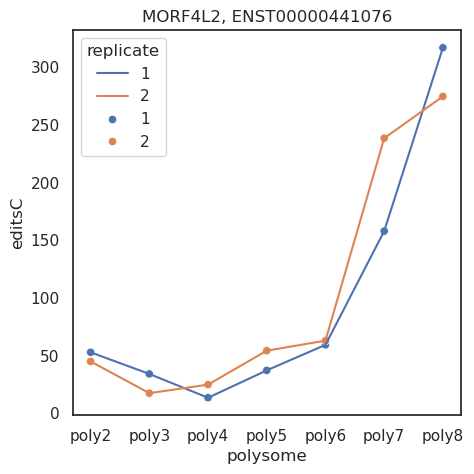

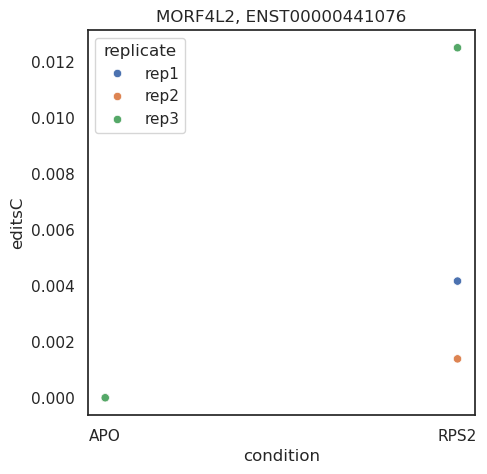

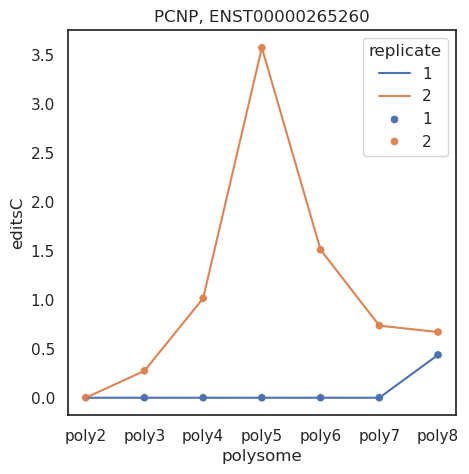

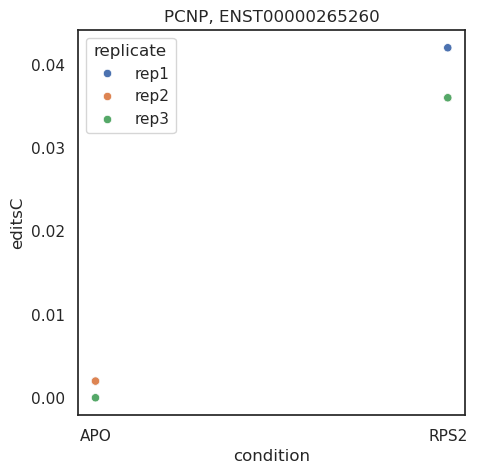

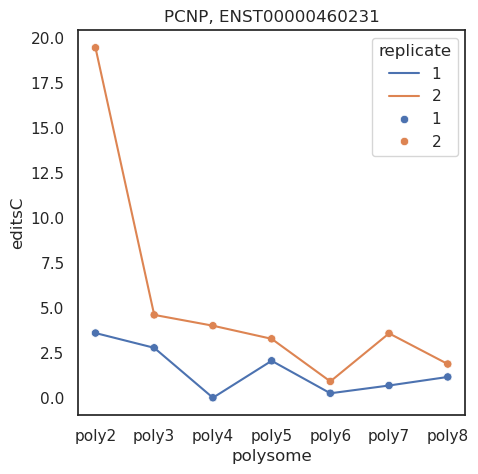

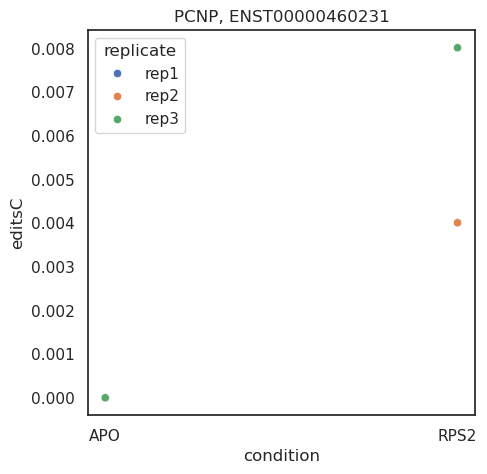

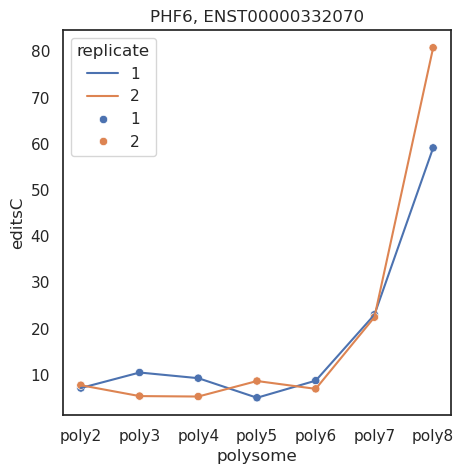

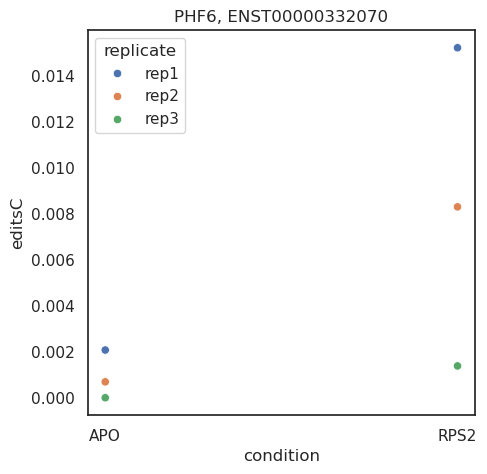

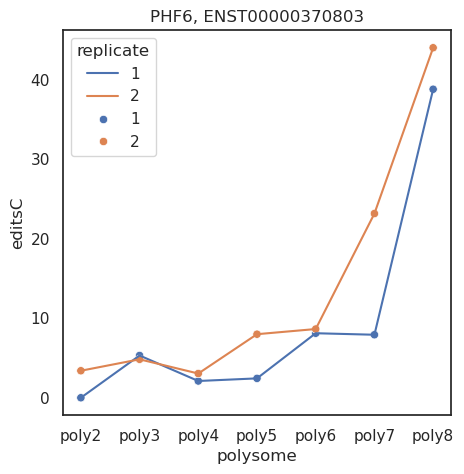

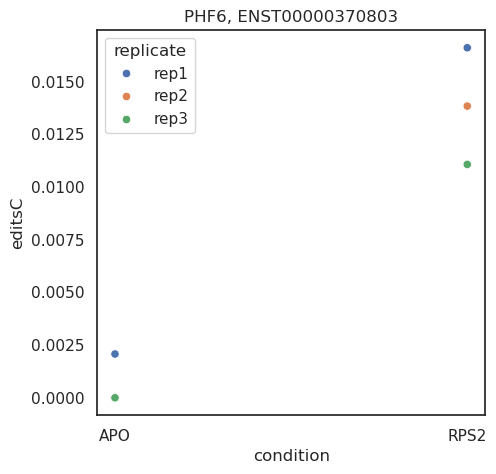

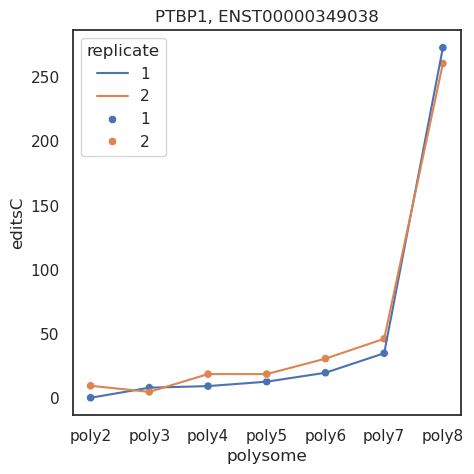

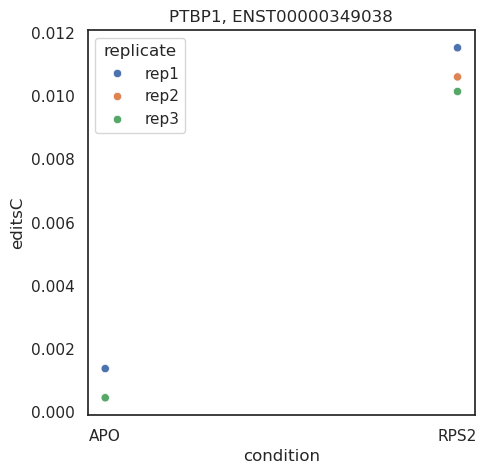

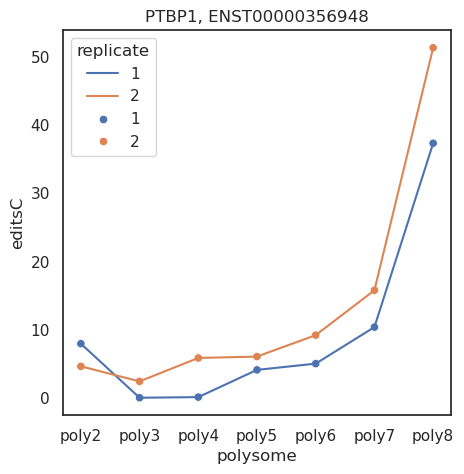

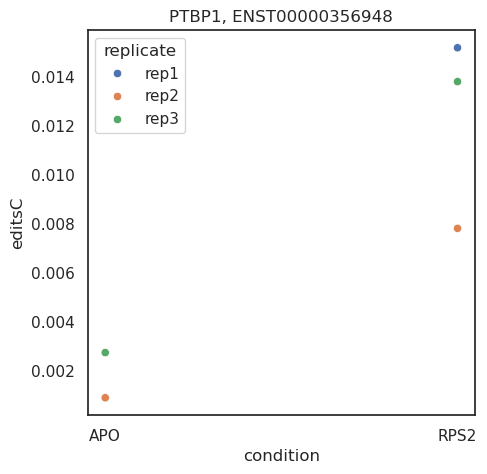

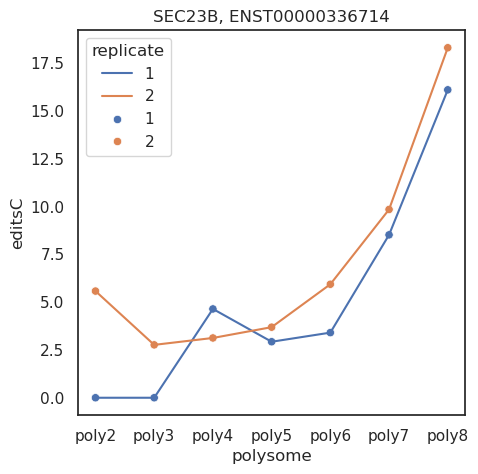

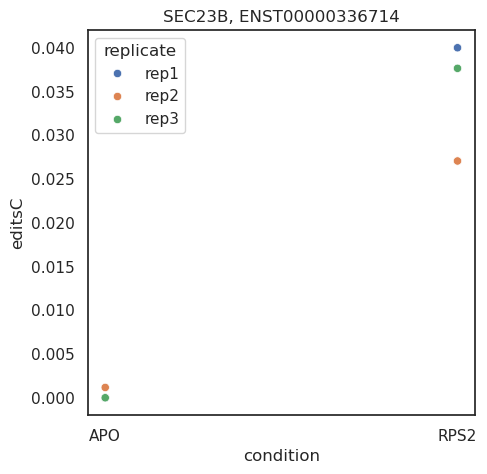

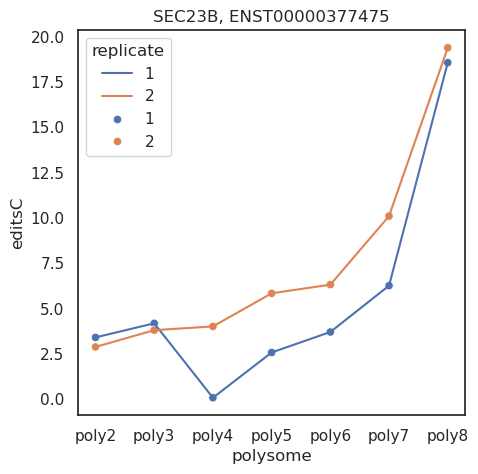

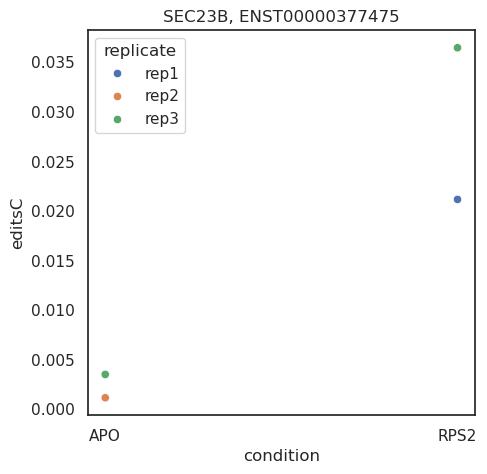

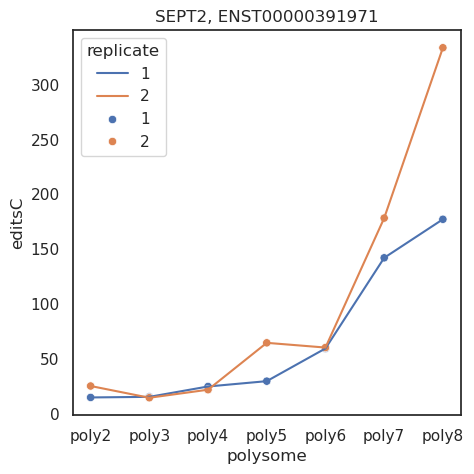

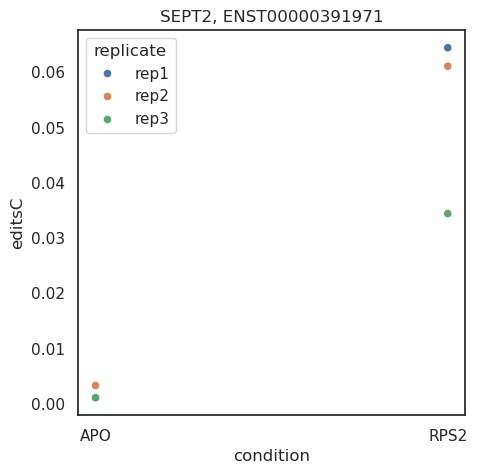

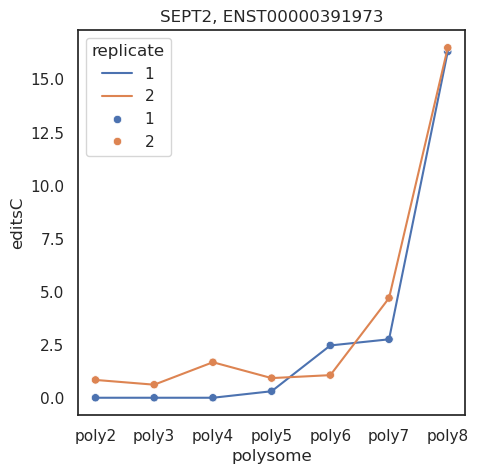

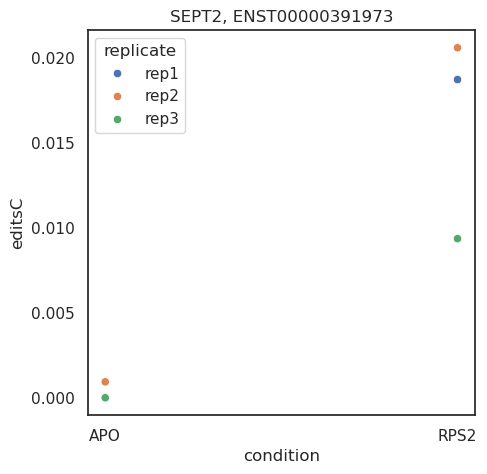

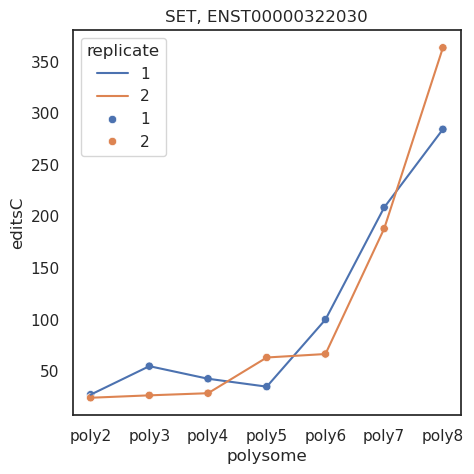

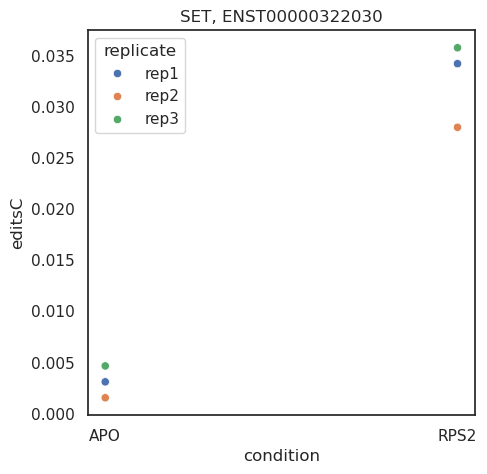

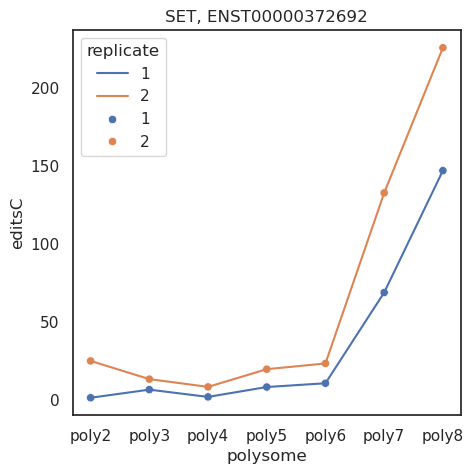

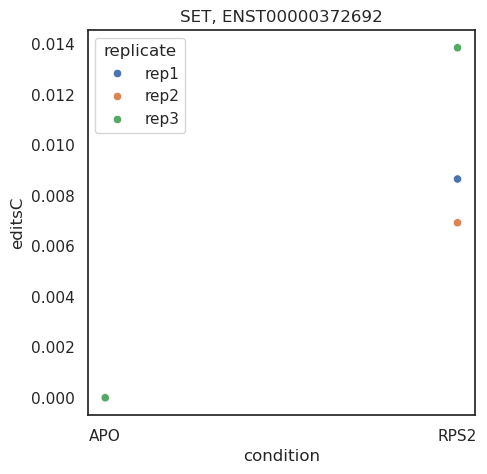

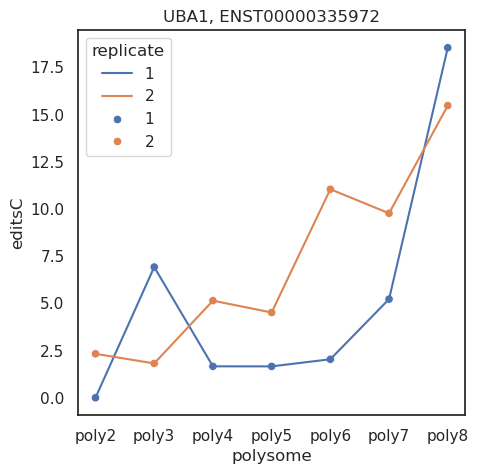

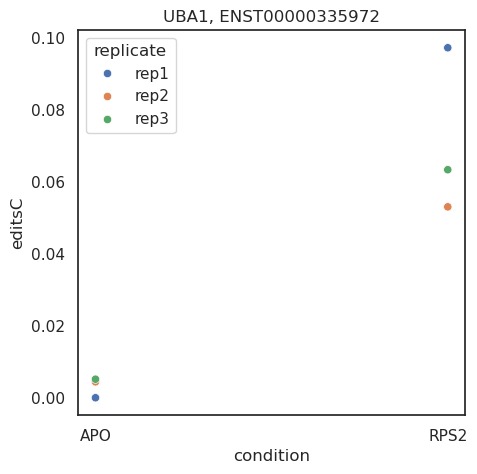

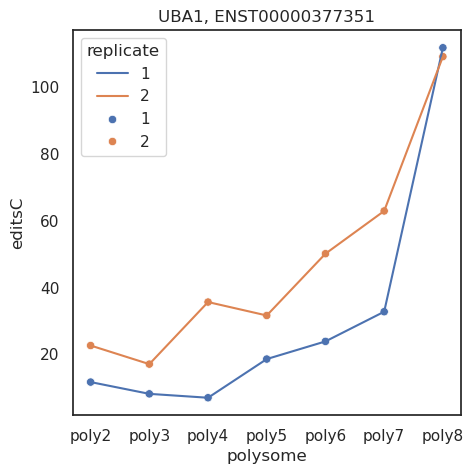

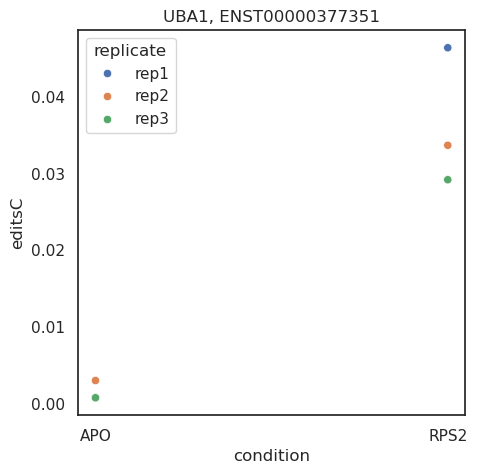

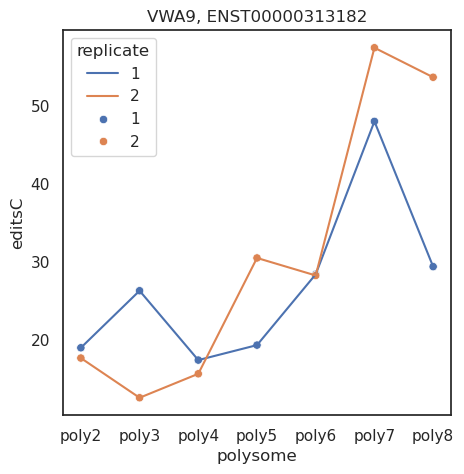

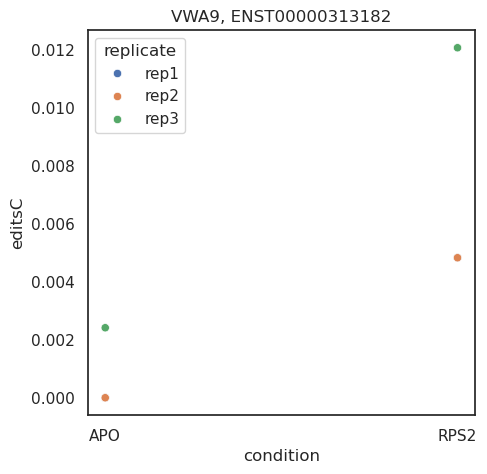

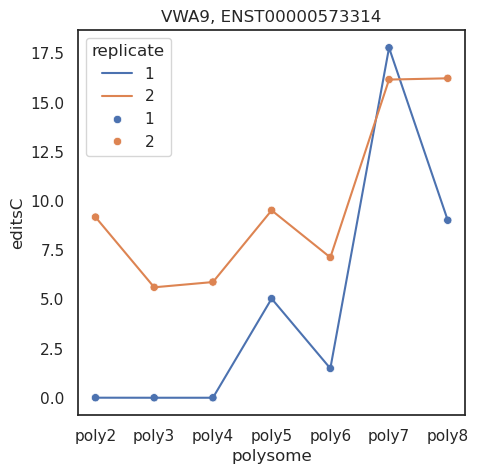

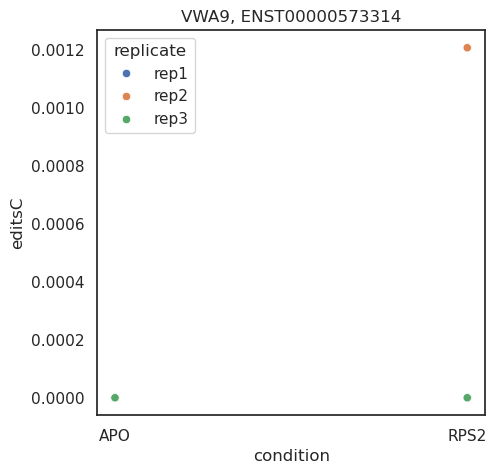

In [249]:
for row, index in trip_stamp_merged_multiple_genes.iterrows():
    #fig, ax = plt.subplots(1, 2, figsize=(3, 3))
    trip_toplot = []
    stamp_toplot=[]
    for p in ['poly2', 'poly3', 'poly4', 'poly5', 'poly6', 'poly7', 'poly8']:
        for r in ['1', '2']:
            trip_toplot.append([trip_stamp_merged_multiple_genes.loc[row,'gene_name'],p, r,trip_stamp_merged_multiple_genes.loc[row,f'{p}_{r}']])
    for c in ['APO', 'RPS2']:
        for rep in ['rep1', 'rep2', 'rep3']:
            stamp_toplot.append([trip_stamp_merged_multiple_genes.loc[row,'gene_name'],c, rep,trip_stamp_merged_multiple_genes.loc[row,f'editsC_{c}_{rep}']])
    sns.lineplot(data=pd.DataFrame(trip_toplot, columns=['gene_name', 'polysome', 'replicate', 'editsC']), x='polysome', y='editsC', hue='replicate')
    sns.scatterplot(data=pd.DataFrame(trip_toplot, columns=['gene_name', 'polysome', 'replicate', 'editsC']), x='polysome', y='editsC', hue='replicate')
    plt.title(f"{trip_stamp_merged_multiple_genes.loc[row,'gene_name']}, {trip_stamp_merged_multiple_genes.loc[row,'isoform_id']}")   
    plt.show()
    sns.scatterplot(data=pd.DataFrame(stamp_toplot, columns=['gene_name', 'condition', 'replicate', 'editsC']), x='condition', y='editsC', hue='replicate')
    plt.title(f"{trip_stamp_merged_multiple_genes.loc[row,'gene_name']}, {trip_stamp_merged_multiple_genes.loc[row,'isoform_id']}")                  
    plt.show()

In [ ]:
eclip_dir = '/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/eCLIP_benchmarks'

In [ ]:
apo_eclip_hg19_e = pd.read_csv(os.path.join(eclip_dir, 'APO.reproducible_enriched_windows.hg19.bed'), sep='\t', header=None)

In [ ]:
## RPS2 and GFP-APO samples were switched
rps2_eclip_hg19_e = pd.read_csv(os.path.join(eclip_dir, 'GFP-APO.reproducible_enriched_windows.hg19.bed'), sep='\t', header=None)

annotator --input ../GFP-APO.reproducible_enriched_windows.hg19.bed --output GFP-APO.reproducible_enriched_windows.hg19.annotated --gtf ~/projects/genomes/hg38/gencode.v38.annotation.gtf.db

annotator --input ../RPS2-APO.reproducible_enriched_windows.hg19.bed --output RPS2-APO.reproducible_enriched_windows.hg19.annotated --gtf ~/projects/genomes/hg38/gencode.v38.annotation.gtf.db; annotator --input ../RPS2.reproducible_enriched_windows.hg19.bed --output RPS2.reproducible_enriched_windows.hg19.annotated --gtf ~/projects/genomes/hg38/gencode.v38.annotation.gtf.db; annotator --input ../APO.reproducible_enriched_windows.hg19.bed --output APO.reproducible_enriched_windows.hg19.annotated --gtf ~/projects/genomes/hg38/gencode.v38.annotation.gtf.db

In [ ]:
# keeping reads with edits in positions that have common edits and snps removed
#apo_training = pd.concat([concat_edits_apo['rep1'][concat_edits_apo['rep1']['key'].isin(all_pos_edits_apo_common_all_rps2_snp_removed['rep1']['key'].tolist())], concat_edits_apo['rep2'][concat_edits_apo['rep2']['key'].isin(all_pos_edits_apo_common_all_rps2_snp_removed['rep2']['key'].tolist())]])
#apo_training = pd.concat([apo_training, concat_edits_apo['rep3'][concat_edits_apo['rep3']['key'].isin(all_pos_edits_apo_common_all_rps2_snp_removed['rep3']['key'].tolist())]])
#rps2_training = pd.concat([concat_edits_rps2['rep1'][concat_edits_rps2['rep1']['key'].isin(all_pos_edits_rps2_common_all_rps2_snp_removed['rep1']['key'].tolist())], concat_edits_rps2['rep2'][concat_edits_rps2['rep2']['key'].isin(all_pos_edits_rps2_common_all_rps2_snp_removed['rep2']['key'].tolist())]])
#rps2_training = pd.concat([rps2_training, concat_edits_rps2['rep3'][concat_edits_rps2['rep3']['key'].isin(all_pos_edits_rps2_common_all_rps2_snp_removed['rep3']['key'].tolist())]])                       

In [204]:
apo_training = pd.concat([concat_edits_apo['rep1'][concat_edits_apo['rep1']['key'].isin(keep_edits_apo['rep1']['key'].tolist())], concat_edits_apo['rep2'][concat_edits_apo['rep2']['key'].isin(keep_edits_apo['rep2']['key'].tolist())]])
apo_training = pd.concat([apo_training, concat_edits_apo['rep3'][concat_edits_apo['rep3']['key'].isin(keep_edits_apo['rep3']['key'].tolist())]])
rps2_training = pd.concat([concat_edits_rps2['rep1'][concat_edits_rps2['rep1']['key'].isin(keep_edits_rps2['rep1']['key'].tolist())], concat_edits_rps2['rep2'][concat_edits_rps2['rep2']['key'].isin(keep_edits_rps2['rep2']['key'].tolist())]])
rps2_training = pd.concat([rps2_training, concat_edits_rps2['rep3'][concat_edits_rps2['rep3']['key'].isin(keep_edits_apo['rep3']['key'].tolist())]])  

In [248]:
print(apo_training.shape[0])
print(rps2_training.shape[0])

9642
117845


In [249]:
# apo_training = pd.concat([coverage_filtered_apo['rep1'], coverage_filtered_apo['rep2']])
# apo_training = pd.concat([apo_training, coverage_filtered_apo['rep3']])
# rps2_training = pd.concat([coverage_filtered_rps2['rep1'], coverage_filtered_rps2['rep2']])
# rps2_training = pd.concat([rps2_training, coverage_filtered_rps2['rep3']])                       

In [250]:
apo_training = apo_training.rename(columns={4:5, 3:'read_name'})
apo_training[4] = 0
apo_training[3] = apo_training.apply(lambda x: f'{x["key"]}:{x["read_name"]}:{x["location"]}', axis=1)

In [251]:
rps2_training = rps2_training.rename(columns={4:5, 3:'read_name'})
rps2_training[4] = 0
rps2_training[3] = rps2_training.apply(lambda x: f'{x["key"]}:{x["read_name"]}:{x["location"]}', axis=1)

In [252]:
apo_training_bed = apo_training[[0,1,2,3,4,5]]

In [253]:
rps2_training_bed = rps2_training[[0,1,2,3,4,5]]

In [254]:
def eclip_overlap(training_table, eclip_hg19_e):
    '''overlap edit data with eclip data'''
    
    training_edits_bed = training_table[[0,1,2,3,4,5]]

    bed1 = pybedtools.BedTool.from_dataframe(training_edits_bed)
    bed2 = pybedtools.BedTool.from_dataframe(eclip_hg19_e)

    # Intersect
    intersection = bed1.intersect(bed2)

    # Convert back to DataFrame for further Python operations if desired
    training_intersect_eCLIP = pd.read_table(intersection.fn, header=None)
    
    return training_intersect_eCLIP

In [255]:
apo_training_intersect_eCLIP = eclip_overlap(apo_training_bed, apo_eclip_hg19_e)
rps2_training_intersect_eCLIP = eclip_overlap(rps2_training_bed, rps2_eclip_hg19_e)

In [256]:
apo_training_intersect_eCLIP.shape

(60, 6)

In [257]:
rps2_training_intersect_eCLIP.shape

(322, 6)

In [ ]:
# for key in ['rep1', 'rep2', 'rep3']:
#     print(f'----{key} APO overlap----')
#     print('all edits', eclip_overlap(all_pos_edits_rps2[key][[0,1,2,3,4,5]], apo_eclip_hg19_e).shape[0]/all_pos_edits_rps2[key].shape[0])
#     print('common removed',eclip_overlap(all_pos_edits_rps2_common_removed[key][[0,1,2,3,4,5]], apo_eclip_hg19_e).shape[0]/all_pos_edits_rps2_common_removed[key].shape[0])
#     print('rps2 common removed',eclip_overlap(all_pos_edits_rps2_common_all_rps2_removed[key][[0,1,2,3,4,5]], apo_eclip_hg19_e).shape[0]/all_pos_edits_rps2_common_all_rps2_removed[key].shape[0])
#     print('SNP removed',eclip_overlap(all_pos_edits_rps2_common_all_rps2_snp_removed[key][[0,1,2,3,4,5]], apo_eclip_hg19_e).shape[0]/all_pos_edits_rps2_common_all_rps2_snp_removed[key].shape[0])
#     print(f'----{key} RPS2 overlap----')
#     print('all edits', eclip_overlap(all_pos_edits_rps2[key][[0,1,2,3,4,5]], rps2_eclip_hg19_e).shape[0]/all_pos_edits_rps2[key].shape[0])
#     print('common removed',eclip_overlap(all_pos_edits_rps2_common_removed[key][[0,1,2,3,4,5]], rps2_eclip_hg19_e).shape[0]/all_pos_edits_rps2_common_removed[key].shape[0])
#     print('rps2 common removed',eclip_overlap(all_pos_edits_rps2_common_all_rps2_removed[key][[0,1,2,3,4,5]], rps2_eclip_hg19_e).shape[0]/all_pos_edits_rps2_common_all_rps2_removed[key].shape[0])
#     print('SNP removed',eclip_overlap(all_pos_edits_rps2_common_all_rps2_snp_removed[key][[0,1,2,3,4,5]], rps2_eclip_hg19_e).shape[0]/all_pos_edits_rps2_common_all_rps2_snp_removed[key].shape[0])
        

In [ ]:
apo_training_intersect_eCLIP['read_name'] = apo_training_intersect_eCLIP.apply(lambda x: x[3].split(':')[3], axis=1)
apo_training_intersect_eCLIP['location'] = apo_training_intersect_eCLIP.apply(lambda x: x[3].split(':')[4], axis=1)

In [ ]:
apo_training_intersect_eCLIP_reads = set(apo_training_intersect_eCLIP['read_name'].tolist())

In [ ]:
apo_training_intersect_eCLIP.drop_duplicates(subset=[0,1,2,5])['location'].value_counts()

In [ ]:
rps2_training_intersect_eCLIP['read_name'] = rps2_training_intersect_eCLIP.apply(lambda x: x[3].split(':')[3], axis=1)
rps2_training_intersect_eCLIP['location'] = rps2_training_intersect_eCLIP.apply(lambda x: x[3].split(':')[4], axis=1)
rps2_training_intersect_eCLIP_reads = set(rps2_training_intersect_eCLIP['read_name'].tolist())

In [ ]:
rps2_training_intersect_eCLIP.drop_duplicates(subset=[0,1,2,5])['location'].value_counts()

In [ ]:
hg19_fasta_path = '/home/pjaganna1/scratch/RBFOX2_APO_read_level/refs/hg19.fa'

In [ ]:
def store_fasta(fasta_file):
    
    fasta_dict = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        fasta_dict[record.id]=str(record.seq)
    return fasta_dict

def get_flanking_bases_from_fasta(seq_dict, chromosome, position, s):
    
    flanking_seq = seq_dict[chromosome][position-2:position+3]
    if s=='-':
        flanking_seq_rev = str(Seq(flanking_seq).reverse_complement())
        return flanking_seq_rev.upper()[:2] + '_' + flanking_seq_rev.upper()[3:]
    else:
        flanking_seq = flanking_seq.upper()
        return flanking_seq[:2] + '_' + flanking_seq[3:]
    
def get_au_content_50bp(seq_dict, chromosome, position, s):
    
    flanking_seq = seq_dict[chromosome][position-25:position+26]
    #print(flanking_seq)
    if s=='-':
        flanking_seq_rev = str(Seq(flanking_seq).reverse_complement())
        window_seq =  flanking_seq_rev.upper()[:25] + '_' + flanking_seq_rev.upper()[26:]
    else:
        flanking_seq = flanking_seq.upper()
        window_seq =  flanking_seq[:25] + '_' + flanking_seq[26:]
    return (window_seq.count('A') + window_seq.count('T'))/len(window_seq)

In [ ]:
sequence_dictionary_hg19 = store_fasta(hg19_fasta_path)

In [ ]:
def prepare_training_data(training_bed):
    ''' '''
    training_bed['flanking_bases'] = training_bed.apply(lambda x: get_flanking_bases_from_fasta(sequence_dictionary_hg19, x[0], int(x[1]), x[5]), axis=1)
    training_bed['window_AT'] = training_bed.apply(lambda x: get_au_content_50bp(sequence_dictionary_hg19, x[0], int(x[1]), x[5]), axis=1)
    training_bed['key'] = training_bed.apply(lambda x: str(x[0]) + ':'+ str(x[1]) + ':' + str(x[2]) + ':' + str(x[5]), axis=1)
    training_bed['L2'] = training_bed.apply(lambda x: list(x['flanking_bases'])[0], axis=1)
    training_bed['L1'] = training_bed.apply(lambda x: list(x['flanking_bases'])[1], axis=1)
    training_bed['R1'] = training_bed.apply(lambda x: list(x['flanking_bases'])[3], axis=1)
    training_bed['R2'] = training_bed.apply(lambda x: list(x['flanking_bases'])[4], axis=1)
    
    return training_bed

In [ ]:
## because these are transcript edits, there are some duplicate positions
#apo_training_intersect_eCLIP_unique = apo_training_intersect_eCLIP.drop_duplicates(subset=[0,1,2,5])

In [ ]:
## because these are transcript edits, there are some duplicate positions
#rps2_training_intersect_eCLIP_unique = rps2_training_intersect_eCLIP.drop_duplicates(subset=[0,1,2,5])

In [ ]:
apo_training_features = prepare_training_data(apo_training_intersect_eCLIP)
rps2_training_features = prepare_training_data(rps2_training_intersect_eCLIP)

In [ ]:
apo_training_features

In [ ]:
sns.displot(pd.DataFrame(apo_training_features['read_name'].value_counts()).reset_index()['read_name'], height=2)
plt.show()

In [ ]:
sns.displot(pd.DataFrame(rps2_training_features['read_name'].value_counts()).reset_index()['read_name'], height=2)
plt.show()


In [ ]:
# not randomly sampling rps2 edits to match apobec number of edits 
sns.histplot(apo_training_features.drop_duplicates(subset=[0,1,2])['window_AT'])
rps2_sample = rps2_training_features.drop_duplicates(subset=[0,1,2])
sns.histplot(rps2_sample['window_AT'])
plt.axvline(x=apo_training_features.drop_duplicates(subset=[0,1,2])['window_AT'].mean(), linestyle='dashed', color='steelblue')
plt.axvline(x=rps2_sample['window_AT'].mean(), linestyle='dashed', color='orange')
plt.legend(['APOBEC1', 'RPS2'])

In [ ]:
def calc_kmer_enrichment(four_mers, title):

    # Initialize a dictionary to count the occurrences
    base_counts = {base: [0] * 4 for base in "ACGT"}

    # Count the occurrences of each base at each position
    for fm in four_mers:
        for position, base in enumerate(fm):
            base_counts[base][position] += 1

    # Convert the counts to a DataFrame for better visualization
    df_counts = pd.DataFrame(base_counts)

    # Calculate the total number of 4-mers
    total_four_mers = len(four_mers)

    # Calculate the expected count per base per position
    expected_count = total_four_mers / 4

    # Calculate enrichment for each base at each position
    df_enrichment = df_counts / expected_count
    
    sns.heatmap(df_enrichment.T, cmap='Blues')
    plt.title(title)
    plt.show()

In [ ]:
print(apo_training_features.shape[0])
print(rps2_training_features.shape[0])

In [ ]:
apo_training_features[5].value_counts()

In [ ]:
rps2_training_features[5].value_counts()

In [ ]:
calc_kmer_enrichment([i.replace('_', '') for i in apo_training_features.drop_duplicates(subset=[0,1,2])['flanking_bases'].tolist()], 'APOBEC1')

In [ ]:
## not randomly sampling to match number of apobec edits
calc_kmer_enrichment([i.replace('_', '') for i in rps2_training_features.drop_duplicates(subset=[0,1,2])['flanking_bases'].tolist()], 'RPS2')